In [89]:
import file_reader as fr
import data_process as dp
import itertools as it
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import CCA
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.model_selection import cross_val_score
import operator
from difflib import SequenceMatcher
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# plt.rcParams['figure.max_open_warning'] = 0

In [2]:
ephys_data = fr.get_ephys_data()
gamble_choices = fr.get_gamble_choices_data()
behavior_data = fr.get_behavior_data()
regressor_data = fr.get_regressor_data()

C:\Users\MariLiis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
N_ELEC = {"s1": 5, "s2": 6, "s3": 59, "s4": 5, "s5": 61, "s6": 7, "s7": 11, "s8": 10, "s9": 19, "s10": 16}
SUBJECTS = ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8", "s9", "s10"]
N_TRIALS = {"s1": 180, "s2": 188, "s3": 194, "s4": 108, "s5": 179, "s6": 187, "s7": 181, "s8": 200, "s9": 200, "s10": 136}

In [4]:
# Time-locks the given ephys trials to [-i1;i2]ms from the outcome reveal
# NB! The ephys data has to be buttonpress_hg!
def time_lock_outcome(ephys_data, behav_data, i1, i2):
    result = []
    experiment = [item for sublist in ephys_data for item in
                  sublist]  # the measurements of the entire experiment in one list
    # should have n_trials x 3001 elements

    for index, row in behav_data.iterrows():
        delay = round((row['reveal.time'] - row['buttonpress.time']) 
                      * 1000)  # the time between buttonpress event and outcome reveal in ms
        outcome_moment = index * 3001 + 1000 + delay  # the buttonpress is 1s = 1000ms from the beginning of the trial
        if outcome_moment + i2 >= len(experiment):
            trial = experiment[outcome_moment - i1:]
        else:
            trial = experiment[outcome_moment - i1:outcome_moment + i2]
        result.append(trial)

    return result

In [5]:
def avg_before_after(el_data, idx):
    return [[np.average(row[:idx]), np.average(row[idx:])] for row in el_data]

In [6]:
for s in SUBJECTS:
    print("Testing subject %s..." % s)
    for attr in fr.REGR_ATTRIBUTES:
        assert regressor_data[s][attr].shape[0] == N_TRIALS[s], \
        "Regressor data length %d does not match ephys data length %d" % (regressor_data[s][attr].shape[0], N_TRIALS[s])
print("Tests passed!")

Testing subject s1...
Testing subject s2...
Testing subject s3...
Testing subject s4...
Testing subject s5...
Testing subject s6...
Testing subject s7...
Testing subject s8...
Testing subject s9...
Testing subject s10...
Tests passed!


In [7]:
def cross_validation(X, Y, k=5):
    X_folds = np.array(np.array_split(X, k))
    Y_folds = np.array(np.array_split(Y, k))

    results = {}
    test_corrs = []
    train_corrs = []
    x_weights = []
    y_weights = []
    best_test_corr = -1
    best_train_corr = -1
    best_X_testsums = None
    best_Y_testsums = None
    best_X_trainsums = None
    best_Y_trainsums = None
    
    for i in range(k):
        cca = CCA(n_components=1)
        
        X_train = np.array([lst for j in range(k) if i != j for lst in X_folds[j]])
        Y_train = np.array([lst for j in range(k) if i != j for lst in Y_folds[j]])
        
        X_test = X_folds[i]
        Y_test = Y_folds[i]
        
        cca.fit_transform(X_train, Y_train)
        a = cca.x_weights_.flatten()
        b = cca.y_weights_.flatten()
        
        aX_test = a.dot(X_test.T)
        bY_test = b.dot(Y_test.T)
        aX_train = a.dot(X_train.T)
        bY_train = b.dot(Y_train.T)
        
        test_corr = np.corrcoef(aX_test.T, bY_test.T)[0][1]
        train_corr = np.corrcoef(aX_train.T, bY_train.T)[0][1]
        
        test_corrs.append(test_corr)
        train_corrs.append(train_corr)
        x_weights.append(a)
        y_weights.append(b)
        
        if test_corr > best_test_corr:
            best_test_corr = test_corr
            best_X_testsums = aX_test
            best_Y_testsums = bY_test
        
        if train_corr > best_train_corr:
            best_train_corr = train_corr
            best_X_trainsums = aX_train
            best_Y_trainsums = bY_train
        
    
    results["test_corrs"] = test_corrs
    results["train_corrs"] = train_corrs
    results["x_weights"] = x_weights
    results["y_weights"] = y_weights
    results["sums_X_test"] = best_X_testsums
    results["sums_Y_test"] = best_Y_testsums
    results["sums_X_train"] = best_X_trainsums
    results["sums_Y_train"] = best_Y_trainsums
    return results

In [8]:
lst = ["23", "pre1", "pre", "prevasi"]
any(map(lambda s: s.startswith("prev"), lst))
print(behavior_data['s1'][behavior_data['s1']['outcome'] == 'Loss'].index)
print(behavior_data['s1'][behavior_data['s1']['outcome'] == 'Loss'].index - 1)

Int64Index([ 16,  18,  24,  26,  29,  30,  34,  42,  48,  51,  60,  61,  70,
             77,  82,  90,  93,  94,  95,  97, 102, 103, 111, 112, 121, 128,
            130, 134, 136, 138, 161, 165, 166, 167, 170, 191, 193],
           dtype='int64')
Int64Index([ 15,  17,  23,  25,  28,  29,  33,  41,  47,  50,  59,  60,  69,
             76,  81,  89,  92,  93,  94,  96, 101, 102, 110, 111, 120, 127,
            129, 133, 135, 137, 160, 164, 165, 166, 169, 190, 192],
           dtype='int64')


In [9]:
np.delete(behavior_data['s1'][behavior_data['s1']['outcome'] == 'Loss'].index, 18)
x = np.array([1,2,3,4,5])
index = np.argwhere(x==30)
np.delete(x, index)

idx1 = behavior_data['s1'].index
print(idx1)
idx1[1:]

RangeIndex(start=0, stop=200, step=1)


RangeIndex(start=1, stop=200, step=1)

In [86]:
GAMBLE = "gamble"
LOSS = "loss"
ALL = "all"
trial_types = [GAMBLE, LOSS, ALL]
AFTER_OUTCOME = "1.5s after outcome reveal"
GAMEPRES_BUTTONPRESS = "between game presentation and buttonpress"
time_window_types = [AFTER_OUTCOME, GAMEPRES_BUTTONPRESS]

# trial_type (str) - the type of trials included in the experiment
# tw_type (str) - time window type
# regressors (list<str>) - the Y features used in CCA
# exp_nr (int) - the number of the experiment
# elec_nrs (map<str, list<int>>) - mapping of subject -> list of electrodes which to use in X
def experiment(trial_type, tw_type, regressors, exp_nr, k=5, elec_nrs=None):
    results = defaultdict(dict)
    n_regr = len(regressors)
    results["Y_features"] = regressors
    results["nr"] = exp_nr
    has_prev_trial_features = any(map(lambda s: s.startswith("previous_"), regressors))
    
    for s in SUBJECTS:
        print(s)
        n_elec = N_ELEC[s]
        # Filter out trials that were not included in the ephys data from behav data
        s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
        s_behav_reidx = s_behav.reset_index(drop=True) # so that the indices would be 0, ... , len(s_ephys) - 1
        
        # Pick the correct ephys data
        s_ephys = None
        if tw_type == AFTER_OUTCOME:
            s_ephys = ephys_data[s]['buttonpress_events_hg']
        elif tw_type == GAMEPRES_BUTTONPRESS:
            s_ephys = ephys_data[s]['game_events_hg']
        
        # Get the correct trial indices for the trial type
        indices = None  # The indices from the reindexed behav data
        indices_orig = None  # The indices from the original behav data
        if trial_type == LOSS:
            indices = s_behav_reidx[s_behav_reidx['outcome'] == 'Loss'].index
            indices_orig = s_behav[s_behav['outcome'] == 'Loss'].index
        elif trial_type == GAMBLE:
            indices = s_behav_reidx[s_behav_reidx['choice.class'] == 'Gamble'].index
            indices_orig = s_behav[s_behav['choice.class'] == 'Gamble'].index
        elif trial_type == ALL:
            indices = s_behav_reidx.index
            indices_orig = s_behav.index
            
        # If we have any previous trial features, we can't include the first trial, which doesn't have a previous trial    
        # We check if 0 is in indices_orig because indices always begins with 0
        if has_prev_trial_features and 0 in indices_orig:
            assert indices[0] == 0 and indices_orig[0] == 0, "Wrong index ordering"
            indices = indices[1:]
            indices_orig = indices_orig[1:]

        n_trials = len(indices)
        # Matrix in the shape (n_regressors x n_trials)
        Y = np.zeros([n_trials, n_regr])
        
        # For every regressor, fill a column with its correct values
        for i in range(n_regr):
            if regressors[i] == "prize":
                # We must use indices_orig because the length of gamble_choices is 200 -- it contains all trial information
                Y[:, i] = gamble_choices.iloc[indices_orig]['Risky.Bet.Amount']
            elif regressors[i] == "previous_prize":
                # Use indices_org - 1 bc we want the previous trials' indices
                Y[:, i] = gamble_choices.iloc[indices_orig - 1]['Risky.Bet.Amount']
            else:
                # We must use indices because the length of regressor data is the length of ephys data -- only included trials
                Y[:, i] = regressor_data[s][regressors[i]].flatten()[indices]
        
        electrodes = None
        if elec_nrs != None and elec_nrs[s] != []:
            electrodes = elec_nrs[s]
        else:
            electrodes = list(range(1, n_elec + 1))
            
        X = []
        if tw_type == AFTER_OUTCOME:
            # For every electrode
            for el in electrodes: 
                # Time-lock the electrode's ephys data to [-1;+1.5]s from the outcome reveal 
                # We use s_behav here because in time_lock_outcome we iterate over the ephys data, which only contains 
                # included trials
                elec_data = time_lock_outcome(ephys_data=dp.extract_electrode_data(s_ephys, el), 
                                              behav_data=s_behav_reidx.iloc[indices], 
                                              i1=1000, i2=1500)
                
                # Add a row to X which consists of the average powers of the 1.5s after outcome reveal of the trials
                X.append([np.average(row[1000:]) for row in elec_data])
                
            # The array is currently shaped n_electrodes x n_trials; transpose it so that it is n_trials x n_electrodes
            X = np.array(X).T 
        elif tw_type == GAMEPRES_BUTTONPRESS:
            # These are the delays between the buttonpress and game presentation in ms for every trial
            delays = round((s_behav_reidx['buttonpress.time'] - s_behav_reidx['choice.time']) * 1000)
            
            # For every electrode
            for el in electrodes: 
                # Extract the data for that electrode
                elec_data = dp.extract_electrode_data(s_ephys, el)
                # Add one row to X which consists of the average powers of the time between buttonpress and outcome reveal
                X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in indices])
            
            # The array is currently shaped n_electrodes x n_trials; transpose it so that it is n_trials x n_electrodes
            X = np.array(X).T
        
        
        cca = CCA(n_components=1)
        cca.fit_transform(X, Y)
        a = cca.x_weights_.flatten()
        b = cca.y_weights_.flatten()

        aX = a.dot(X.T)    
        bY = b.dot(Y.T)
        print("a:", a)
        print("b:", b)
        print("Corr for the whole dataset:", np.corrcoef(aX.T, bY.T)[0][1])
        results[s]["a"] = a
        results[s]["b"] = b
        results[s]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]

        results[s]["cross_val"] = cross_validation(X, Y, k)
        print("Train corrs:", results[s]["cross_val"]["train_corrs"])
        print("Test corrs:", results[s]["cross_val"]["test_corrs"])
        
    return results

In [11]:
# trial_type (str) - the type of trials included in the experiment
# tw_type (str) - time window type
# regressors (list<str>) - the Y features used in CCA
# exp_nr (int) - the number of the experiment
def experiment_electrodes(trial_type, tw_type, regressors, exp_nr, k=5):
    results = defaultdict(lambda: defaultdict(dict))
    n_regr = len(regressors)
    results["Y_features"] = regressors
    results["nr"] = exp_nr
    has_prev_trial_features = any(map(lambda s: s.startswith("previous_"), regressors))
    
    for s in SUBJECTS:
        print(s)
        n_elec = N_ELEC[s]
        # Filter out trials that were not included in the ephys data from behav data
        s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
        s_behav_reidx = s_behav.reset_index(drop=True) # so that the indices would be 0, ... , len(s_ephys) - 1
        
        # Pick the correct ephys data
        s_ephys = None
        if tw_type == AFTER_OUTCOME:
            s_ephys = ephys_data[s]['buttonpress_events_hg']
        elif tw_type == GAMEPRES_BUTTONPRESS:
            s_ephys = ephys_data[s]['game_events_hg']
        
        # Get the correct trial indices for the trial type
        indices = None  # The indices from the reindexed behav data
        indices_orig = None  # The indices from the original behav data
        if trial_type == LOSS:
            indices = s_behav_reidx[s_behav_reidx['outcome'] == 'Loss'].index
            indices_orig = s_behav[s_behav['outcome'] == 'Loss'].index
        elif trial_type == GAMBLE:
            indices = s_behav_reidx[s_behav_reidx['choice.class'] == 'Gamble'].index
            indices_orig = s_behav[s_behav['choice.class'] == 'Gamble'].index
        elif trial_type == ALL:
            indices = s_behav_reidx.index
            indices_orig = s_behav.index
            
        # If we have any previous trial features, we can't include the first trial, which doesn't have a previous trial    
        # We check if 0 is in indices_orig because indices always begins with 0
        if has_prev_trial_features and 0 in indices_orig:
            assert indices[0] == 0 and indices_orig[0] == 0, "Wrong index ordering"
            indices = indices[1:]
            indices_orig = indices_orig[1:]

        n_trials = len(indices)
        # Matrix in the shape (n_regressors x n_trials)
        Y = np.zeros([n_trials, n_regr])
        
        # For every regressor, fill a column with its correct values
        for i in range(n_regr):
            if regressors[i] == "prize":
                # We must use indices_orig because the length of gamble_choices is 200 -- it contains all trial information
                Y[:, i] = gamble_choices.iloc[indices_orig]['Risky.Bet.Amount']
            elif regressors[i] == "previous_prize":
                # Use indices_org - 1 bc we want the previous trials' indices
                Y[:, i] = gamble_choices.iloc[indices_orig - 1]['Risky.Bet.Amount']
            else:
                # We must use indices because the length of regressor data is the length of ephys data -- only included trials
                Y[:, i] = regressor_data[s][regressors[i]].flatten()[indices]
            

        electrodes = list(range(1, n_elec + 1))
        X = []
        if tw_type == AFTER_OUTCOME:
            # For every electrode
            for el in electrodes: 
                print(el)
                # Time-lock the electrode's ephys data to [-1;+1.5]s from the outcome reveal 
                # We use s_behav here because in time_lock_outcome we iterate over the ephys data, which only contains 
                # included trials
                elec_data = time_lock_outcome(ephys_data=dp.extract_electrode_data(s_ephys, el), 
                                              behav_data=s_behav_reidx.iloc[indices], 
                                              i1=1000, i2=1500)
                
                # X consists of the average powers of the 1.5s after outcome reveal of the trials
                X = [np.average(row[1000:]) for row in elec_data]
                
                X = np.array(X).reshape(-1, 1)
                
                cca = CCA(n_components=1)
                cca.fit_transform(X, Y)
                a = cca.x_weights_.flatten()
                b = cca.y_weights_.flatten()
                
                aX = a.dot(X.T)    
                bY = b.dot(Y.T)
                print("Corr for the whole dataset:", np.corrcoef(aX.T, bY.T)[0][1]) 
                results[s][el]["a"] = a
                results[s][el]["b"] = b
                results[s][el]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
                results[s][el]["cross_val"] = cross_validation(X, Y, k)
                
        elif tw_type == GAMEPRES_BUTTONPRESS:
            # These are the delays between the buttonpress and game presentation in ms for every trial
            delays = round((s_behav_reidx['buttonpress.time'] - s_behav_reidx['choice.time']) * 1000)
            
            # For every electrode
            for el in electrodes: 
                print(el)
                # Extract the data for that electrode
                elec_data = dp.extract_electrode_data(s_ephys, el)
                # X consists of the average powers of the time between buttonpress and outcome reveal
                X = [np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in indices]
            
                X = np.array(X).reshape(-1, 1)
        
                cca = CCA(n_components=1)
                cca.fit_transform(X, Y)
                a = cca.x_weights_.flatten()
                b = cca.y_weights_.flatten()

                aX = a.dot(X.T)    
                bY = b.dot(Y.T)
                print("Corr for the whole dataset:", np.corrcoef(aX.T, bY.T)[0][1])
                results[s][el]["a"] = a
                results[s][el]["b"] = b
                results[s][el]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
                results[s][el]["cross_val"] = cross_validation(X, Y, k)
        
    return results

In [12]:
# trial_type (str) - the type of trials included in the experiment
# tw_type (str) - time window type
# regressors (list<str>) - the Y features used in CCA
# exp_nr (int) - the number of the experiment
def experiment_regressors(trial_type, tw_type, regressors, exp_nr, k=5):
    results = defaultdict(lambda: defaultdict(dict))
    n_regr = len(regressors)
    results["Y_features"] = regressors
    results["nr"] = exp_nr
    has_prev_trial_features = any(map(lambda s: s.startswith("previous_"), regressors))
    
    for s in SUBJECTS:
        print(s)
        n_elec = N_ELEC[s]
        # Filter out trials that were not included in the ephys data from behav data
        s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
        s_behav_reidx = s_behav.reset_index(drop=True) # so that the indices would be 0, ... , len(s_ephys) - 1
        
        # Pick the correct ephys data
        s_ephys = None
        if tw_type == AFTER_OUTCOME:
            s_ephys = ephys_data[s]['buttonpress_events_hg']
        elif tw_type == GAMEPRES_BUTTONPRESS:
            s_ephys = ephys_data[s]['game_events_hg']
        
        # Get the correct trial indices for the trial type
        indices = None  # The indices from the reindexed behav data
        indices_orig = None  # The indices from the original behav data
        if trial_type == LOSS:
            indices = s_behav_reidx[s_behav_reidx['outcome'] == 'Loss'].index
            indices_orig = s_behav[s_behav['outcome'] == 'Loss'].index
        elif trial_type == GAMBLE:
            indices = s_behav_reidx[s_behav_reidx['choice.class'] == 'Gamble'].index
            indices_orig = s_behav[s_behav['choice.class'] == 'Gamble'].index
        elif trial_type == ALL:
            indices = s_behav_reidx.index
            indices_orig = s_behav.index
            
        # If we have any previous trial features, we can't include the first trial, which doesn't have a previous trial    
        # We check if 0 is in indices_orig because indices always begins with 0
        if has_prev_trial_features and 0 in indices_orig:
            assert indices[0] == 0 and indices_orig[0] == 0, "Wrong index ordering"
            indices = indices[1:]
            indices_orig = indices_orig[1:]

        n_trials = len(indices)
        
            
        electrodes = list(range(1, n_elec + 1))
        X = []
        if tw_type == AFTER_OUTCOME:
            # For every electrode
            for el in electrodes: 
                # Time-lock the electrode's ephys data to [-1;+1.5]s from the outcome reveal 
                # We use s_behav here because in time_lock_outcome we iterate over the ephys data, which only contains 
                # included trials
                elec_data = time_lock_outcome(ephys_data=dp.extract_electrode_data(s_ephys, el), 
                                              behav_data=s_behav_reidx.iloc[indices], 
                                              i1=1000, i2=1500)
                
                # Add a row to X which consists of the average powers of the 1.5s after outcome reveal of the trials
                X.append([np.average(row[1000:]) for row in elec_data])
                
            # The array is currently shaped n_electrodes x n_trials; transpose it so that it is n_trials x n_electrodes
            X = np.array(X).T 
        elif tw_type == GAMEPRES_BUTTONPRESS:
            # These are the delays between the buttonpress and game presentation in ms for every trial
            delays = round((s_behav_reidx['buttonpress.time'] - s_behav_reidx['choice.time']) * 1000)
            
            # For every electrode
            for el in electrodes: 
                # Extract the data for that electrode
                elec_data = dp.extract_electrode_data(s_ephys, el)
                # Add one row to X which consists of the average powers of the time between buttonpress and outcome reveal
                X.append([np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in indices])
            
            # The array is currently shaped n_electrodes x n_trials; transpose it so that it is n_trials x n_electrodes
            X = np.array(X).T
            
        
        # For every regressor, fill a column with its correct values
        for i in range(n_regr):
            regr = regressors[i]
            if regr == "prize":
                # We must use indices_orig because the length of gamble_choices is 200 -- it contains all trial information
                Y = gamble_choices.iloc[indices_orig]['Risky.Bet.Amount']
            elif regr == "previous_prize":
                # Use indices_org - 1 bc we want the previous trials' indices
                Y = gamble_choices.iloc[indices_orig - 1]['Risky.Bet.Amount']
            else:
                # We must use indices because the length of regressor data is the length of ephys data -- only included trials
                Y = regressor_data[s][regr].flatten()[indices]
        
            Y = np.array(Y).reshape(-1, 1)
        
            cca = CCA(n_components=1)
            cca.fit_transform(X, Y)
            a = cca.x_weights_.flatten()
            b = cca.y_weights_.flatten()

            aX = a.dot(X.T)    
            bY = b.dot(Y.T)
            print(regr, "corr for the whole dataset:", np.corrcoef(aX.T, bY.T)[0][1])
            results[s][regr]["a"] = a
            results[s][regr]["b"] = b
            results[s][regr]["coef"] = np.corrcoef(aX.T, bY.T)[0][1]
            results[s][regr]["cross_val"] = cross_validation(X, Y, k)
    return results

In [115]:
def elec_vs_regressor(trial_type, tw_type, regressors, exp_nr):
    results = defaultdict(lambda: defaultdict(list))
    results["nr"] = exp_nr
    n_regr = len(regressors)
    has_prev_trial_features = any(map(lambda s: s.startswith("previous_"), regressors))
    
    for s in SUBJECTS:
        print(s)
        n_elec = N_ELEC[s]
        # Filter out trials that were not included in the ephys data from behav data
        s_behav = behavior_data[s][behavior_data[s]['trial.included'] == 1]
        s_behav_reidx = s_behav.reset_index(drop=True) # so that the indices would be 0, ... , len(s_ephys) - 1
        
        # Pick the correct ephys data
        s_ephys = None
        if tw_type == AFTER_OUTCOME:
            s_ephys = ephys_data[s]['buttonpress_events_hg']
        elif tw_type == GAMEPRES_BUTTONPRESS:
            s_ephys = ephys_data[s]['game_events_hg']
        
        # Get the correct trial indices for the trial type
        indices = None  # The indices from the reindexed behav data
        indices_orig = None  # The indices from the original behav data
        if trial_type == LOSS:
            indices = s_behav_reidx[s_behav_reidx['outcome'] == 'Loss'].index
            indices_orig = s_behav[s_behav['outcome'] == 'Loss'].index
        elif trial_type == GAMBLE:
            indices = s_behav_reidx[s_behav_reidx['choice.class'] == 'Gamble'].index
            indices_orig = s_behav[s_behav['choice.class'] == 'Gamble'].index
        elif trial_type == ALL:
            indices = s_behav_reidx.index
            indices_orig = s_behav.index
            
        # If we have any previous trial features, we can't include the first trial, which doesn't have a previous trial    
        # We check if 0 is in indices_orig because indices always begins with 0
        if has_prev_trial_features and 0 in indices_orig:
            assert indices[0] == 0 and indices_orig[0] == 0, "Wrong index ordering"
            indices = indices[1:]
            indices_orig = indices_orig[1:]

        n_trials = len(indices)
        # Matrix in the shape (n_regressors x n_trials)
            

        electrodes = list(range(1, n_elec + 1))
        X = []
        if tw_type == AFTER_OUTCOME:
            # For every electrode
            for el in electrodes: 
                # Time-lock the electrode's ephys data to [-1;+1.5]s from the outcome reveal 
                # We use s_behav here because in time_lock_outcome we iterate over the ephys data, which only contains 
                # included trials
                elec_data = time_lock_outcome(ephys_data=dp.extract_electrode_data(s_ephys, el), 
                                              behav_data=s_behav_reidx.iloc[indices], 
                                              i1=1000, i2=1500)
                
                # X consists of the average powers of the 1.5s after outcome reveal of the trials
                X = [np.average(row[1000:]) for row in elec_data]
                X = np.array(X).reshape(-1, 1)
                
                Y = []
                # For every regressor, fill a column with its correct values
                for i in range(n_regr):
                    regr = regressors[i]
                    if regr == "prize":
                        # We must use indices_orig because the length of gamble_choices is 200 -- it contains all trial information
                        Y = gamble_choices.iloc[indices_orig]['Risky.Bet.Amount']
                    elif regr == "previous_prize":
                        # Use indices_org - 1 bc we want the previous trials' indices
                        Y = gamble_choices.iloc[indices_orig - 1]['Risky.Bet.Amount']
                    else:
                        # We must use indices because the length of regressor data is the length of ephys data -- only included trials
                        Y = regressor_data[s][regr].flatten()[indices]
                    
                    Y = np.array(Y).reshape(-1, 1)
                    corr = np.corrcoef(X.T, Y.T)[0][1]
                    print("Corr of el %d, %s:" % (el, regr), corr) 
                    results[s][regr].append((corr, el))
                
        elif tw_type == GAMEPRES_BUTTONPRESS:
            # These are the delays between the buttonpress and game presentation in ms for every trial
            delays = round((s_behav_reidx['buttonpress.time'] - s_behav_reidx['choice.time']) * 1000)
            
            # For every electrode
            for el in electrodes: 
                # Extract the data for that electrode
                elec_data = dp.extract_electrode_data(s_ephys, el)
                # X consists of the average powers of the time between buttonpress and outcome reveal
                X = [np.average(elec_data[i][1000:1000 + int(delays.iloc[i])]) for i in indices]
                X = np.array(X).reshape(-1, 1)
        
                Y = []
                # For every regressor, fill a column with its correct values
                for i in range(n_regr):
                    regr = regressors[i]
                    if regr == "prize":
                        # We must use indices_orig because the length of gamble_choices is 200 -- it contains all trial information
                        Y = gamble_choices.iloc[indices_orig]['Risky.Bet.Amount']
                    elif regr == "previous_prize":
                        # Use indices_org - 1 bc we want the previous trials' indices
                        Y = gamble_choices.iloc[indices_orig - 1]['Risky.Bet.Amount']
                    else:
                        # We must use indices because the length of regressor data is the length of ephys data -- only included trials
                        Y = regressor_data[s][regr].flatten()[indices]
                    
                    Y = np.array(Y).reshape(-1, 1)
                    corr = np.corrcoef(X.T, Y.T)[0][1]
                    print("Corr of el %d, %s:" % (el, regr), corr) 
                    results[s][regr].append((corr, el))
        
    return results

## Multivariate + multivariate

### 1. Loss trials, risk + regret + rpe

Loss trials included in the data are used. For every electrode, all the trials are **locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each loss trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have three regressors: risk, regret and rpe.

In [13]:
results_1 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["risk", "regret", "rpe"], exp_nr=1)

s1
a: [ 0.09894718 -0.682421    0.68460531 -0.20976817 -0.10873788]
b: [0.14700334 0.         0.989136  ]
Corr for the whole dataset: 0.4318797399503391
Train corrs: [0.4820084739130501, 0.37545964506483914, 0.3954030246298173, 0.4185258845843157, 0.40777306877338193]
Test corrs: [-0.10744131820902988, 0.2974772196664321, 0.37428566198486, -0.0297338304710695, 0.1338950517968597]
s2
a: [ 0.67915405 -0.56258518  0.22086318  0.13112818 -0.2633491  -0.29482162]
b: [0.4667496  0.         0.88438951]
Corr for the whole dataset: 0.5161039071013429
Train corrs: [0.11048724187637737, 0.1914574753537044, 0.5466710874727476, 0.688055025553076, -0.11855084789270823]
Test corrs: [-0.43826092536965916, -0.8811541293805725, 0.6717448008597849, -0.3424915483267612, -0.6390226147832576]
s3
a: [ 0.29478199  0.14508755  0.16563746 -0.15082576  0.09566184 -0.16278971
 -0.29997037 -0.03715765 -0.01790782  0.30047843 -0.12299531 -0.04794011
 -0.06359115  0.06501476 -0.12225925  0.26539647 -0.20651385  0.03

### 2. Gamble trials, winprob + prize + risk

Gamble trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have three regressors: win probability, the prize amount and risk.

In [14]:
results_2 = experiment(trial_type=GAMBLE, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "risk"], exp_nr=2)

s1
a: [-0.26186605  0.75947311 -0.44283956  0.38634296  0.09622371]
b: [0.66631439 0.31242363 0.6770647 ]
Corr for the whole dataset: 0.15577664713234265
Train corrs: [0.18642884221821993, 0.17997818161049184, 0.21445976463803434, 0.24847492197318838, 0.07081600464046361]
Test corrs: [0.06593290388254013, 0.15155501643799227, 0.13193383318682533, -0.3517822866234142, -0.4269899588862667]
s2
a: [ 0.10878288 -0.32673659  0.61000724 -0.4717608   0.48187524 -0.23353513]
b: [-0.59180779 -0.01203366 -0.80598929]
Corr for the whole dataset: 0.06185959375491837
Train corrs: [0.07554569839257387, 0.0346984204621721, 0.06475701341372916, 0.11577449142330902, 0.1342117054339841]
Test corrs: [-0.16279078104036024, 0.24230451621640126, 0.07106026557960661, -0.2884131730078923, -0.3226738610943049]
s3
a: [-0.25598229  0.06404974 -0.07613193  0.15993088 -0.02151376  0.0882754
  0.12032106  0.01041189 -0.00409387  0.15355657  0.01788562 -0.03471378
  0.18959013 -0.33733045 -0.11855011 -0.04105919 -0.0

### 3. All trials, winprob + prize + risk

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have three regressors: win probability, prize amount and risk.

In [15]:
results_3 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "risk"], exp_nr=3)

s1
a: [-0.57551804  0.66085392 -0.454421    0.03426748  0.15613576]
b: [0.5812351  0.61853627 0.52875196]
Corr for the whole dataset: 0.12832791516856612
Train corrs: [0.13581178320061518, 0.11585727433566839, 0.13856378822303458, 0.21378277892699157, 0.11192189069455823]
Test corrs: [0.13898882603869037, -0.036186800900994805, -0.026258538055917675, -0.15655022358125611, 0.38655228501366623]
s2
a: [ 0.50843109  0.1560394   0.62025175 -0.27894197 -0.37047956 -0.34259825]
b: [-0.53050273 -0.3048208  -0.79098112]
Corr for the whole dataset: 0.11174328394532569
Train corrs: [0.08690327117842311, 0.1892484402386935, 0.15864691625474325, 0.0509019047263947, 0.12733351896770198]
Test corrs: [0.15473526864151507, -0.07096748663805401, -0.13574011478204417, 0.21046975528533152, 0.24358016860431542]
s3
a: [-0.16575751 -0.03716467  0.02250893  0.25151552 -0.05805467 -0.00497574
  0.06994465  0.05193103 -0.13870027  0.14512002 -0.11234441  0.10987893
  0.07310451 -0.24103373  0.06576531 -0.013285

### 4. All trials, winprob + prize

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have two regressors: win probability and prize amount.

In [16]:
results_4 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize"], exp_nr=4)

s1
a: [-0.62786132  0.75407484 -0.13523963 -0.13561681 -0.02190013]
b: [0.81198663 0.58367604]
Corr for the whole dataset: 0.11962204150809892
Train corrs: [0.13323090985857103, 0.1257750679248859, 0.13265835121163516, 0.22318283876831602, 0.11299078366398697]
Test corrs: [0.16091402046307135, 0.08526333249002169, -0.013150737760416741, -0.20175720867987276, 0.33064071252595334]
s2
a: [-0.24099268 -0.20597662 -0.21964172 -0.06460063  0.89956654 -0.1945777 ]
b: [0.83925298 0.54374115]
Corr for the whole dataset: 0.1422697953254124
Train corrs: [0.08092259261398357, 0.1902409199378597, 0.1485798639931919, 0.17590261685635036, 0.14079919161670326]
Test corrs: [0.27092246872987485, -0.10316517580682869, -0.08320239176030475, -0.07025444148826379, 0.24511041304161113]
s3
a: [-0.24873474 -0.04107046  0.00917192  0.35338439 -0.01409926 -0.05432535
  0.05997812  0.07155264 -0.26287487  0.06437445 -0.10405731  0.07998289
 -0.05599142 -0.03924788  0.11154655 -0.05958422 -0.16596823  0.12869961
 

### 5. Gamble trials, regret + rpe + loss_ind

Gamble trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each gamble trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have three regressors: regret, rpe and loss_ind.

In [17]:
results_5 = experiment(trial_type=GAMBLE, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe", "loss_ind"], exp_nr=5)

s1
a: [ 0.28005011  0.1740512   0.62804691  0.43957501 -0.55100727]
b: [ 0.63219826 -0.44794053 -0.63219826]
Corr for the whole dataset: 0.03633425827670958
Train corrs: [0.20774174227594125, 0.01894724245968606, 0.2551072741588606, -0.04147728337940744, -0.0274720468677686]
Test corrs: [-0.007552969622131296, -0.12038493188998761, -0.2874013704291785, -0.11122050029563342, -0.19551614232164233]
s2
a: [-0.07630375 -0.09191844 -0.24988429  0.12672481  0.95128887  0.04771669]
b: [-0.20644999 -0.95642919  0.20644999]
Corr for the whole dataset: 0.3218146604626953
Train corrs: [0.33016715084033155, 0.31265410408777305, -0.05293459661328685, 0.3872864110007667, 0.3638460125730029]
Test corrs: [0.2546777374070568, 0.3122799302359321, -0.37025788169047147, -0.10293766347108123, 0.09578545777043578]
s3
a: [-0.07611039 -0.16146545  0.11588712 -0.08642787  0.08950452  0.27047807
 -0.05825025 -0.11291681 -0.13507975 -0.00737626  0.1221283   0.05542695
  0.04268537 -0.10564834  0.15780398 -0.26600

### 6. Gamble trials, risk + regret + rpe + loss_ind

Gamble trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each gamble trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. 
For Y, we have four regressors: risk, regret, rpe and loss_ind.

In [18]:
results_6 = experiment(trial_type=GAMBLE, tw_type=AFTER_OUTCOME, regressors=["risk", "regret", "rpe", "loss_ind"], exp_nr=6)

s1
a: [ 0.31067669  0.27619653  0.01674921  0.80397842 -0.4248925 ]
b: [ 0.37092273  0.46913781 -0.6497967  -0.46913781]
Corr for the whole dataset: -0.04876852829339548
Train corrs: [-0.06376196644291653, -0.054537068981978645, -0.16691695351971678, 0.011658030068738867, -0.04076061148193779]
Test corrs: [0.08118215432040507, -0.02551892183380428, 0.43399563417808534, -0.19247273816528843, -0.32069495425577144]
s2
a: [ 0.01007184 -0.11482887 -0.24812332 -0.01970762  0.95916258  0.06903965]
b: [-0.48388205 -0.61636906 -0.07769505  0.61636906]
Corr for the whole dataset: 0.30909928247781193
Train corrs: [-0.275755523574237, 0.31384429663738156, -0.14577466036393916, 0.3867753588761615, 0.3423766588493031]
Test corrs: [-0.27143594198902343, 0.2998872236992339, -0.33955836339196904, -0.10333405925603274, 0.19992710689131107]
s3
a: [-0.11393711 -0.155928    0.12123104 -0.0584832   0.05903035  0.25558629
 -0.04895226 -0.10584354 -0.14656889 -0.00810532  0.14804104  0.02380658
  0.08407808 -

### 7. Loss trials, regret + rpe 

Loss trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each loss trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have two regressors: regret and rpe.

In [19]:
results_7 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=7)

s1
a: [ 0.09490431 -0.66506436  0.68815917 -0.26006125 -0.08653129]
b: [-0.  1.]
Corr for the whole dataset: 0.4318991220410035
Train corrs: [0.4923202064029399, 0.37286688202229357, 0.38458159097693445, 0.5448039633586248, 0.4048020392861254]
Test corrs: [-0.032017403311063404, 0.2900130549520611, 0.3969276145442622, 0.08671002211154637, 0.11596309310927114]
s2
a: [ 0.88658776 -0.22078912 -0.10613032  0.0948162  -0.24100995 -0.29474524]
b: [-0.  1.]
Corr for the whole dataset: 0.5687436645279228
Train corrs: [0.435367216672561, 0.6873623981852888, 0.5708889659309222, 0.6981587733315227, 0.5714726528115962]
Test corrs: [0.49771213141398085, 0.3786866799953113, 0.6632435865103354, -0.1966998396395098, 0.09191504479559527]
s3
a: [ 0.09487343  0.0177505   0.15001226  0.0940053   0.05056807  0.32086856
 -0.0200242  -0.19229744 -0.29298089 -0.03985332 -0.05232797  0.07551779
  0.15858671  0.00622659  0.00744408  0.02774856 -0.2265339   0.12910312
 -0.04204169 -0.084236    0.02585222  0.0918

### 8. All trials, winprob + prize + exputil

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have three regressors: win probability, prize amount and expected value of choice.

In [20]:
results_8 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil"], exp_nr=8)

s1
a: [-6.36822784e-01  7.41421851e-01 -1.75981299e-01 -1.17392090e-01
 -2.44691225e-04]
b: [ 0.80035338  0.59095338 -0.10103741]
Corr for the whole dataset: 0.106965624261863
Train corrs: [0.093365543679716, 0.15357956607231535, 0.18367023889659234, 0.1817939511370464, 0.0851842415497184]
Test corrs: [0.129995709196417, 0.04262076439868158, -0.06394202742074111, -0.28329235194922175, 0.32955221409335494]
s2
a: [-0.48342507  0.01720243 -0.18311079 -0.29957828  0.71698091  0.35870037]
b: [ 0.65350816  0.49974304 -0.56849273]
Corr for the whole dataset: 0.07417114556199413
Train corrs: [0.21929567928331073, 0.08147205450270872, 0.14567322115692752, 0.11710281084601068, 0.002675349902443086]
Test corrs: [0.03807679158649433, 0.0901287130554493, -0.13719501161983688, -0.1358878200552322, 0.3239188122503613]
s3
a: [ 0.26843815  0.01841818  0.04074896 -0.27170655 -0.03849265  0.08557843
 -0.03512001 -0.0802532   0.2059548  -0.09409419  0.08973639 -0.01461358
  0.09676055 -0.02035441 -0.04082

### 9. All trials, winprob + prize + exputil + risk + regret + rpe + gamble_ind + loss_ind + win_ind 

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current trial regressors.

In [21]:
results_9 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil", "risk", "regret", "rpe", "gamble_ind", "loss_ind", "win_ind"], exp_nr=9)

s1
a: [-0.23386935  0.70552477 -0.60677107 -0.2814189  -0.01312276]
b: [ 0.57170557  0.21175918 -0.15510873  0.08316616  0.44400699  0.22437401
 -0.13892365  0.37220679 -0.4381916 ]
Corr for the whole dataset: 0.023470413903373982
Train corrs: [0.052750661480184924, 0.09552554242813517, 0.027727757498748045, 0.06104369110263827, 0.004692599143053533]
Test corrs: [-0.006937612174656088, -0.2676906287148045, 0.0982852972409806, 0.009472551762419018, 0.15079660119218177]
s2
a: [-0.65445662  0.09007452  0.1684423  -0.10977359  0.65644237 -0.30369965]
b: [-0.16118274  0.04192173  0.09993415 -0.05387875 -0.82306332 -0.25316573
  0.18020177 -0.2513799   0.34954584]
Corr for the whole dataset: 0.3407494555698295
Train corrs: [0.2610897226272299, 0.35539258272486385, 0.3045562752439864, 0.26972363309328695, 0.3530308778901136]
Test corrs: [0.08585193394373003, 0.11777638030330667, 0.023824538378091974, 0.09163209624351397, 0.34834973867897007]
s3
a: [-0.19148509 -0.0267096   0.01237852  0.19971

### 10. All trials, winprob + prize + exputil + risk + regret + rpe + gamble_ind + loss_ind + win_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current trial regressors.

In [22]:
results_10 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", "rpe", "gamble_ind", "loss_ind", "win_ind"], exp_nr=10)

s1
a: [-0.49205607  0.62881063 -0.54364605 -0.13877527  0.21833098]
b: [ 0.51159771  0.23351155 -0.32080063 -0.055645    0.4750735   0.23782715
 -0.00947678  0.41665902 -0.34896934]
Corr for the whole dataset: 0.058949121290381885
Train corrs: [0.06474552362825729, 0.13391367216486288, 0.11732680625594337, 0.15191299815988402, 0.05231346660415784]
Test corrs: [0.0012650892620278177, -0.23092796358857753, -0.02552846283411871, -0.0442993414695976, 0.1751900938330162]
s2
a: [ 0.78943638  0.15465479 -0.16400698  0.13700175 -0.55416322  0.010366  ]
b: [-0.14540473 -0.05889723 -0.14398913 -0.23197539  0.52179747  0.49721744
  0.13541187  0.55579283 -0.23260118]
Corr for the whole dataset: 0.3024820112295279
Train corrs: [0.34966602204522207, 0.3958178398242835, 0.27863571565557765, 0.2689698137474407, 0.3142614077542968]
Test corrs: [0.3327102932569315, 0.10335664903072128, 0.2855848946306213, 0.07963699184397702, 0.2521912839711235]
s3
a: [ 0.02090767  0.00606218 -0.07146807 -0.2361441   0

### 11. All trials, previous_winprob + previous_prize + previous_exputil + previous_risk + previous_regret + previous_rpe + previous_gamble_ind + previous_loss_ind + previous_win_ind

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the previous trial's regressors.

In [23]:
results_11 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["previous_winprob", "previous_prize", 
                                                                                  "previous_exputil", "previous_risk", 
                                                                                  "previous_regret", "previous_rpe", 
                                                                                  "previous_gamble_ind", "previous_loss_ind", 
                                                                                  "win_ind"], exp_nr=11)

s1
a: [ 0.7112768   0.22120222 -0.66063685 -0.08160172 -0.04533217]
b: [ 0.01804852  0.04705811  0.08562056  0.24096656 -0.51312815 -0.40902233
  0.00558664 -0.70085717 -0.10115469]
Corr for the whole dataset: 0.21032236757761755
Train corrs: [0.250734175810542, 0.17849598675459274, 0.3284963798382275, 0.2653069554791618, 0.2149088202635669]
Test corrs: [0.056235783253303216, 0.3265362359522758, 0.0367422277236893, -0.054852735927989144, 0.33331880421960053]
s2
a: [ 0.94055334 -0.1394351   0.10745478 -0.02508929  0.23134445 -0.17384191]
b: [ 0.07340283 -0.05356641 -0.09050605 -0.01775325 -0.09634541  0.02731553
  0.84369279 -0.5052574   0.07813449]
Corr for the whole dataset: 0.0828085425064754
Train corrs: [0.33850976769267455, 0.46845214998578943, -0.09809670586921278, -0.18472756801877258, -0.09535013428528283]
Test corrs: [0.10908191595543251, 0.2644106471295676, -0.42688666710097667, -0.29201062233780556, -0.11041911528991953]
s3
a: [ 0.14790942 -0.09507676 -0.19020329  0.21271519

### 12. All trials, previous_winprob + previous_prize + previous_exputil + previous_risk + previous_regret + previous_rpe + previous_gamble_ind + previous_loss_ind + previous_win_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the previous trial's regressors.

In [24]:
results_12 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=12)

s1
a: [-0.53494127 -0.25080015  0.71332011  0.27750498 -0.25515197]
b: [-0.03437041  0.02555549 -0.14385613 -0.20904848  0.47745959  0.43188795
  0.20185179  0.62461385 -0.29730164]
Corr for the whole dataset: 0.13384648906180735
Train corrs: [0.1923015665808007, 0.06188831592790723, 0.20142257575188274, 0.2998344149348744, 0.09392372717689755]
Test corrs: [-0.10795318088395142, 0.3454038913709404, 0.20906831235125234, 0.010233173379876613, 0.30656856037683144]
s2
a: [ 0.84197039 -0.10354032  0.22591083 -0.04025783  0.45248673 -0.15154082]
b: [ 0.11901543 -0.09196998 -0.28296835 -0.09442469 -0.31047455  0.0567689
  0.57727737 -0.12314867  0.66359463]
Corr for the whole dataset: -0.03310507584467038
Train corrs: [0.11324893852370987, -0.03838066901744041, -0.05138366589650175, 0.12435978399221617, -0.020711966937027888]
Test corrs: [0.06414290120222055, 0.09135509550045287, -0.32806019517789065, -0.2859963761366816, -0.065635003761932]
s3
a: [-0.14770808  0.17626428 -0.12471528 -0.11622

### 13. All trials, all regressors

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current and previous trial's regressors.

In [25]:
results_13 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                                  "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                                  "previous_winprob", "previous_prize", 
                                                                                  "previous_exputil", "previous_risk", 
                                                                                  "previous_regret", "previous_rpe", 
                                                                                  "previous_gamble_ind", "previous_loss_ind", 
                                                                                  "previous_win_ind"], exp_nr=13)

s1
a: [-0.46151599 -0.4282199   0.77264762 -0.03228609  0.07485966]
b: [-0.35775612 -0.12298083  0.18394299 -0.1493935  -0.22798943 -0.04614598
  0.16682053 -0.05075422  0.20354843  0.05233944 -0.03900878 -0.05299568
 -0.25999299  0.33739596  0.46173629  0.14407478  0.45272079 -0.21764896]
Corr for the whole dataset: 0.21308043286783057
Train corrs: [0.2470613720520155, 0.16897192475826342, 0.1994850012978546, 0.28046467981462186, 0.1754398756637609]
Test corrs: [-0.017675314301100586, 0.3609076619399561, 0.012776852575060428, -0.07243545297793838, 0.10634794509530839]
s2
a: [ 0.96171061 -0.12517528  0.0286101  -0.03366412  0.19826637 -0.13484248]
b: [ 0.17658548 -0.11955353  0.00368069 -0.11383616  0.21996327  0.46934989
 -0.01904757  0.44001763 -0.31191505  0.02844748 -0.00659897 -0.10939474
 -0.06250439 -0.07770401  0.00993525  0.34066224 -0.1748537   0.46056683]
Corr for the whole dataset: 0.1094899327482308
Train corrs: [0.29324201896903995, 0.2605019093506328, 0.05241217627014275

### 14. All trials, all regressors

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of the current and previous trial's regressors.

In [26]:
results_14 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=14)

s1
a: [-0.24981906 -0.45862342  0.75224994  0.27734905 -0.29060717]
b: [-0.43524585 -0.19047924  0.30732939  0.01744684 -0.23829194 -0.15776517
  0.06611556 -0.19102414  0.22045798  0.05158379  0.03049551 -0.12268897
 -0.16753868  0.34282846  0.31337543  0.11125557  0.42592201 -0.22836665]
Corr for the whole dataset: 0.12957373551944237
Train corrs: [0.18710818718584038, 0.07975689198048248, 0.15338885035794972, 0.31416480142552927, 0.10452847691559532]
Test corrs: [-0.22936441308230976, 0.3145928762249617, 0.2174555051378795, -0.015993569327649528, 0.028795797546273372]
s2
a: [ 0.97232744 -0.04538669  0.09336526  0.0194762   0.20517662 -0.03640811]
b: [ 0.15857496 -0.04580556 -0.0873827  -0.12124718  0.2179328   0.47495089
 -0.01043489  0.48582033 -0.33366073  0.002767   -0.00239757 -0.15848326
 -0.03522799 -0.13267611 -0.13237524  0.27542711 -0.1815236   0.39947212]
Corr for the whole dataset: -0.06692565476755004
Train corrs: [0.08620517210208739, 0.13241802212945525, -0.04802574390

### 15. All trials, regret + loss_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have two regressors: regret and loss_ind.

In [27]:
results_15 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "loss_ind"], exp_nr=15)

s1
a: [ 0.70574182 -0.54869192  0.43123126  0.05247741 -0.11023336]
b: [-0.69480778 -0.71919548]
Corr for the whole dataset: 0.11364826438520548
Train corrs: [0.1727736141714122, 0.16647513032310007, 0.10828113254435491, 0.011553872665240996, 0.11818877414780184]
Test corrs: [-0.0805836568814377, -0.129846323637441, -0.02879325625783136, 0.09356775724579368, 0.14406000027427424]
s2
a: [ 0.77643858  0.07047622 -0.17723572  0.19311514 -0.56039157  0.09711622]
b: [0.90306768 0.42949826]
Corr for the whole dataset: 0.33203758699419134
Train corrs: [0.33652044672280973, 0.34594039988519404, 0.31199058957726433, 0.3555240356643052, 0.3181765784365249]
Test corrs: [0.3056295480959837, 0.2485865582456419, 0.18661050798893414, 0.20219088980653274, 0.4038594375054789]
s3
a: [ 0.24363658  0.00265478  0.15094483  0.19343023 -0.17581187  0.02627437
  0.05338033 -0.00320685 -0.05953373 -0.10725273 -0.10881817  0.00912677
 -0.15813443  0.18236723  0.12558015 -0.14337303 -0.23785408  0.21987549
 -0.14

### 16. All trials, loss_ind + win_ind + rpe

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of three regressors: loss_ind, win_ind, rpe.

In [28]:
results_16 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["rpe", "loss_ind", "win_ind"], exp_nr=16)

s1
a: [ 0.7796934  -0.26333683  0.3347397   0.4518892  -0.08048221]
b: [-0.29292259 -0.90584565 -0.30600655]
Corr for the whole dataset: -0.026898539356013173
Train corrs: [0.07706655683059732, -0.030791872844512812, 0.22541773619671704, -0.06372947388548637, -0.05746740483122795]
Test corrs: [-0.24707313139851567, -0.23260048353417367, -0.29164920776806896, -0.049925640578703405, 0.11499848111204936]
s2
a: [ 0.21956192 -0.01199756 -0.50298047  0.27326211  0.76422197  0.19987962]
b: [-0.11603834  0.98995909 -0.08072244]
Corr for the whole dataset: 0.23593650801355565
Train corrs: [0.24472087924345023, 0.22851171868918183, -0.14798178407461238, 0.25981182912356926, 0.2588355999581591]
Test corrs: [0.14081347273590064, 0.2565962782285949, -0.25344042209885237, -0.009327217176760756, 0.052760109249680255]
s3
a: [-0.03041433 -0.13990348  0.05548423  0.08141442  0.00337102  0.23471308
  0.15453122  0.02889641 -0.23997606  0.11317688 -0.13781075 -0.22688443
  0.38586171 -0.07510275  0.154738

### 17. All trials, regret + rpe

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: regret, rpe.

In [29]:
results_17 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=17)

s1
a: [-0.62233648  0.68101397 -0.32532212  0.20695072 -0.01594355]
b: [ 0.90402487 -0.42747987]
Corr for the whole dataset: 0.18508566013050923
Train corrs: [0.23814520492397626, 0.2398231430857351, 0.22026784671551836, 0.17024912813974244, 0.1880448378593199]
Test corrs: [-0.13644220234890292, -0.14450271188397876, -0.34842378546000063, -0.352018052248968, 0.03274390217332677]
s2
a: [-0.66644156 -0.06076926  0.00580091 -0.10835678  0.73313796 -0.05382042]
b: [-0.99613373  0.08784987]
Corr for the whole dataset: 0.3245328003252462
Train corrs: [0.3328645103100151, 0.34160961102505344, 0.35199043174606126, 0.3477352308345279, 0.3093700197590312]
Test corrs: [0.29092737345358716, 0.21161918997629023, 0.052973802635162145, 0.15351779792755718, 0.38337767647994936]
s3
a: [-0.26561485 -0.06078399 -0.08007087 -0.21842586  0.19263045 -0.04465486
 -0.09664188  0.00545437  0.09403512  0.03647397  0.15183276  0.06444281
  0.02335711 -0.18066767 -0.18029781  0.18335122  0.26903897 -0.24084447
  

### 18. All trials, regret + rpe + loss_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of three regressors: regret, rpe, loss_ind.

In [30]:
results_18 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe", "loss_ind"], exp_nr=18)

s1
a: [ 0.72859102 -0.54209174  0.39821901  0.08076561 -0.1009466 ]
b: [-0.60171871 -0.17728335 -0.77878444]
Corr for the whole dataset: 0.07914699329307466
Train corrs: [0.1402472438924959, 0.14324245366762725, 0.09043812573172531, 0.0011988242737969747, 0.0853015169869478]
Test corrs: [-0.10144050097768956, -0.13255423434970273, -0.021257092884928008, -0.12001422953483235, 0.13721732311929405]
s2
a: [ 0.76783152  0.07877345 -0.20414414  0.18697869 -0.56773994  0.07256028]
b: [0.80019618 0.2287557  0.55439778]
Corr for the whole dataset: 0.31664334102038655
Train corrs: [0.3273674496945346, 0.344158678199643, 0.30627033776019386, 0.32654296110703573, 0.3107955769788669]
Test corrs: [0.1653683789877783, 0.2559632227605549, 0.1920141982607768, 0.15853269486816704, 0.37586764733388234]
s3
a: [-0.00268066 -0.09166081  0.05154672  0.00993601  0.02913579  0.18362721
  0.04327243  0.04554902 -0.18166947  0.09928486 -0.00215172 -0.34444188
  0.50058454 -0.10541286  0.13950041 -0.1438128   0.0

### 19. All trials, rpe + loss_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: rpe, loss_ind.

In [31]:
results_19 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["rpe", "loss_ind"], exp_nr=19)

s1
a: [ 0.62005071 -0.08604119  0.4568432   0.55190101 -0.30795064]
b: [-0.44201515 -0.89700758]
Corr for the whole dataset: -0.05986690952437417
Train corrs: [-0.051822793265877326, -0.05360473259849993, 0.28154868382789583, -0.06099382738933812, -0.07087987780211061]
Test corrs: [0.012797500095280839, -0.27600136994521396, -0.28754117470906526, -0.047421087479590576, 0.08386168992760236]
s2
a: [ 0.20465657 -0.00198659 -0.50363724  0.26318419  0.77615741  0.18103875]
b: [-0.21952379  0.97560715]
Corr for the whole dataset: 0.23210196244642353
Train corrs: [0.24451464533850564, 0.22763655931372745, -0.1384140513831097, 0.25947898172978645, 0.2584033479282425]
Test corrs: [0.13603306696529588, 0.25780670692874236, -0.2550066519857536, -0.008929358346478029, 0.061401063881629914]
s3
a: [ 0.03483871 -0.09403533  0.07643526  0.04008207  0.00287881  0.19318913
  0.05278968  0.04642332 -0.1962984   0.08567192 -0.01899224 -0.35333956
  0.49113629 -0.08042511  0.16304786 -0.17024447  0.0524645

### 20. All trials, rpe + win_ind

All trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the **average of the 1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: rpe, win_ind.

In [32]:
results_20 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["rpe", "win_ind"], exp_nr=20)

s1
a: [ 0.49945713 -0.48664563 -0.36379629 -0.20608892  0.58214965]
b: [ 0.2663986  -0.96386295]
Corr for the whole dataset: -0.004869024717971231
Train corrs: [0.007617124093156356, 0.01833660966884452, 0.22776794164423314, -0.036683177920720296, -0.018523976470478647]
Test corrs: [0.04687214337223203, -0.20651005432174802, -0.3303035693384255, 0.14415924023204363, -0.13834359800692206]
s2
a: [-0.06008392 -0.03290187 -0.27748126  0.17365568  0.92372663  0.18677357]
b: [-0.98741254  0.15816599]
Corr for the whole dataset: 0.22606849820417887
Train corrs: [0.24497001185515124, 0.21939579688671665, 0.187085798820494, 0.2608791687612335, 0.2585920106802047]
Test corrs: [0.12971894517014282, 0.25191187209886673, 0.24940935467873954, -0.02037622251368455, 0.05317132955225108]
s3
a: [-0.12596987 -0.09855519 -0.01126532  0.05561352  0.00998641  0.0524861
  0.15218223 -0.03152243 -0.04867781  0.01327613 -0.18271544  0.26724348
 -0.26300367  0.01205325 -0.04805786  0.01857222 -0.25067782  0.216

### 21. All trials, winprob + gamble_ind

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: winprob, gamble_ind.

In [33]:
results_21 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "gamble_ind"], exp_nr=21)

s1
a: [-0.41872099 -0.2632191   0.68438318 -0.51156414 -0.15909188]
b: [-0.22430218  0.97451964]
Corr for the whole dataset: 0.1843698764862306
Train corrs: [0.19190677186400298, 0.1998408717108598, 0.2239661354180985, 0.19819351252198167, 0.17069114281055114]
Test corrs: [-0.0129902648592081, 0.07268387482058225, -0.2145440965378007, 0.08450345675652553, -0.02495331531333295]
s2
a: [ 0.19738538  0.13105802 -0.3532857  -0.14587227  0.79510794 -0.40691114]
b: [-0.38980556  0.92089719]
Corr for the whole dataset: 0.27119228964689085
Train corrs: [0.21710277278080517, 0.30905679100386624, 0.254133880729453, 0.3392830629904256, 0.27482892765843525]
Test corrs: [0.4389147068945893, 0.05557550854129575, 0.3115391825335946, -0.09007966740033183, 0.10404591930247196]
s3
a: [ 0.17951629 -0.0173918   0.20488181 -0.19998401 -0.0361134   0.0101582
  0.03536377  0.00269298  0.23002156 -0.1282829  -0.06356498 -0.15080553
 -0.03382945  0.15567424  0.00278819  0.0430247   0.14890533 -0.12362274
 -0.10

### 22. All trials, winprob + exputil

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: winprob, exputil.

In [34]:
results_22 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "exputil"], exp_nr=22)

s1
a: [-0.4184541   0.7837551   0.21721843 -0.31376275 -0.25493765]
b: [0.54538707 0.83818431]
Corr for the whole dataset: 0.1594266548440458
Train corrs: [0.15814342175291377, 0.15299812979618568, 0.2017578181620257, 0.16705107645847533, 0.16702105683474527]
Test corrs: [0.1312542447653797, 0.22933768508873512, -0.08741661271204211, 0.06552783561051166, 0.1501775109708633]
s2
a: [-0.06139951 -0.31872445 -0.2076008   0.0910958   0.83763858 -0.37631091]
b: [0.74070881 0.67182622]
Corr for the whole dataset: 0.19829446294778985
Train corrs: [0.2226224695858803, 0.23119397775595188, 0.24725447291012573, 0.19939847744023073, 0.1999512952672079]
Test corrs: [0.0989647083301634, -0.15512367669250895, -0.01558166443899429, 0.13536549844014387, -0.07408078119896414]
s3
a: [ 0.31471949  0.00344333  0.10982773 -0.25450046 -0.07426891  0.08845846
 -0.00322141 -0.04482149  0.19509006 -0.09991122  0.03086917  0.01865668
  0.01343024  0.0374839  -0.01274992  0.05749536  0.13502072 -0.1967991
 -0.005

### 23. All trials, prize + risk

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: prize, risk.

In [35]:
results_23 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["prize", "risk"], exp_nr=23)

s1
a: [ 0.51430643 -0.43389837  0.62128188 -0.21537749 -0.33888414]
b: [-0.65241441 -0.75786242]
Corr for the whole dataset: 0.1156337633018404
Train corrs: [0.15056116305492867, 0.11623834959431978, 0.1599747462029452, 0.20748183181650814, 0.08845003491191535]
Test corrs: [0.00588935075386597, -0.03564866751969037, -0.1637390801697767, -0.13392342285441414, 0.3407121140943989]
s2
a: [ 4.90104468e-01  1.48770263e-04  5.84789348e-01 -3.22242462e-01
  1.50301784e-01 -5.39803832e-01]
b: [-0.19338556 -0.98112284]
Corr for the whole dataset: 0.0651346940831001
Train corrs: [0.07555817451709355, 0.13248681121316502, 0.1390825617127454, 0.06701229387011327, 0.08489809658483255]
Test corrs: [0.07789423082441432, 0.01117748356484756, -0.1208862507524821, 0.19989790198587654, -0.043770954146256855]
s3
a: [-0.10399433 -0.0376506   0.05619808  0.19686364 -0.07688927  0.00542394
  0.08077475  0.06403329 -0.08874331  0.15551212 -0.1364125   0.1164848
  0.04602383 -0.23022865  0.05174148 -0.00735102 

### 24. All trials, winprob + risk

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: winprob, risk.

In [36]:
results_24 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "risk"], exp_nr=24)

s1
a: [-0.3582452   0.84432944 -0.23912842 -0.25498475 -0.19122907]
b: [0.95696521 0.29020265]
Corr for the whole dataset: 0.14952432802983276
Train corrs: [0.15484306715323218, 0.1470215904961928, 0.20446644192628485, 0.1539839375505443, 0.1894879296267587]
Test corrs: [0.09064376435517241, 0.00851165385010959, -0.21483357993124816, 0.10167533446624266, -0.05185376840664491]
s2
a: [ 0.4460306   0.1737841   0.63835281 -0.39052644 -0.15478087 -0.43231177]
b: [-0.47941275 -0.87758955]
Corr for the whole dataset: 0.21152891559599307
Train corrs: [0.22532326747413703, 0.22481954535288845, 0.2552750679370642, 0.2847755156066177, 0.2492656886622018]
Test corrs: [0.022048795026327287, 0.15623403820002993, -0.017424256168220784, 0.09369017201669128, -0.02636990065939344]
s3
a: [-0.21010358 -0.01978864 -0.06867487  0.22964958 -0.02538348  0.01236012
  0.02490445 -0.01786433 -0.12067079  0.14116859 -0.01392069  0.08181645
  0.24423834 -0.37645989  0.0417235   0.01673641 -0.10346204  0.00191127
 

### 25. Loss trials, regret + rpe 

Loss trials included in the data are used. For every electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each loss trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have two regressors: regret and rpe.

This is identical to experiment 7, except for the fact that we use **3-fold cross-validation instead of 5-fold**.

In [37]:
results_25 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=25, k=3)

s1
a: [ 0.09490431 -0.66506436  0.68815917 -0.26006125 -0.08653129]
b: [-0.  1.]
Corr for the whole dataset: 0.4318991220410035
Train corrs: [0.43620677527209284, 0.38439182536013083, 0.46988996639163927]
Test corrs: [0.3239672077116342, 0.11404918261259162, 0.1170491777822931]
s2
a: [ 0.88658776 -0.22078912 -0.10613032  0.0948162  -0.24100995 -0.29474524]
b: [-0.  1.]
Corr for the whole dataset: 0.5687436645279228
Train corrs: [0.47442466827826746, 0.7506537779355755, 0.7072675647736081]
Test corrs: [0.3029154069599799, 0.18733904703300444, -0.23460425937038334]
s3
a: [ 0.09487343  0.0177505   0.15001226  0.0940053   0.05056807  0.32086856
 -0.0200242  -0.19229744 -0.29298089 -0.03985332 -0.05232797  0.07551779
  0.15858671  0.00622659  0.00744408  0.02774856 -0.2265339   0.12910312
 -0.04204169 -0.084236    0.02585222  0.09183836  0.37129913  0.08259389
  0.02648459  0.24109631 -0.18145718  0.18838733 -0.15823302 -0.10885673
  0.11854945 -0.03029082  0.14486836  0.03288742 -0.0358639

### 26. All trials, exputil + risk

All trials included in the data are used. For each trial of every electrode, average power **between game presentation and buttonpress event** is taken. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we have all of two regressors: exputil, risk.

In [82]:
results_26 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["exputil", "risk"], exp_nr=26)

s1
a: [-0.51291337  0.83553694 -0.15612524 -0.11827675 -0.02081865]
b: [0.87947343 0.475948  ]
Corr for the whole dataset: 0.13992931898967817
Train corrs: [0.15707164863419554, 0.137571178859464, 0.18590460715261298, 0.08936268408604237, 0.1458629330423677]
Test corrs: [0.08749443524701023, 0.06630250389919101, -0.2122542045206039, 0.1166943310397403, -0.0751873392190308]
s2
a: [ 0.44381352  0.20429306  0.68050197 -0.42330308 -0.28329981 -0.19689258]
b: [-0.56420982 -0.82563145]
Corr for the whole dataset: 0.0951433629351269
Train corrs: [0.05995131559760215, 0.2010044990807772, 0.11756916307630168, 0.023073218991262544, 0.12066525137111112]
Test corrs: [0.018359098530004423, -0.1043369737438856, -0.04987972280038233, 0.34233312191239146, 0.040021244785637566]
s3
a: [-0.12312666 -0.00668527 -0.03815443  0.08867748 -0.02094623  0.00158593
  0.03151827  0.02052679 -0.00386649  0.18281238 -0.05913686  0.04834471
  0.141909   -0.29355659 -0.02939504  0.01378498  0.02588347  0.0151851
  0.

## Using one electrode

### 1. All trials, regret + rpe

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have two regressors: regret and rpe.

In [39]:
results_el_1 = experiment_electrodes(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=1)

s1
1
Corr for the whole dataset: 0.10392311194028495
2
Corr for the whole dataset: 0.10233273798606325
3
Corr for the whole dataset: 0.11984373937435303
4
Corr for the whole dataset: 0.06135016949145161
5
Corr for the whole dataset: 0.08086725454934098
s2
1
Corr for the whole dataset: 0.26120578583348886
2
Corr for the whole dataset: 0.028343263055073963
3
Corr for the whole dataset: 0.04208550416064502
4
Corr for the whole dataset: 0.10945358490380495
5
Corr for the whole dataset: 0.265038661766338
6
Corr for the whole dataset: 0.1616899350864664
s3
1
Corr for the whole dataset: 0.1646653748102385
2
Corr for the whole dataset: 0.13127664893884103
3
Corr for the whole dataset: 0.08098448964805802
4
Corr for the whole dataset: 0.07115611475537977
5
Corr for the whole dataset: 0.08861437977064916
6
Corr for the whole dataset: 0.15425665503311156
7
Corr for the whole dataset: 0.054543214958612404
8
Corr for the whole dataset: 0.025235585505923006
9
Corr for the whole dataset: 0.0128695905

Corr for the whole dataset: 0.017582276012227314
10
Corr for the whole dataset: 0.02407842037191667
s9
1
Corr for the whole dataset: 0.19818545814017724
2
Corr for the whole dataset: 0.1582020980116605
3
Corr for the whole dataset: 0.2455065481521275
4
Corr for the whole dataset: 0.22756077767975877
5
Corr for the whole dataset: 0.12600153692384322
6
Corr for the whole dataset: 0.15728528965077374
7
Corr for the whole dataset: 0.19654099893600344
8
Corr for the whole dataset: 0.07056592958080449
9
Corr for the whole dataset: 0.13966294488569148
10
Corr for the whole dataset: 0.1642796382801391
11
Corr for the whole dataset: 0.21349334408016277
12
Corr for the whole dataset: 0.08590769576551244
13
Corr for the whole dataset: 0.16398447776567515
14
Corr for the whole dataset: 0.20339055892438823
15
Corr for the whole dataset: 0.20136598397835165
16
Corr for the whole dataset: 0.10191650172152866
17
Corr for the whole dataset: 0.06704449191521278
18
Corr for the whole dataset: 0.106397996

### 2. All trials, regret + rpe + gamble_ind + loss_ind + win_ind

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have five regressors: regret, rpe, gamble_ind, loss_ind, win_ind.

In [40]:
results_el_2 = experiment_electrodes(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe", "gamble_ind", 
                                                                                        "loss_ind", "win_ind"], exp_nr=2)

s1
1
Corr for the whole dataset: 0.04587606692798116
2
Corr for the whole dataset: -0.04402342492407743
3
Corr for the whole dataset: -0.029915725804724354
4
Corr for the whole dataset: -0.03217036356947624
5
Corr for the whole dataset: 0.02744667974192182
s2
1
Corr for the whole dataset: 0.16648959818095738
2
Corr for the whole dataset: 0.02616104031474313
3
Corr for the whole dataset: -0.004227406576137973
4
Corr for the whole dataset: -0.020837607713115283
5
Corr for the whole dataset: 0.26336168985040664
6
Corr for the whole dataset: 0.16280629203050725
s3
1
Corr for the whole dataset: 0.17165706752159418
2
Corr for the whole dataset: 0.13189163018227285
3
Corr for the whole dataset: 0.058265848130839536
4
Corr for the whole dataset: 0.048725972856641576
5
Corr for the whole dataset: 0.046478995791205874
6
Corr for the whole dataset: 0.12737144034674902
7
Corr for the whole dataset: -0.042792636198976705
8
Corr for the whole dataset: -0.004715988706195555
9
Corr for the whole datas

Corr for the whole dataset: 0.09248548615856052
9
Corr for the whole dataset: 0.029381189291579717
10
Corr for the whole dataset: 0.01560822268754084
s9
1
Corr for the whole dataset: 0.17522400733975668
2
Corr for the whole dataset: 0.032809859997268424
3
Corr for the whole dataset: 0.17182547080894897
4
Corr for the whole dataset: 0.1454291581362414
5
Corr for the whole dataset: 0.12806055465837773
6
Corr for the whole dataset: 0.1496571365400972
7
Corr for the whole dataset: 0.1967217278138846
8
Corr for the whole dataset: 0.03479340649856712
9
Corr for the whole dataset: 0.12857787084067088
10
Corr for the whole dataset: 0.16046951458615846
11
Corr for the whole dataset: 0.21546247593400622
12
Corr for the whole dataset: 0.08618547117568236
13
Corr for the whole dataset: 0.05031576835425995
14
Corr for the whole dataset: 0.2361630304804425
15
Corr for the whole dataset: 0.20385028270503464
16
Corr for the whole dataset: 0.0998793613973575
17
Corr for the whole dataset: 0.06894357764

### 3. All trials, previous trial regressors

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have all of the previous trial's regressors.

In [41]:
results_el_3 = experiment_electrodes(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", 
                                                                                        "previous_exputil", "previous_risk", 
                                                                                        "previous_regret", "previous_rpe", 
                                                                                        "previous_gamble_ind", "previous_loss_ind", 
                                                                                        "previous_win_ind"], exp_nr=3)

s1
1
Corr for the whole dataset: 0.11266905488541275
2
Corr for the whole dataset: 0.16750916049985612
3
Corr for the whole dataset: 0.050353599890794846
4
Corr for the whole dataset: 0.09025377541889637
5
Corr for the whole dataset: 0.11568682577673112
s2
1
Corr for the whole dataset: -0.19973594110077922
2
Corr for the whole dataset: 0.03510858308891051
3
Corr for the whole dataset: 0.16294183093603845
4
Corr for the whole dataset: 0.13751339183084288
5
Corr for the whole dataset: 0.06088554730907508
6
Corr for the whole dataset: 0.07477313792362672
s3
1
Corr for the whole dataset: 0.16046798736792034
2
Corr for the whole dataset: 0.1897014548920787
3
Corr for the whole dataset: 0.14951044344641848
4
Corr for the whole dataset: 0.12409030892934142
5
Corr for the whole dataset: 0.05889781787404443
6
Corr for the whole dataset: 0.15090292924445595
7
Corr for the whole dataset: 0.17939680394557328
8
Corr for the whole dataset: -0.047373897600353515
9
Corr for the whole dataset: 0.158946

Corr for the whole dataset: 0.08785321433174222
10
Corr for the whole dataset: 0.05998140271925916
s9
1
Corr for the whole dataset: 0.06354608749100979
2
Corr for the whole dataset: 0.20339280448463778
3
Corr for the whole dataset: 0.20432659909421652
4
Corr for the whole dataset: 0.1950036154454108
5
Corr for the whole dataset: 0.050943161898347064
6
Corr for the whole dataset: 0.16577383263645395
7
Corr for the whole dataset: -0.11318748508683256
8
Corr for the whole dataset: -0.06840672078082052
9
Corr for the whole dataset: 0.07858441257702622
10
Corr for the whole dataset: -0.059603848623131395
11
Corr for the whole dataset: 0.10389898714072397
12
Corr for the whole dataset: 0.1305668407978487
13
Corr for the whole dataset: 0.040056444633196575
14
Corr for the whole dataset: 0.043008006780761075
15
Corr for the whole dataset: -0.07394374021593865
16
Corr for the whole dataset: 0.11998999218999966
17
Corr for the whole dataset: 0.07105153091155725
18
Corr for the whole dataset: 0.1

### 4. All trials, previous_regret + previous_rpe + previous_gamble_ind + previous_loss_ind + previous_win_ind

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have five regressors: previous_regret, previous_rpe, previous_gamble_ind, previous_loss_ind, previous_win_ind.

In [42]:
results_el_4 = experiment_electrodes(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_regret", "previous_rpe", 
                                                                                        "previous_gamble_ind", "previous_loss_ind", 
                                                                                        "previous_win_ind"], exp_nr=4)

s1
1
Corr for the whole dataset: 0.13550937975911306
2
Corr for the whole dataset: 0.18225369742392686
3
Corr for the whole dataset: 0.01742350940756071
4
Corr for the whole dataset: 0.05970273381777573
5
Corr for the whole dataset: 0.13420035254324839
s2
1
Corr for the whole dataset: -0.07464348013331587
2
Corr for the whole dataset: 0.03718877114146
3
Corr for the whole dataset: 0.16346859384043733
4
Corr for the whole dataset: 0.061175451779174286
5
Corr for the whole dataset: 0.08788838714048498
6
Corr for the whole dataset: 0.11362551541747529
s3
1
Corr for the whole dataset: 0.030936701177508213
2
Corr for the whole dataset: 0.13382112739662672
3
Corr for the whole dataset: 0.14745792015496456
4
Corr for the whole dataset: 0.04398490345998992
5
Corr for the whole dataset: 0.12656231103056106
6
Corr for the whole dataset: 0.11202022774901499
7
Corr for the whole dataset: 0.14401611700209188
8
Corr for the whole dataset: 0.05797116874488732
9
Corr for the whole dataset: 0.095958854

Corr for the whole dataset: 0.06086915055152598
10
Corr for the whole dataset: 0.1187825809309653
s9
1
Corr for the whole dataset: 0.19154760967455364
2
Corr for the whole dataset: 0.20991128207235155
3
Corr for the whole dataset: 0.14395367638790202
4
Corr for the whole dataset: 0.12812630039265815
5
Corr for the whole dataset: 0.026308524731139364
6
Corr for the whole dataset: 0.03907109355658425
7
Corr for the whole dataset: 0.2066615804391221
8
Corr for the whole dataset: 0.10256190839715681
9
Corr for the whole dataset: -0.0004171515941239755
10
Corr for the whole dataset: -0.031180846676271492
11
Corr for the whole dataset: 0.06887875812862604
12
Corr for the whole dataset: 0.12440603371514537
13
Corr for the whole dataset: 0.10161230866079894
14
Corr for the whole dataset: 0.16141457651628377
15
Corr for the whole dataset: -0.08353414029593598
16
Corr for the whole dataset: 0.11024010118537715
17
Corr for the whole dataset: 0.040309424382904004
18
Corr for the whole dataset: 0.2

### 5. All trials, winprob + prize + exputil + risk

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the average power **between game presentation and buttonpress** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have four regressors: winprob, prize, exputil, risk.

In [43]:
results_el_5 = experiment_electrodes(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil", 
                                                                                               "risk"], exp_nr=5)

s1
1
Corr for the whole dataset: 0.04683568953297161
2
Corr for the whole dataset: 0.10359291796847776
3
Corr for the whole dataset: 0.09622362364348669
4
Corr for the whole dataset: -0.03236829113552616
5
Corr for the whole dataset: -0.013379699050298094
s2
1
Corr for the whole dataset: 0.10804650968907971
2
Corr for the whole dataset: 0.11246296817384203
3
Corr for the whole dataset: 0.05663748669356299
4
Corr for the whole dataset: 0.07046182376306112
5
Corr for the whole dataset: -0.0027581812904460524
6
Corr for the whole dataset: 0.06938473093660633
s3
1
Corr for the whole dataset: 0.03966548948857031
2
Corr for the whole dataset: 0.022248684862240648
3
Corr for the whole dataset: 0.04732568443165266
4
Corr for the whole dataset: 0.10638379712733746
5
Corr for the whole dataset: 0.09990923541313593
6
Corr for the whole dataset: 0.1014091822776157
7
Corr for the whole dataset: 0.12954851007241774
8
Corr for the whole dataset: 0.11781928026435637
9
Corr for the whole dataset: 0.052

Corr for the whole dataset: 0.05683578995559622
9
Corr for the whole dataset: -0.05104584332626694
10
Corr for the whole dataset: -0.012048122356357042
s9
1
Corr for the whole dataset: 0.1843182147879139
2
Corr for the whole dataset: 0.08700629892223859
3
Corr for the whole dataset: 0.024907767520070602
4
Corr for the whole dataset: 0.08523330624711757
5
Corr for the whole dataset: 0.09317857677920262
6
Corr for the whole dataset: 0.0359926563795604
7
Corr for the whole dataset: 0.06785101359409937
8
Corr for the whole dataset: 0.07755849616092042
9
Corr for the whole dataset: 0.1270405822847053
10
Corr for the whole dataset: 0.04055031101635286
11
Corr for the whole dataset: 0.07664490048514462
12
Corr for the whole dataset: 0.030219491842256488
13
Corr for the whole dataset: 0.1060750615735131
14
Corr for the whole dataset: 0.13899056839701654
15
Corr for the whole dataset: 0.0816727212519501
16
Corr for the whole dataset: 0.08164012622781083
17
Corr for the whole dataset: 0.09139001

### 6. All trials, previous trial regressors

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the average power **between game presentation and buttonpress** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have all of the previous trial's regressors.

In [44]:
results_el_6 = experiment_electrodes(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["previous_winprob", "previous_prize", 
                                                                                        "previous_exputil", "previous_risk", 
                                                                                        "previous_regret", "previous_rpe", 
                                                                                        "previous_gamble_ind", "previous_loss_ind", 
                                                                                        "previous_win_ind"], exp_nr=6)

s1
1
Corr for the whole dataset: 0.1868916750588459
2
Corr for the whole dataset: 0.1267466571904222
3
Corr for the whole dataset: 0.12203174709303509
4
Corr for the whole dataset: 0.09242093608123525
5
Corr for the whole dataset: 0.11367245607918514
s2
1
Corr for the whole dataset: -0.296030412326016
2
Corr for the whole dataset: 0.12385836645575689
3
Corr for the whole dataset: 0.14470010709646716
4
Corr for the whole dataset: 0.1470666502662882
5
Corr for the whole dataset: 0.10346302828411374
6
Corr for the whole dataset: 0.12954512300599394
s3
1
Corr for the whole dataset: 0.1298895094359771
2
Corr for the whole dataset: 0.12366012152414985
3
Corr for the whole dataset: 0.11163636967685381
4
Corr for the whole dataset: 0.14776785575902385
5
Corr for the whole dataset: 0.12133566126937576
6
Corr for the whole dataset: 0.16424021090853383
7
Corr for the whole dataset: 0.22875842308287145
8
Corr for the whole dataset: 0.03277257737133662
9
Corr for the whole dataset: 0.17037240078888

Corr for the whole dataset: 0.051843044678826826
10
Corr for the whole dataset: 0.08061054980094828
s9
1
Corr for the whole dataset: -0.053278023919066025
2
Corr for the whole dataset: 0.2196983185056763
3
Corr for the whole dataset: 0.16977765997335612
4
Corr for the whole dataset: 0.12990924823388772
5
Corr for the whole dataset: 0.01823826508327471
6
Corr for the whole dataset: 0.2300807574626414
7
Corr for the whole dataset: -0.08772851919904658
8
Corr for the whole dataset: -0.08061310640610306
9
Corr for the whole dataset: 0.056097204277181074
10
Corr for the whole dataset: -0.041669656692053615
11
Corr for the whole dataset: 0.04577512475902053
12
Corr for the whole dataset: -0.024242547914334587
13
Corr for the whole dataset: 0.03531268403765468
14
Corr for the whole dataset: -0.025323927552285956
15
Corr for the whole dataset: -0.0695464931630706
16
Corr for the whole dataset: 0.09874760755888946
17
Corr for the whole dataset: 0.05755764910132782
18
Corr for the whole dataset:

### 7. All trials, all regressors

All trials included in the data are used. We repeat the experiment for every electrode in the following way: for a particular electrode, all the average power **between game presentation and buttonpress** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x 1. For Y, we have all of current and previous trial's regressors.

In [277]:
results_el_7 = experiment_electrodes(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=7)

s1
1
Corr for the whole dataset: 0.09322556654501546
2
Corr for the whole dataset: 0.19614930245564674
3
Corr for the whole dataset: -0.005880849360307457
4
Corr for the whole dataset: 0.011059867923683431
5
Corr for the whole dataset: 0.06770376379518002
s2
1
Corr for the whole dataset: -0.0021715034392109766
2
Corr for the whole dataset: 0.06045664636151047
3
Corr for the whole dataset: 0.09729715021864421
4
Corr for the whole dataset: 0.1254898740861399
5
Corr for the whole dataset: 0.15998319230606384
6
Corr for the whole dataset: -0.005279065506534732
s3
1
Corr for the whole dataset: 0.16597039618954915
2
Corr for the whole dataset: 0.21193970587227506
3
Corr for the whole dataset: 0.178215669101481
4
Corr for the whole dataset: 0.09616512970982162
5
Corr for the whole dataset: 0.13630239163607366
6
Corr for the whole dataset: 0.17857547469537527
7
Corr for the whole dataset: 0.16679657731356862
8
Corr for the whole dataset: 0.032837422204371414
9
Corr for the whole dataset: 0.161

Corr for the whole dataset: 0.12091602181724477
10
Corr for the whole dataset: 0.02234409676278038
s9
1
Corr for the whole dataset: 0.15331474704585632
2
Corr for the whole dataset: 0.14353445145484822
3
Corr for the whole dataset: 0.041450112593421906
4
Corr for the whole dataset: -0.001845271455047832
5
Corr for the whole dataset: 0.1343590822504311
6
Corr for the whole dataset: 0.22204712823674047
7
Corr for the whole dataset: 0.03477309741451048
8
Corr for the whole dataset: -0.08381268904309172
9
Corr for the whole dataset: 0.0669879673288156
10
Corr for the whole dataset: 0.021344756641528958
11
Corr for the whole dataset: 0.23798681358274468
12
Corr for the whole dataset: 0.14863588510719272
13
Corr for the whole dataset: -0.10624330694078035
14
Corr for the whole dataset: 0.09798237161803994
15
Corr for the whole dataset: -0.07057788498721798
16
Corr for the whole dataset: 0.1417542007693191
17
Corr for the whole dataset: 0.10954809954608372
18
Corr for the whole dataset: 0.192

In [247]:
list(results_el_1['s1'][1].keys())

['a', 'b', 'coef', 'cross_val']

In [278]:
best_elec_outcome_2 = defaultdict(lambda: defaultdict(list))

for res in [results_el_1, results_el_2, results_el_3, results_el_4, results_el_7]:
    y_features = tuple(res["Y_features"])  # using this as dict key
    for s in SUBJECTS:
        coefs = []
        for el in res[s].keys():
            corr = res[s][el]["coef"]
            coefs.append((corr, el))
        coefs_sorted = sorted(coefs, reverse=True)  # sort by corrs 
        elecs_sorted = list(map(lambda coef_el: coef_el[1], coefs_sorted))  # take electrodes from the tuples
        best_elec_outcome_2[s][y_features] = elecs_sorted

In [253]:
best_elec_gamebtn_2 = defaultdict(lambda: defaultdict(list))

for res in [results_el_5, results_el_6]:
    y_features = tuple(res["Y_features"])  # using this as dict key
    for s in SUBJECTS:
        coefs = []
        for el in res[s].keys():
            corr = res[s][el]["coef"]
            coefs.append((corr, el))
        coefs_sorted = sorted(coefs, reverse=True)  # sort by corrs 
        elecs_sorted = list(map(lambda coef_el: coef_el[1], coefs_sorted))  # take electrodes from the tuples
        best_elec_gamebtn_2[s][y_features] = elecs_sorted

In [262]:
# n_elec -- how many best electrodes are selected 
# n_elec must be < 6
def get_best_electrodes_2(regressors, tw_type, n_elec=1):
    elec_nrs = defaultdict(list)
    
    if tw_type == AFTER_OUTCOME:
        for s in SUBJECTS:
            for key in best_elec_outcome_2[s].keys():
                if set(regressors) == set(key):
                    elec_nrs[s] = best_elec_outcome_2[s][key][:n_elec]
    
    elif tw_type == GAMEPRES_BUTTONPRESS:
        for s in SUBJECTS:
            for key in best_elec_gamebtn_2[s].keys():
                if set(regressors) == set(key):
                    elec_nrs[s] = best_elec_gamebtn_2[s][key][:n_elec]
    
    return elec_nrs

In [263]:
get_best_electrodes_2(["rpe", "regret"], AFTER_OUTCOME, n_elec=2)

defaultdict(list,
            {'s1': [3, 1],
             's2': [5, 1],
             's3': [58, 51],
             's4': [2, 3],
             's5': [41, 34],
             's6': [6, 5],
             's7': [9, 6],
             's8': [2, 1],
             's9': [3, 4],
             's10': [14, 7]})

## Using one regressor

### 1. All trials, 1.5s after outcome reveal

All trials included in the data are used. We repeat the experiment for every regressor in the following way: for all electrodes, all the trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we use only one regressor, which means Y is shaped n_trials x 1.

In [45]:
results_reg_1 = experiment_regressors(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", 
                                                                                         "regret", "rpe", "gamble_ind", 
                                                                                         "loss_ind","win_ind","previous_winprob",
                                                                                         "previous_prize", "previous_exputil", 
                                                                                         "previous_risk", "previous_regret", 
                                                                                         "previous_rpe", "previous_gamble_ind", 
                                                                                         "previous_loss_ind", "previous_win_ind"],
                                                                                          exp_nr=1)

s1
winprob corr for the whole dataset: 0.12321023180128204
prize corr for the whole dataset: 0.09361652519061946
exputil corr for the whole dataset: 0.10796057390554414
risk corr for the whole dataset: 0.07223391304036139
regret corr for the whole dataset: 0.1656286178970836
rpe corr for the whole dataset: 0.11701614870374788
gamble_ind corr for the whole dataset: 0.19339368046441685
loss_ind corr for the whole dataset: 0.19144132617219017
win_ind corr for the whole dataset: 0.1332429292770923
previous_winprob corr for the whole dataset: 0.1588338459789191
previous_prize corr for the whole dataset: 0.10008860073787174
previous_exputil corr for the whole dataset: 0.1281581500141368
previous_risk corr for the whole dataset: 0.10312033858939343
previous_regret corr for the whole dataset: 0.21485036950035172
previous_rpe corr for the whole dataset: 0.04538494814328338
previous_gamble_ind corr for the whole dataset: 0.19398489876503794
previous_loss_ind corr for the whole dataset: 0.1839303

C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


win_ind corr for the whole dataset: 0.1453417116650701
previous_winprob corr for the whole dataset: 0.4044617386445388
previous_prize corr for the whole dataset: 0.10943311480808135
previous_exputil corr for the whole dataset: 0.24747381085923612
previous_risk corr for the whole dataset: 0.11832849867538607
previous_regret corr for the whole dataset: 0.2029405332435925
previous_rpe corr for the whole dataset: 0.24634990146987779
previous_gamble_ind corr for the whole dataset: 0.45270131618824666
previous_loss_ind corr for the whole dataset: 0.15214527780376114
previous_win_ind corr for the whole dataset: 0.468826043491459
s3
winprob corr for the whole dataset: 0.5749511710503378
prize corr for the whole dataset: 0.47259025444080327
exputil corr for the whole dataset: 0.4866194051655545
risk corr for the whole dataset: 0.6173411167021163
regret corr for the whole dataset: 0.5561820293340283
rpe corr for the whole dataset: 0.4860194448891364
gamble_ind corr for the whole dataset: 0.54666

previous_winprob corr for the whole dataset: 0.35943686655807244
previous_prize corr for the whole dataset: 0.26724247699276826
previous_exputil corr for the whole dataset: 0.2618979680117651
previous_risk corr for the whole dataset: 0.3100796687099125
previous_regret corr for the whole dataset: 0.42496203602152954
previous_rpe corr for the whole dataset: 0.497653374639941
previous_gamble_ind corr for the whole dataset: 0.4366631468602846
previous_loss_ind corr for the whole dataset: 0.4737916889204861
previous_win_ind corr for the whole dataset: 0.4362328619091459


### 2. All trials, between game presentation and buttonpress

All trials included in the data are used. We repeat the experiment for every regressor in the following way: for all electrodes, the average power **between game presentation and buttonpress event** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we use only one regressor, which means Y is shaped n_trials x 1.

In [46]:
results_reg_2 = experiment_regressors(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil", 
                                                                                                "risk", "regret", "rpe", 
                                                                                                "gamble_ind", "loss_ind",
                                                                                                "win_ind","previous_winprob",
                                                                                                "previous_prize", "previous_exputil", 
                                                                                                "previous_risk", "previous_regret", 
                                                                                                "previous_rpe", "previous_gamble_ind", 
                                                                                                "previous_loss_ind", "previous_win_ind"],
                                                                                                exp_nr=2)

s1
winprob corr for the whole dataset: 0.14591099547354647
prize corr for the whole dataset: 0.13393179554444795
exputil corr for the whole dataset: 0.1476313472712422
risk corr for the whole dataset: 0.13823461904134482
regret corr for the whole dataset: 0.10560663254874819
rpe corr for the whole dataset: 0.13523415457328458
gamble_ind corr for the whole dataset: 0.1783642074347971
loss_ind corr for the whole dataset: 0.18186638611158934
win_ind corr for the whole dataset: 0.1451692694041891
previous_winprob corr for the whole dataset: 0.14336826931960267
previous_prize corr for the whole dataset: 0.11198056024781117
previous_exputil corr for the whole dataset: 0.11413889121902736
previous_risk corr for the whole dataset: 0.13310607924746998
previous_regret corr for the whole dataset: 0.2605163088336606
previous_rpe corr for the whole dataset: 0.18255809599726178
previous_gamble_ind corr for the whole dataset: 0.1941676279884655
previous_loss_ind corr for the whole dataset: 0.11465817

C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


win_ind corr for the whole dataset: 0.1171091819532277
previous_winprob corr for the whole dataset: 0.5486723251634575
previous_prize corr for the whole dataset: 0.11479960167257477
previous_exputil corr for the whole dataset: 0.38714476786834934
previous_risk corr for the whole dataset: 0.14090941032962975
previous_regret corr for the whole dataset: 0.35887656331340523
previous_rpe corr for the whole dataset: 0.4363283367652963
previous_gamble_ind corr for the whole dataset: 0.5856779146193336
previous_loss_ind corr for the whole dataset: 0.2577497334760034
previous_win_ind corr for the whole dataset: 0.6995541051395487
s3
winprob corr for the whole dataset: 0.5377610244279644
prize corr for the whole dataset: 0.5165046617018293
exputil corr for the whole dataset: 0.4721425633974255
risk corr for the whole dataset: 0.5777288462912819
regret corr for the whole dataset: 0.46490154045638943
rpe corr for the whole dataset: 0.41829369145659634
gamble_ind corr for the whole dataset: 0.49569

rpe corr for the whole dataset: 0.26428446864928523
gamble_ind corr for the whole dataset: 0.34294648890766105
loss_ind corr for the whole dataset: 0.25113395360350727
win_ind corr for the whole dataset: 0.3447287114695536
previous_winprob corr for the whole dataset: 0.3924251985856413
previous_prize corr for the whole dataset: 0.24390319893417298
previous_exputil corr for the whole dataset: 0.3060005676655672
previous_risk corr for the whole dataset: 0.33345058697557606
previous_regret corr for the whole dataset: 0.42157850056123397
previous_rpe corr for the whole dataset: 0.49233387537442996
previous_gamble_ind corr for the whole dataset: 0.41961056530486424
previous_loss_ind corr for the whole dataset: 0.4571687725635288
previous_win_ind corr for the whole dataset: 0.456283566452776


### 3. Loss trials, 1.5s after outcome reveal

Loss trials included in the data are used. We repeat the experiment for every regressor in the following way: for all electrodes, all loss trials are **time-locked to outcome reveal** and the average of the **1.5s following the reveal** is taken for each trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we use only one regressor, which means Y is shaped n_trials x 1.

In [80]:
results_reg_3 = experiment_regressors(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", 
                                                                                                "risk", "regret", "rpe", 
                                                                                                "gamble_ind", "loss_ind",
                                                                                                "win_ind","previous_winprob",
                                                                                                "previous_prize", "previous_exputil", 
                                                                                                "previous_risk", "previous_regret", 
                                                                                                "previous_rpe", "previous_gamble_ind", 
                                                                                                "previous_loss_ind", "previous_win_ind"],
                                                                                                exp_nr=3)

s1
winprob corr for the whole dataset: 0.43420319475707997
prize corr for the whole dataset: 0.3449877103908551
exputil corr for the whole dataset: 0.4318991220410038
risk corr for the whole dataset: 0.2162902218643173


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decom

regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.4318991220410038
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.3633809970700269
previous_prize corr for the whole dataset: 0.3292141061898814
previous_exputil corr for the whole dataset: 0.2076377996543519
previous_risk corr for the whole dataset: 0.20819141862465712
previous_regret corr for the whole dataset: 0.3461150370148812
previous_rpe corr for the whole dataset: 0.3330608105943097
previous_gamble_ind corr for the whole dataset: 0.6161473951867951
previous_loss_ind corr for the whole dataset: 0.392503857752106
previous_win_ind corr for the whole dataset: 0.3691735417937016


C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


s2
winprob corr for the whole dataset: 0.6224963832076754
prize corr for the whole dataset: 0.4063653826902398
exputil corr for the whole dataset: 0.5687436645279227
risk corr for the whole dataset: 0.5770569738394647
regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.5687436645279227


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.292907964273392
previous_prize corr for the whole dataset: 0.37324601491464177
previous_exputil corr for the whole dataset: 0.3751487384118594
previous_risk corr for the whole dataset: 0.40190189990779607
previous_regret corr for the whole dataset: 0.40463817888360626
previous_rpe corr for the whole dataset: 0.46425299791055474
previous_gamble_ind corr for the whole dataset: 0.41383776670958805
previous_loss_ind corr for the whole dataset: 0.3998274859214334
previous_win_ind corr for the whole dataset: 0.4424929541060941
s3
winprob corr for the whole dataset: 0.9532157953848199
prize corr for the whole dataset: 0.9581560898517183
exputil corr for the whole dataset: 0.9508798028605079
risk corr for the whole dataset: 0.9799967843376068


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.9508798028605079
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.9572487101340613


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)


previous_prize corr for the whole dataset: 0.9320229474781153
previous_exputil corr for the whole dataset: 0.9408627106829084
previous_risk corr for the whole dataset: 0.9633693386366501
previous_regret corr for the whole dataset: 0.9696335983171711
previous_rpe corr for the whole dataset: 0.9825995574266028
previous_gamble_ind corr for the whole dataset: 0.9794131721462386
previous_loss_ind corr for the whole dataset: 0.9693048093351783
previous_win_ind corr for the whole dataset: 0.9861448630677586
s4
winprob corr for the whole dataset: 0.224541920270577
prize corr for the whole dataset: 0.3544564504069266
exputil corr for the whole dataset: 0.24353577190812156
risk corr for the whole dataset: 0.4804673024061261
regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.24353577190812156


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.3209846855971831
previous_prize corr for the whole dataset: 0.6160434692310827
previous_exputil corr for the whole dataset: 0.5683684078160669
previous_risk corr for the whole dataset: 0.3866509862153016
previous_regret corr for the whole dataset: 0.5946699450695725
previous_rpe corr for the whole dataset: 0.46072477707099413
previous_gamble_ind corr for the whole dataset: 0.40537505005672303
previous_loss_ind corr for the whole dataset: 0.641400331697938
previous_win_ind corr for the whole dataset: 0.31001227078954363
s5
winprob corr for the whole dataset: 0.8304718031633805
prize corr for the whole dataset: 0.7606087305563746
exputil corr for the whole dataset: 0.7394584468945147
risk corr for the whole dataset: 0.8589977625321161


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.7394584468945147
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)


previous_winprob corr for the whole dataset: 0.8388897108352382
previous_prize corr for the whole dataset: 0.8581938319438751
previous_exputil corr for the whole dataset: 0.8370743461575616
previous_risk corr for the whole dataset: 0.7634486365944684
previous_regret corr for the whole dataset: 0.9247832975616909
previous_rpe corr for the whole dataset: 0.9050540298111547
previous_gamble_ind corr for the whole dataset: 0.9275286608679514
previous_loss_ind corr for the whole dataset: 0.9464720155137993
previous_win_ind corr for the whole dataset: 0.9412971043861642
s6
winprob corr for the whole dataset: 0.36426066449041195
prize corr for the whole dataset: 0.5596564399527342
exputil corr for the whole dataset: 0.43604040763918495
risk corr for the whole dataset: 0.3957647450794415
regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.43604040763918495
gamble_ind corr for the whole dataset: nan


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.5581774947319568
previous_prize corr for the whole dataset: 0.32468878803774137
previous_exputil corr for the whole dataset: 0.26678167153950266
previous_risk corr for the whole dataset: 0.35750462947076006
previous_regret corr for the whole dataset: 0.5819168814357193
previous_rpe corr for the whole dataset: 0.6889008331471432
previous_gamble_ind corr for the whole dataset: 0.48534344261843326
previous_loss_ind corr for the whole dataset: 0.5900431142017514
previous_win_ind corr for the whole dataset: 0.5222286900558456
s7
winprob corr for the whole dataset: 0.6406239568436867
prize corr for the whole dataset: 0.6386732246818474
exputil corr for the whole dataset: 0.5932459004639308
risk corr for the whole dataset: 0.6345721497295029
regret corr for the whole dataset: nan


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

rpe corr for the whole dataset: 0.5932459004639308
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.7341304225878039
previous_prize corr for the whole dataset: 0.7001143853256041
previous_exputil corr for the whole dataset: 0.733121035615069
previous_risk corr for the whole dataset: 0.5987569230099479
previous_regret corr for the whole dataset: 0.7317961516031154
previous_rpe corr for the whole dataset: 0.48918322038630285
previous_gamble_ind corr for the whole dataset: 0.7698458821700659
previous_loss_ind corr for the whole dataset: 0.4301337017813296
previous_win_ind corr for the whole dataset: 0.796950259403282
s8
winprob corr for the whole dataset: 0.7132936437690812
prize corr for the whole dataset: 0.43710100653406386
exputil corr for the whole dataset: 0.54017476490249
risk corr for the whole dataset: 0.5511311471908847
regret corr for the whole dataset: nan


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.5285195642473295
previous_prize corr for the whole dataset: 0.3070427518975267
previous_exputil corr for the whole dataset: 0.6673185562921623
previous_risk corr for the whole dataset: 0.6006685071823202
previous_regret corr for the whole dataset: 0.39643268590211816
previous_rpe corr for the whole dataset: 0.48794678197425173
previous_gamble_ind corr for the whole dataset: 0.699484269790403
previous_loss_ind corr for the whole dataset: 0.651014012143505
previous_win_ind corr for the whole dataset: 0.609790241683717
s9
winprob corr for the whole dataset: -0.2416378165706411
prize corr for the whole dataset: 0.2901925168600652
exputil corr for the whole dataset: 0.80216027239366
risk corr for the whole dataset: -0.2593567588886242


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

regret corr for the whole dataset: nan
rpe corr for the whole dataset: 0.80216027239366
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)


previous_winprob corr for the whole dataset: 0.2971823859676628
previous_prize corr for the whole dataset: 0.4054307102369317
previous_exputil corr for the whole dataset: -0.10980177981631302
previous_risk corr for the whole dataset: 0.4201764959608911
previous_regret corr for the whole dataset: 0.18008456147183835
previous_rpe corr for the whole dataset: -0.20080234446504358
previous_gamble_ind corr for the whole dataset: -0.03701724175856766
previous_loss_ind corr for the whole dataset: 0.1268675801221143
previous_win_ind corr for the whole dataset: -0.11564585897986401
s10


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)


winprob corr for the whole dataset: 0.6322636906958305
prize corr for the whole dataset: 0.5592827052369266
exputil corr for the whole dataset: 0.6364160538298742
risk corr for the whole dataset: 0.6209444465307349
regret corr for the whole dataset: nan


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

rpe corr for the whole dataset: 0.6364160538298742
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: nan
win_ind corr for the whole dataset: nan
previous_winprob corr for the whole dataset: 0.7037917486214816
previous_prize corr for the whole dataset: 0.6147393137742382
previous_exputil corr for the whole dataset: 0.6385456349786697
previous_risk corr for the whole dataset: 0.5864084009522061
previous_regret corr for the whole dataset: 0.5794223352293199
previous_rpe corr for the whole dataset: 0.7666785709519517
previous_gamble_ind corr for the whole dataset: 0.6516116395540354
previous_loss_ind corr for the whole dataset: 0.6210127880208024
previous_win_ind corr for the whole dataset: 0.7401859282976593


### 4. Gamble trials, between game presentation and buttonpress

Gamble trials included in the data are used. We repeat the experiment for every regressor in the following way: for all electrodes, the average power **between game presentation and buttonpress event** is taken for each gamble trial. We arrange the matrix so that one row corresponds to one trial. This means that X is shaped as n_trials x n_electrodes. For Y, we use only one regressor, which means Y is shaped n_trials x 1.

In [81]:
results_reg_4 = experiment_regressors(trial_type=GAMBLE, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil", 
                                                                                                "risk", "regret", "rpe", 
                                                                                                "gamble_ind", "loss_ind",
                                                                                                "win_ind","previous_winprob",
                                                                                                "previous_prize", "previous_exputil", 
                                                                                                "previous_risk", "previous_regret", 
                                                                                                "previous_rpe", "previous_gamble_ind", 
                                                                                                "previous_loss_ind", "previous_win_ind"],
                                                                                                exp_nr=4)

s1
winprob corr for the whole dataset: 0.15317898490744233
prize corr for the whole dataset: 0.1957737982865809
exputil corr for the whole dataset: 0.18123006781231077
risk corr for the whole dataset: 0.15360838034256163
regret corr for the whole dataset: 0.20445919893696068
rpe corr for the whole dataset: 0.1727138837220372
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.20445919893696082
win_ind corr for the whole dataset: 0.20445919893696074
previous_winprob 

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decom

corr for the whole dataset: 0.16025228769757843
previous_prize corr for the whole dataset: 0.2460865931419074
previous_exputil corr for the whole dataset: 0.1747679686563738
previous_risk corr for the whole dataset: 0.13652078038587837
previous_regret corr for the whole dataset: 0.30426153683546825
previous_rpe corr for the whole dataset: 0.2821412338154498
previous_gamble_ind corr for the whole dataset: 0.29301179054188964
previous_loss_ind corr for the whole dataset: 0.18686751573562255
previous_win_ind corr for the whole dataset: 0.2990156122915965
s2
winprob corr for the whole dataset: 0.15719843247816617
prize corr for the whole dataset: 0.17563035417872344
exputil corr for the whole dataset: 0.170992843354792
risk corr for the whole dataset: 0.2515282895633221
regret corr for the whole dataset: 0.2851640292689597
rpe corr for the whole dataset: 0.28014443741595896


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.28516402926895984
win_ind corr for the whole dataset: 0.2851640292689598
previous_winprob corr for the whole dataset: 0.5069128306638324
previous_prize corr for the whole dataset: 0.1905476838444097
previous_exputil corr for the whole dataset: 0.30606355032480237
previous_risk corr for the whole dataset: 0.256125116118626
previous_regret corr for the whole dataset: 0.3776831451199058
previous_rpe corr for the whole dataset: 0.4830884131859197
previous_gamble_ind corr for the whole dataset: 0.5751288308806284
previous_loss_ind corr for the whole dataset: 0.28989193464041263
previous_win_ind corr for the whole dataset: 0.6888332606345824
s3


C:\Users\MariLiis\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


winprob corr for the whole dataset: 0.7428834183487742
prize corr for the whole dataset: 0.7488700787683985
exputil corr for the whole dataset: 0.7262376970300171
risk corr for the whole dataset: 0.770251713835162
regret corr for the whole dataset: 0.635108799323245
rpe corr for the whole dataset: 0.5665297554211196
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.6351087993232442


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

win_ind corr for the whole dataset: 0.635108799323244
previous_winprob corr for the whole dataset: 0.6174408308642919
previous_prize corr for the whole dataset: 0.652525663983695
previous_exputil corr for the whole dataset: 0.6234521038624412
previous_risk corr for the whole dataset: 0.6508176371198399
previous_regret corr for the whole dataset: 0.7437560410239539
previous_rpe corr for the whole dataset: 0.7534520889896172
previous_gamble_ind corr for the whole dataset: 0.69117150497106
previous_loss_ind corr for the whole dataset: 0.6653615216007137
previous_win_ind corr for the whole dataset: 0.7283466720063938
s4
winprob corr for the whole dataset: 0.3685805466441901
prize corr for the whole dataset: 0.34120050252687206
exputil corr for the whole dataset: 0.33799676302885684
risk corr for the whole dataset: 0.38432204966830313
regret corr for the whole dataset: 0.2661618402141703
rpe corr for the whole dataset: 0.26235584668492495


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.26616184021417033
win_ind corr for the whole dataset: 0.2661618402141704
previous_winprob corr for the whole dataset: 0.3326542624835798
previous_prize corr for the whole dataset: 0.4426572617612252
previous_exputil corr for the whole dataset: 0.3608782140992189
previous_risk corr for the whole dataset: 0.3307965624989639
previous_regret corr for the whole dataset: 0.46837176960768895
previous_rpe corr for the whole dataset: 0.3496464519803209
previous_gamble_ind corr for the whole dataset: 0.33911818550618905
previous_loss_ind corr for the whole dataset: 0.46571775324663445
previous_win_ind corr for the whole dataset: 0.1748032803567766
s5
winprob corr for the whole dataset: 0.632413860080013
prize corr for the whole dataset: 0.6410987405961978
exputil corr for the whole dataset: 0.6471017105710876
risk corr for the whole dataset: 0.6932078397649788
regret corr for the whole dataset: 0.6329300228500486
r

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.6329300228500488
win_ind corr for the whole dataset: 0.6329300228500488
previous_winprob corr for the whole dataset: 0.7186720362154226
previous_prize corr for the whole dataset: 0.6387630836739471
previous_exputil corr for the whole dataset: 0.6314604106215131
previous_risk corr for the whole dataset: 0.7517514488097068
previous_regret corr for the whole dataset: 0.6724791546109944
previous_rpe corr for the whole dataset: 0.6780650036173004
previous_gamble_ind corr for the whole dataset: 0.7602046422697035
previous_loss_ind corr for the whole dataset: 0.7070009739565274
previous_win_ind corr for the whole dataset: 0.7030588850844033
s6
winprob corr for the whole dataset: 0.13888476916672543
prize corr for the whole dataset: 0.21944058019794993
exputil corr for the whole dataset: 0.11084620716950011
risk corr for the whole dataset: 0.20466488541137884
regret corr for the whole dataset: 0.15867109362415122

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.15867109362415197
win_ind corr for the whole dataset: 0.1586710936241518
previous_winprob corr for the whole dataset: 0.2707891983773009
previous_prize corr for the whole dataset: 0.2492682025131107
previous_exputil corr for the whole dataset: 0.31730729525311746
previous_risk corr for the whole dataset: 0.18601447665058907
previous_regret corr for the whole dataset: 0.14052918356765232
previous_rpe corr for the whole dataset: 0.23496052349961594
previous_gamble_ind corr for the whole dataset: 0.15675544071999956
previous_loss_ind corr for the whole dataset: 0.19356728172214474
previous_win_ind corr for the whole dataset: 0.24931760914256645
s7
winprob corr for the whole dataset: 0.4371101997923471
prize corr for the whole dataset: 0.3958997465928234
exputil corr for the whole dataset: 0.499605490011425
risk corr for the whole dataset: 0.4267705903182176
regret corr for the whole dataset: 0.44901017753208

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

previous_prize corr for the whole dataset: 0.3428825333317639
previous_exputil corr for the whole dataset: 0.4977020555708057
previous_risk corr for the whole dataset: 0.37359685143412075
previous_regret corr for the whole dataset: 0.37916619186510997
previous_rpe corr for the whole dataset: 0.3119382765576807
previous_gamble_ind corr for the whole dataset: 0.4337196827356089
previous_loss_ind corr for the whole dataset: 0.21860423838088622
previous_win_ind corr for the whole dataset: 0.5078622784801029
s8
winprob corr for the whole dataset: 0.25316987462637164
prize corr for the whole dataset: 0.3752229299193869
exputil corr for the whole dataset: 0.2442263991688603
risk corr for the whole dataset: 0.26854344240892947
regret corr for the whole dataset: 0.21267437619822635
rpe corr for the whole dataset: 0.27663990736999244
gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.2126743761982262
win_ind corr for the whole dataset: 0.21267437619822624
previous_

C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

previous_prize corr for the whole dataset: 0.3792560376019834
previous_exputil corr for the whole dataset: 0.32983993895056696
previous_risk corr for the whole dataset: 0.3256319689028871
previous_regret corr for the whole dataset: 0.35887229149916483
previous_rpe corr for the whole dataset: 0.31278028017567355
previous_gamble_ind corr for the whole dataset: 0.48571655663900143
previous_loss_ind corr for the whole dataset: 0.28337774126356435
previous_win_ind corr for the whole dataset: 0.477612632318299
s9
winprob corr for the whole dataset: 0.5733182914292241
prize corr for the whole dataset: 0.3678204921981392
exputil corr for the whole dataset: 0.5282822658212332
risk corr for the whole dataset: 0.5842142318446997
regret corr for the whole dataset: 0.4780062232575104
rpe corr for the whole dataset: 0.4143985208979061


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

gamble_ind corr for the whole dataset: nan
loss_ind corr for the whole dataset: 0.4780062232575104
win_ind corr for the whole dataset: 0.47800622325751063
previous_winprob corr for the whole dataset: 0.4472181967862666
previous_prize corr for the whole dataset: 0.37338219899445024
previous_exputil corr for the whole dataset: 0.5205876656117182
previous_risk corr for the whole dataset: 0.557038470535193
previous_regret corr for the whole dataset: 0.4532461598183773
previous_rpe corr for the whole dataset: 0.47951318301124957
previous_gamble_ind corr for the whole dataset: 0.4829236119080174
previous_loss_ind corr for the whole dataset: 0.35594524958241414
previous_win_ind corr for the whole dataset: 0.5004387346943348
s10
winprob corr for the whole dataset: 0.5831156275494324
prize corr for the whole dataset: 0.336453762819185
exputil corr for the whole dataset: 0.508258988262612
risk corr for the whole dataset: 0.34949858883956963
regret corr for the whole dataset: 0.38977821098758186


C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:287: UserWarning: Y residual constant at iteration 0
  warnings.warn('Y residual constant at iteration %s' % k)
C:\Users\MariLiis\Anaconda3\li

previous_prize corr for the whole dataset: 0.31017048316353896
previous_exputil corr for the whole dataset: 0.3367159494531213
previous_risk corr for the whole dataset: 0.3730299583009477
previous_regret corr for the whole dataset: 0.4891237060139986
previous_rpe corr for the whole dataset: 0.6564797088987803
previous_gamble_ind corr for the whole dataset: 0.4794237286142026
previous_loss_ind corr for the whole dataset: 0.5475574369149503
previous_win_ind corr for the whole dataset: 0.5597442408528948


## One electrode, one regressor

### 1. All trials, 1.5s after outcome reveal

In [116]:
results_el_reg_1 = elec_vs_regressor(trial_type=ALL, tw_type=AFTER_OUTCOME, 
                  regressors=["exputil", "gamble_ind", "loss_ind", "regret", "risk", "rpe", "win_ind", "winprob"], exp_nr=1)

s1
Corr of el 1, exputil: -0.03565491839115943
Corr of el 1, gamble_ind: -0.18048119646161745
Corr of el 1, loss_ind: -0.14870505905564801
Corr of el 1, regret: -0.06116936072340235
Corr of el 1, risk: 0.011091551065879586
Corr of el 1, rpe: 0.03783985389172076
Corr of el 1, win_ind: -0.05367213769434197
Corr of el 1, winprob: -0.04596222234739882
Corr of el 2, exputil: 0.046858736223171084
Corr of el 2, gamble_ind: -0.05840406525638427
Corr of el 2, loss_ind: -0.14114752977163725
Corr of el 2, regret: 0.09354207149408779
Corr of el 2, risk: 0.029380556924632314
Corr of el 2, rpe: 0.08740998175650809
Corr of el 2, win_ind: 0.05849409513080282
Corr of el 2, winprob: 0.05751987980444051
Corr of el 3, exputil: 0.025022845844714262
Corr of el 3, gamble_ind: -0.08776869201038093
Corr of el 3, loss_ind: -0.17132048881128023
Corr of el 3, regret: 0.015206592490577982
Corr of el 3, risk: -0.025627199070510986
Corr of el 3, rpe: 0.10746947743046685
Corr of el 3, win_ind: 0.054636870563290446
Co

Corr of el 14, exputil: -0.04713530596933695
Corr of el 14, gamble_ind: 0.11877136309360246
Corr of el 14, loss_ind: 0.10950718699032938
Corr of el 14, regret: 0.01927771433774491
Corr of el 14, risk: 0.08008771104012291
Corr of el 14, rpe: -0.0009251273629229292
Corr of el 14, win_ind: 0.04326540234738623
Corr of el 14, winprob: 0.015541362560486218
Corr of el 15, exputil: -0.01967257794091219
Corr of el 15, gamble_ind: 0.13386051277965688
Corr of el 15, loss_ind: 0.09812490237868327
Corr of el 15, regret: -0.013020703861388256
Corr of el 15, risk: 0.159817440115531
Corr of el 15, rpe: 0.027368518884449262
Corr of el 15, win_ind: 0.06802219782509943
Corr of el 15, winprob: 0.030060901951590967
Corr of el 16, exputil: 0.03059473438924261
Corr of el 16, gamble_ind: -0.035060799035855725
Corr of el 16, loss_ind: -0.07279515464302061
Corr of el 16, regret: 0.07895640519610732
Corr of el 16, risk: 0.028629341948953325
Corr of el 16, rpe: 0.026517264409085674
Corr of el 16, win_ind: 0.01804

Corr of el 38, exputil: 0.06145411062571149
Corr of el 38, gamble_ind: 0.12703233793235919
Corr of el 38, loss_ind: -0.050113852919687445
Corr of el 38, regret: 0.11173603407575176
Corr of el 38, risk: 0.12763014922888313
Corr of el 38, rpe: 0.14554727599402442
Corr of el 38, win_ind: 0.17361592143775229
Corr of el 38, winprob: 0.02659154415239028
Corr of el 39, exputil: -0.03395457826263217
Corr of el 39, gamble_ind: 0.04034753660838215
Corr of el 39, loss_ind: -0.08169799333732895
Corr of el 39, regret: 0.1344408734336536
Corr of el 39, risk: 0.08446639763024799
Corr of el 39, rpe: 0.16752702731742913
Corr of el 39, win_ind: 0.10523146547638115
Corr of el 39, winprob: -0.0693126147242469
Corr of el 40, exputil: 0.025120733175712912
Corr of el 40, gamble_ind: 0.0817294761942867
Corr of el 40, loss_ind: -0.007956738772632433
Corr of el 40, regret: 0.11399468652397411
Corr of el 40, risk: 0.05333462203807762
Corr of el 40, rpe: 0.057509582561220685
Corr of el 40, win_ind: 0.093208450071

Corr of el 3, exputil: -0.02786711851574714
Corr of el 3, gamble_ind: 0.030991001860434457
Corr of el 3, loss_ind: 0.14570299508468446
Corr of el 3, regret: -0.022536118931443416
Corr of el 3, risk: -0.0815319059877304
Corr of el 3, rpe: -0.1794355208725901
Corr of el 3, win_ind: -0.11834183901138905
Corr of el 3, winprob: -0.0991054825504581
Corr of el 4, exputil: 0.050992680098208946
Corr of el 4, gamble_ind: 0.033879434522384566
Corr of el 4, loss_ind: -0.007630799405716139
Corr of el 4, regret: -0.023309679758844425
Corr of el 4, risk: -0.06137948003290921
Corr of el 4, rpe: 0.050644120511077105
Corr of el 4, win_ind: 0.05008347620952637
Corr of el 4, winprob: 0.08422032808816927
Corr of el 5, exputil: -0.13957932896938183
Corr of el 5, gamble_ind: -0.07027143838876315
Corr of el 5, loss_ind: -0.10603539057458554
Corr of el 5, regret: -0.02691902509277325
Corr of el 5, risk: 0.050401010992743564
Corr of el 5, rpe: 0.11993570141376622
Corr of el 5, win_ind: 0.02713807652782087
Corr 

Corr of el 22, exputil: 0.10641606154891792
Corr of el 22, gamble_ind: -0.04254343180091319
Corr of el 22, loss_ind: -0.10975213592903592
Corr of el 22, regret: 0.09591020942490198
Corr of el 22, risk: 0.08719105347144455
Corr of el 22, rpe: 0.07062261481762773
Corr of el 22, win_ind: 0.06367995179296941
Corr of el 22, winprob: 0.12373018340636761
Corr of el 23, exputil: -0.041887037357660535
Corr of el 23, gamble_ind: -0.08724679330096183
Corr of el 23, loss_ind: -0.039527166081265046
Corr of el 23, regret: -0.03531741147009063
Corr of el 23, risk: 0.09637580188572206
Corr of el 23, rpe: 0.02293755073704948
Corr of el 23, win_ind: -0.04142176997300926
Corr of el 23, winprob: -0.023066956389373006
Corr of el 24, exputil: -0.016362375000048158
Corr of el 24, gamble_ind: -0.0021572416422900097
Corr of el 24, loss_ind: -0.00674437826037961
Corr of el 24, regret: 0.011618464772924228
Corr of el 24, risk: 0.011771303869356578
Corr of el 24, rpe: 0.00555777160723861
Corr of el 24, win_ind: 0

Corr of el 46, exputil: -0.04162916085755558
Corr of el 46, gamble_ind: 0.034783349898621516
Corr of el 46, loss_ind: 0.032392673957957537
Corr of el 46, regret: -0.041044017725118655
Corr of el 46, risk: 0.09115026271388421
Corr of el 46, rpe: 0.03852490266234546
Corr of el 46, win_ind: 0.0010932000685584483
Corr of el 46, winprob: -0.019919509822214163
Corr of el 47, exputil: 0.015049942920162967
Corr of el 47, gamble_ind: 0.044181708989181064
Corr of el 47, loss_ind: 0.0756321484972871
Corr of el 47, regret: -0.07139908121054309
Corr of el 47, risk: 0.09120098390039294
Corr of el 47, rpe: -0.11745518958328635
Corr of el 47, win_ind: -0.030582899306593338
Corr of el 47, winprob: 0.09254705175537839
Corr of el 48, exputil: 0.13595773960839538
Corr of el 48, gamble_ind: 0.0007354414705870251
Corr of el 48, loss_ind: 0.011070809308560735
Corr of el 48, regret: -0.007003213902869955
Corr of el 48, risk: -0.1090217107824405
Corr of el 48, rpe: -0.09155064810538531
Corr of el 48, win_ind: 

Corr of el 2, exputil: -0.0014459529080801722
Corr of el 2, gamble_ind: -0.06382067510982489
Corr of el 2, loss_ind: -0.03786461155233859
Corr of el 2, regret: -0.06886400180709888
Corr of el 2, risk: 0.05776535777141534
Corr of el 2, rpe: 0.017042746079336413
Corr of el 2, win_ind: -0.04084189470596615
Corr of el 2, winprob: -0.023567236621973717
Corr of el 3, exputil: 0.13817848210896325
Corr of el 3, gamble_ind: 0.09902134517288706
Corr of el 3, loss_ind: -0.07099921789352968
Corr of el 3, regret: 0.13058852433738177
Corr of el 3, risk: -0.039591536027714334
Corr of el 3, rpe: 0.07658511450780538
Corr of el 3, win_ind: 0.14916656257521796
Corr of el 3, winprob: 0.06726463407339947
Corr of el 4, exputil: 0.013128810393250213
Corr of el 4, gamble_ind: -0.034362294725374276
Corr of el 4, loss_ind: 0.014300265244666842
Corr of el 4, regret: -0.005323227066479847
Corr of el 4, risk: -0.04613286963204293
Corr of el 4, rpe: -0.01793528940823009
Corr of el 4, win_ind: -0.04492759797707148
C

Corr of el 5, exputil: -0.08356741964704482
Corr of el 5, gamble_ind: -0.07852788425362096
Corr of el 5, loss_ind: 0.0650950697544164
Corr of el 5, regret: -0.0982156147900383
Corr of el 5, risk: -0.01136574609977844
Corr of el 5, rpe: -0.11595921691632478
Corr of el 5, win_ind: -0.12255472209787269
Corr of el 5, winprob: -0.12091101808734742
Corr of el 6, exputil: -0.11305773741916489
Corr of el 6, gamble_ind: -0.11385858084786907
Corr of el 6, loss_ind: 0.09825204590310371
Corr of el 6, regret: -0.1261833566365995
Corr of el 6, risk: 0.0919691598671695
Corr of el 6, rpe: -0.14236088735535263
Corr of el 6, win_ind: -0.18015080563414235
Corr of el 6, winprob: -0.07045028356533843
Corr of el 7, exputil: -0.05043747609514208
Corr of el 7, gamble_ind: -0.04377275879878524
Corr of el 7, loss_ind: 0.14866186673490045
Corr of el 7, regret: -0.1138829836853362
Corr of el 7, risk: -0.046605286958393666
Corr of el 7, rpe: -0.1949682563000946
Corr of el 7, win_ind: -0.13966695615531058
Corr of e

Corr of el 10, exputil: -0.01998901895957687
Corr of el 10, gamble_ind: 0.07843254892296621
Corr of el 10, loss_ind: 0.09264352958121112
Corr of el 10, regret: -0.09887286762284575
Corr of el 10, risk: -0.10983575265316545
Corr of el 10, rpe: -0.04232258608224215
Corr of el 10, win_ind: -0.007019348164813506
Corr of el 10, winprob: 0.07907838000629504
Corr of el 11, exputil: -0.06289048141868585
Corr of el 11, gamble_ind: 0.018048233548632917
Corr of el 11, loss_ind: -0.015199399728896123
Corr of el 11, regret: 0.12444445564307939
Corr of el 11, risk: -0.037087805928799615
Corr of el 11, rpe: 0.071752220386885
Corr of el 11, win_ind: 0.034630467367758405
Corr of el 11, winprob: -0.07717868105100417
Corr of el 12, exputil: -0.029776087545501193
Corr of el 12, gamble_ind: 0.024697818472334973
Corr of el 12, loss_ind: 0.02996004297961511
Corr of el 12, regret: 0.05176395428519987
Corr of el 12, risk: -0.01458359504274286
Corr of el 12, rpe: 0.009731920405578073
Corr of el 12, win_ind: -0.

### 2. All trials, between game presentation and buttonpress

In [121]:
results_el_reg_2 = elec_vs_regressor(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, 
                  regressors=["exputil", "gamble_ind", "loss_ind", "regret", "risk", "rpe", "win_ind", "winprob"], exp_nr=2)

s1
Corr of el 1, exputil: -0.05706560103807068
Corr of el 1, gamble_ind: -0.12746179630181947
Corr of el 1, loss_ind: -0.08248517560580015
Corr of el 1, regret: -0.03522741200670579
Corr of el 1, risk: -0.012274590008986204
Corr of el 1, rpe: 0.015402212993512373
Corr of el 1, win_ind: -0.05628244088674569
Corr of el 1, winprob: -0.07088334364728083
Corr of el 2, exputil: 0.10327371854648994
Corr of el 2, gamble_ind: -0.040269790813787475
Corr of el 2, loss_ind: -0.11263767523676242
Corr of el 2, regret: 0.07478472715685568
Corr of el 2, risk: 0.004250811232339817
Corr of el 2, rpe: 0.06392992257633494
Corr of el 2, win_ind: 0.05282199324394457
Corr of el 2, winprob: 0.07730266624895231
Corr of el 3, exputil: 0.07126456441201835
Corr of el 3, gamble_ind: 0.022948058382923676
Corr of el 3, loss_ind: -0.09951689656360364
Corr of el 3, regret: 0.03203495376680306
Corr of el 3, risk: -0.10602427111543339
Corr of el 3, rpe: 0.10017842605918617
Corr of el 3, win_ind: 0.10339912015567816
Corr

Corr of el 14, exputil: -0.02462384534367312
Corr of el 14, gamble_ind: 0.0405521064284588
Corr of el 14, loss_ind: 0.09668639140654177
Corr of el 14, regret: 0.0081575496952475
Corr of el 14, risk: 0.02375120949134156
Corr of el 14, rpe: -0.07962779905291187
Corr of el 14, win_ind: -0.030379203452842306
Corr of el 14, winprob: -0.016938895722998275
Corr of el 15, exputil: -0.05074443618441608
Corr of el 15, gamble_ind: -0.016543602641668424
Corr of el 15, loss_ind: 0.044365555087228274
Corr of el 15, regret: -0.06260653436434664
Corr of el 15, risk: 0.12497508321886396
Corr of el 15, rpe: -0.03910991662535896
Corr of el 15, win_ind: -0.0514224541386251
Corr of el 15, winprob: -0.03689784928775705
Corr of el 16, exputil: 0.002466514166500575
Corr of el 16, gamble_ind: -0.04800856932544351
Corr of el 16, loss_ind: -0.08050261796047845
Corr of el 16, regret: 0.07229899485683783
Corr of el 16, risk: 0.03235891971271126
Corr of el 16, rpe: 0.04396512948113356
Corr of el 16, win_ind: 0.0101

Corr of el 38, exputil: 0.036451206681278325
Corr of el 38, gamble_ind: 0.07762490809531992
Corr of el 38, loss_ind: 0.04993700206388795
Corr of el 38, regret: 0.02464517682413727
Corr of el 38, risk: 0.1653595216849657
Corr of el 38, rpe: 0.013524033071722256
Corr of el 38, win_ind: 0.04474911658912933
Corr of el 38, winprob: 0.028851752451877894
Corr of el 39, exputil: -0.05977913814007783
Corr of el 39, gamble_ind: 0.024467361158149074
Corr of el 39, loss_ind: -0.022426799193554545
Corr of el 39, regret: -0.021595822896241904
Corr of el 39, risk: 0.05441783725985857
Corr of el 39, rpe: 0.10327954748910657
Corr of el 39, win_ind: 0.04316670476591037
Corr of el 39, winprob: 0.026622132919083035
Corr of el 40, exputil: -0.01991417685590765
Corr of el 40, gamble_ind: 0.02270330877255539
Corr of el 40, loss_ind: -0.016913625255956213
Corr of el 40, regret: 0.07428774061592776
Corr of el 40, risk: 0.09293075206718782
Corr of el 40, rpe: 0.04906368072865891
Corr of el 40, win_ind: 0.037087

Corr of el 3, exputil: -0.04555466865225422
Corr of el 3, gamble_ind: -0.007009303439028459
Corr of el 3, loss_ind: 0.03728049423475359
Corr of el 3, regret: -0.05444231765386549
Corr of el 3, risk: -0.03673397842884111
Corr of el 3, rpe: -0.07293003353935976
Corr of el 3, win_ind: -0.04874603729951175
Corr of el 3, winprob: -0.06139623320871856
Corr of el 4, exputil: -0.02569969722408693
Corr of el 4, gamble_ind: 0.1407326160275003
Corr of el 4, loss_ind: 0.0339788055890342
Corr of el 4, regret: -0.11783590021991298
Corr of el 4, risk: 0.1121144687553229
Corr of el 4, rpe: 0.03707043394790653
Corr of el 4, win_ind: 0.13743166899073675
Corr of el 4, winprob: 0.045418931073676026
Corr of el 5, exputil: -0.22817998284939306
Corr of el 5, gamble_ind: -0.1335541288922601
Corr of el 5, loss_ind: -0.10354218803627781
Corr of el 5, regret: -0.05962244472645385
Corr of el 5, risk: 0.09426774717379498
Corr of el 5, rpe: 0.11542631590240379
Corr of el 5, win_ind: -0.053767969990082036
Corr of el

Corr of el 22, exputil: 0.010880594336960741
Corr of el 22, gamble_ind: -0.11720472749307363
Corr of el 22, loss_ind: -0.005092195155868511
Corr of el 22, regret: -0.1669197217713508
Corr of el 22, risk: 0.09102670705596004
Corr of el 22, rpe: -0.05046917314964147
Corr of el 22, win_ind: -0.1001503748047469
Corr of el 22, winprob: -0.0208638532147342
Corr of el 23, exputil: -0.05377770806046736
Corr of el 23, gamble_ind: -0.11301998486959823
Corr of el 23, loss_ind: -0.011488363353727948
Corr of el 23, regret: -0.07465787294776971
Corr of el 23, risk: 0.13675375887608515
Corr of el 23, rpe: -0.03082794338888784
Corr of el 23, win_ind: -0.0904763852836794
Corr of el 23, winprob: -0.053948781145353474
Corr of el 24, exputil: 0.012118720255387813
Corr of el 24, gamble_ind: -0.022448810473994718
Corr of el 24, loss_ind: -0.030953064901760054
Corr of el 24, regret: 0.03585367179967833
Corr of el 24, risk: -0.017085194054576237
Corr of el 24, rpe: 0.0003626595337333577
Corr of el 24, win_ind

Corr of el 46, exputil: -0.11329849049946912
Corr of el 46, gamble_ind: -0.04834390948742908
Corr of el 46, loss_ind: 0.04847833176728322
Corr of el 46, regret: -0.14785471932740754
Corr of el 46, risk: 0.11429440863412547
Corr of el 46, rpe: 0.009245175876215574
Corr of el 46, win_ind: -0.08819879733530579
Corr of el 46, winprob: -0.05361602680332558
Corr of el 47, exputil: -0.03971598513685264
Corr of el 47, gamble_ind: -0.02136004450052886
Corr of el 47, loss_ind: 0.03094365964711378
Corr of el 47, regret: -0.22026000653152045
Corr of el 47, risk: 0.15672208821267747
Corr of el 47, rpe: -0.04389844743916695
Corr of el 47, win_ind: -0.04779883707628749
Corr of el 47, winprob: -0.0376249202151363
Corr of el 48, exputil: -0.011355239036610386
Corr of el 48, gamble_ind: 0.07074098328163635
Corr of el 48, loss_ind: 0.11896515635052092
Corr of el 48, regret: -0.06191756187010858
Corr of el 48, risk: -0.03061865984419348
Corr of el 48, rpe: -0.12785691545676056
Corr of el 48, win_ind: -0.0

Corr of el 2, exputil: -0.0031494054585348495
Corr of el 2, gamble_ind: -0.10647714499177381
Corr of el 2, loss_ind: -0.047711132091452634
Corr of el 2, regret: -0.0541566085152136
Corr of el 2, risk: 0.04839298938969302
Corr of el 2, rpe: 0.009633016509077974
Corr of el 2, win_ind: -0.07836391908793994
Corr of el 2, winprob: -0.02635364088482239
Corr of el 3, exputil: 0.03785262791309853
Corr of el 3, gamble_ind: 0.010268882790390121
Corr of el 3, loss_ind: 0.08760490667859366
Corr of el 3, regret: -0.10567417916323583
Corr of el 3, risk: 0.03594340023656662
Corr of el 3, rpe: -0.09219125570328604
Corr of el 3, win_ind: -0.047329808354757745
Corr of el 3, winprob: -0.03760245268188012
Corr of el 4, exputil: -0.04927479826859722
Corr of el 4, gamble_ind: -0.09415360653396332
Corr of el 4, loss_ind: 0.06858564139002425
Corr of el 4, regret: -0.057166181851067914
Corr of el 4, risk: -0.04804379948206181
Corr of el 4, rpe: -0.0962645444521518
Corr of el 4, win_ind: -0.14254570442163883
Co

Corr of el 5, exputil: -0.09371944282952298
Corr of el 5, gamble_ind: -0.043705629814459454
Corr of el 5, loss_ind: 0.019858285563958675
Corr of el 5, regret: -0.05644105523739284
Corr of el 5, risk: 0.03006410977495666
Corr of el 5, rpe: -0.01904645495106321
Corr of el 5, win_ind: -0.05781453623924811
Corr of el 5, winprob: -0.04489027035183707
Corr of el 6, exputil: -0.02187702531440842
Corr of el 6, gamble_ind: 0.02115596604067191
Corr of el 6, loss_ind: 0.06959885107630127
Corr of el 6, regret: -0.007073209670118382
Corr of el 6, risk: 0.06817719385474037
Corr of el 6, rpe: -0.018147081333859415
Corr of el 6, win_ind: -0.02230927407584909
Corr of el 6, winprob: 0.02278782467923057
Corr of el 7, exputil: -0.05840892562478392
Corr of el 7, gamble_ind: -0.058473735614277746
Corr of el 7, loss_ind: 0.1312871642826131
Corr of el 7, regret: -0.12671395359476556
Corr of el 7, risk: 0.02289203676649462
Corr of el 7, rpe: -0.16066521682539692
Corr of el 7, win_ind: -0.1438405313195043
Corr 

Corr of el 10, exputil: 0.029409022212300046
Corr of el 10, gamble_ind: 0.07375432285247699
Corr of el 10, loss_ind: 0.04314919892450355
Corr of el 10, regret: -0.10864246100035885
Corr of el 10, risk: -0.19372681779940673
Corr of el 10, rpe: 0.0014923688763612496
Corr of el 10, win_ind: 0.037040252260571595
Corr of el 10, winprob: 0.1277501464385337
Corr of el 11, exputil: -0.06865955881151213
Corr of el 11, gamble_ind: -0.031953648970795105
Corr of el 11, loss_ind: -0.037163657214042745
Corr of el 11, regret: -0.021232826901763334
Corr of el 11, risk: -0.11075136672474936
Corr of el 11, rpe: 0.07535742320648926
Corr of el 11, win_ind: 0.0022844339127462607
Corr of el 11, winprob: -0.00019159849553047786
Corr of el 12, exputil: -0.011532906260770944
Corr of el 12, gamble_ind: -0.12662464963790293
Corr of el 12, loss_ind: -0.06811288174904262
Corr of el 12, regret: -0.08227522070054079
Corr of el 12, risk: -0.06379458464510947
Corr of el 12, rpe: 0.040196176970793134
Corr of el 12, win

### 3. All trials, 1.5s after outcome reveal

In [122]:
results_el_reg_3 = elec_vs_regressor(trial_type=ALL, tw_type=AFTER_OUTCOME, 
                  regressors=["previous_exputil", "previous_gamble_ind", "previous_loss_ind", "previous_regret", "previous_risk",
                              "previous_rpe", "previous_win_ind", "previous_winprob"], exp_nr=3)

s1
Corr of el 1, previous_exputil: 0.029717162555016708
Corr of el 1, previous_gamble_ind: -0.014158259902707089
Corr of el 1, previous_loss_ind: -0.023349562197155668
Corr of el 1, previous_regret: -0.1574959753387982
Corr of el 1, previous_risk: 0.025421073615751133
Corr of el 1, previous_rpe: -0.015625615290045053
Corr of el 1, previous_win_ind: 0.004688938129093244
Corr of el 1, previous_winprob: 0.09887519661920077
Corr of el 2, previous_exputil: -0.050517999750094425
Corr of el 2, previous_gamble_ind: 0.024803326590089606
Corr of el 2, previous_loss_ind: 0.07045629929449723
Corr of el 2, previous_regret: -0.1652338208577469
Corr of el 2, previous_risk: 0.04445062385612463
Corr of el 2, previous_rpe: -0.0280651481692914
Corr of el 2, previous_win_ind: -0.0315588003302494
Corr of el 2, previous_winprob: -0.01873411624743884
Corr of el 3, previous_exputil: -0.05750140391710724
Corr of el 3, previous_gamble_ind: 0.13495672374634698
Corr of el 3, previous_loss_ind: 0.13635098813163593

Corr of el 10, previous_exputil: 0.00853791757217242
Corr of el 10, previous_gamble_ind: -0.021938293072048608
Corr of el 10, previous_loss_ind: -0.004594533161180337
Corr of el 10, previous_regret: -0.08833495453394463
Corr of el 10, previous_risk: -0.09802050988528421
Corr of el 10, previous_rpe: -0.02166754035689537
Corr of el 10, previous_win_ind: -0.01981217712200269
Corr of el 10, previous_winprob: 0.03335060985776178
Corr of el 11, previous_exputil: -0.23201691992015133
Corr of el 11, previous_gamble_ind: -0.21949900734812225
Corr of el 11, previous_loss_ind: -0.025693753493745787
Corr of el 11, previous_regret: -0.12338828239513965
Corr of el 11, previous_risk: -0.026742248334978798
Corr of el 11, previous_rpe: -0.046850531538612156
Corr of el 11, previous_win_ind: -0.21310835334731973
Corr of el 11, previous_winprob: -0.1540214234629625
Corr of el 12, previous_exputil: -0.081069579021294
Corr of el 12, previous_gamble_ind: -0.1695767650986717
Corr of el 12, previous_loss_ind: 

Corr of el 30, previous_exputil: -0.035021517947038366
Corr of el 30, previous_gamble_ind: -0.25534506795760126
Corr of el 30, previous_loss_ind: -0.15542099628742054
Corr of el 30, previous_regret: -0.13986495700605311
Corr of el 30, previous_risk: -0.06728850614146187
Corr of el 30, previous_rpe: -0.02788602021682214
Corr of el 30, previous_win_ind: -0.1557754644743146
Corr of el 30, previous_winprob: 0.009643455395871222
Corr of el 31, previous_exputil: -0.005395365308975815
Corr of el 31, previous_gamble_ind: -0.04093658534494551
Corr of el 31, previous_loss_ind: 0.05147564703935988
Corr of el 31, previous_regret: -0.025430044778716254
Corr of el 31, previous_risk: -0.029716628240162888
Corr of el 31, previous_rpe: -0.07214679826352761
Corr of el 31, previous_win_ind: -0.08104302528612733
Corr of el 31, previous_winprob: -0.019106364352948168
Corr of el 32, previous_exputil: -0.08736140127740086
Corr of el 32, previous_gamble_ind: -0.09604920111005016
Corr of el 32, previous_loss_i

Corr of el 50, previous_exputil: -0.09431564578473167
Corr of el 50, previous_gamble_ind: -0.08019259685226442
Corr of el 50, previous_loss_ind: 0.061658256183043575
Corr of el 50, previous_regret: -0.1691992817326242
Corr of el 50, previous_risk: 0.03679458117626488
Corr of el 50, previous_rpe: -0.04468051511231031
Corr of el 50, previous_win_ind: -0.13000245093772758
Corr of el 50, previous_winprob: -0.09945345694035834
Corr of el 51, previous_exputil: 0.0017482049397597424
Corr of el 51, previous_gamble_ind: -0.021572893942995473
Corr of el 51, previous_loss_ind: 0.12873270878596327
Corr of el 51, previous_regret: -0.23995367327212735
Corr of el 51, previous_risk: -0.10110262288719804
Corr of el 51, previous_rpe: -0.15038695041686137
Corr of el 51, previous_win_ind: -0.11728330727586374
Corr of el 51, previous_winprob: 0.003781010609604398
Corr of el 52, previous_exputil: -0.10876105895295797
Corr of el 52, previous_gamble_ind: -0.04017736002684448
Corr of el 52, previous_loss_ind: 

Corr of el 6, previous_exputil: -0.14001784679070528
Corr of el 6, previous_gamble_ind: -0.1050953223326594
Corr of el 6, previous_loss_ind: 0.11760482108456384
Corr of el 6, previous_regret: -0.16239052128781462
Corr of el 6, previous_risk: 0.016164719122439216
Corr of el 6, previous_rpe: -0.10215001448610214
Corr of el 6, previous_win_ind: -0.20898805036848098
Corr of el 6, previous_winprob: -0.20621586048773213
Corr of el 7, previous_exputil: -0.16487901321732765
Corr of el 7, previous_gamble_ind: -0.1501747917265085
Corr of el 7, previous_loss_ind: 0.03359880776104255
Corr of el 7, previous_regret: -0.14918529565407673
Corr of el 7, previous_risk: 0.0665686163568921
Corr of el 7, previous_rpe: -0.0830473295763288
Corr of el 7, previous_win_ind: -0.171832065037826
Corr of el 7, previous_winprob: -0.09594671894933908
Corr of el 8, previous_exputil: -0.11243172885996676
Corr of el 8, previous_gamble_ind: -0.0216133976813064
Corr of el 8, previous_loss_ind: 0.10037089113685758
Corr of 

Corr of el 26, previous_exputil: -0.1316872953314906
Corr of el 26, previous_gamble_ind: -0.09423555368821206
Corr of el 26, previous_loss_ind: 0.09630506882750296
Corr of el 26, previous_regret: -0.10617841842724932
Corr of el 26, previous_risk: -0.08577665352568185
Corr of el 26, previous_rpe: -0.14100761353671235
Corr of el 26, previous_win_ind: -0.1787660503660848
Corr of el 26, previous_winprob: -0.03392626511455001
Corr of el 27, previous_exputil: -0.07490106252158152
Corr of el 27, previous_gamble_ind: -0.01939141738073553
Corr of el 27, previous_loss_ind: -0.03255774222194598
Corr of el 27, previous_regret: 0.005688760906847114
Corr of el 27, previous_risk: -0.0883427155921895
Corr of el 27, previous_rpe: 0.06305373276474037
Corr of el 27, previous_win_ind: 0.012608359292479377
Corr of el 27, previous_winprob: 0.023259346535379238
Corr of el 28, previous_exputil: -0.15243305128809015
Corr of el 28, previous_gamble_ind: 0.017227960064112053
Corr of el 28, previous_loss_ind: 0.17

Corr of el 46, previous_exputil: -0.009653856092577613
Corr of el 46, previous_gamble_ind: 0.054889935529912885
Corr of el 46, previous_loss_ind: 0.0662036738308739
Corr of el 46, previous_regret: -0.10874926826470234
Corr of el 46, previous_risk: -0.02528589825943872
Corr of el 46, previous_rpe: -0.010522244147927922
Corr of el 46, previous_win_ind: -0.01121157095000194
Corr of el 46, previous_winprob: -0.02530841992073138
Corr of el 47, previous_exputil: 0.0012143496995198645
Corr of el 47, previous_gamble_ind: -0.04559207082508378
Corr of el 47, previous_loss_ind: 0.029461391372723474
Corr of el 47, previous_regret: -0.15642409156984446
Corr of el 47, previous_risk: -0.03548488437096562
Corr of el 47, previous_rpe: -0.05667696814599766
Corr of el 47, previous_win_ind: -0.07033186325811176
Corr of el 47, previous_winprob: -0.07690080046416134
Corr of el 48, previous_exputil: -0.22419597275220496
Corr of el 48, previous_gamble_ind: 0.07242541092408146
Corr of el 48, previous_loss_ind:

Corr of el 5, previous_exputil: -0.023746716483691265
Corr of el 5, previous_gamble_ind: -0.016241994781306997
Corr of el 5, previous_loss_ind: -0.026825702468323165
Corr of el 5, previous_regret: 0.03604148399373553
Corr of el 5, previous_risk: 0.06185450790366766
Corr of el 5, previous_rpe: 0.040307140204234274
Corr of el 5, previous_win_ind: 0.0026197348964276425
Corr of el 5, previous_winprob: -0.04970067982652589
Corr of el 6, previous_exputil: -0.027252092001705787
Corr of el 6, previous_gamble_ind: -0.014767169000257109
Corr of el 6, previous_loss_ind: -0.021365794116431774
Corr of el 6, previous_regret: 0.03287344803087502
Corr of el 6, previous_risk: 0.06813694562402017
Corr of el 6, previous_rpe: 0.037867543810302426
Corr of el 6, previous_win_ind: 0.00027236370294882054
Corr of el 6, previous_winprob: -0.05188211292269291
Corr of el 7, previous_exputil: -0.03307968171226042
Corr of el 7, previous_gamble_ind: -0.03717317979350846
Corr of el 7, previous_loss_ind: -0.0917987203

Corr of el 7, previous_exputil: 0.09896138476105105
Corr of el 7, previous_gamble_ind: 0.07944611253220485
Corr of el 7, previous_loss_ind: -0.07111818718010883
Corr of el 7, previous_regret: 0.045423660590227045
Corr of el 7, previous_risk: 0.1019327591254042
Corr of el 7, previous_rpe: 0.11529471159843875
Corr of el 7, previous_win_ind: 0.13883674405479163
Corr of el 7, previous_winprob: 0.15225599068141515
Corr of el 8, previous_exputil: -0.041645766524017996
Corr of el 8, previous_gamble_ind: 0.07169811023531648
Corr of el 8, previous_loss_ind: 0.027953655904967647
Corr of el 8, previous_regret: -0.0064079881280571915
Corr of el 8, previous_risk: 0.11212755588625113
Corr of el 8, previous_rpe: 0.06243682751588196
Corr of el 8, previous_win_ind: 0.05393373950427907
Corr of el 8, previous_winprob: 0.05046998743413751
Corr of el 9, previous_exputil: 0.0953990568561335
Corr of el 9, previous_gamble_ind: 0.12613508313221775
Corr of el 9, previous_loss_ind: 0.011723429460766934
Corr of e

Corr of el 17, previous_exputil: -0.05827046495860739
Corr of el 17, previous_gamble_ind: 0.09292726684903341
Corr of el 17, previous_loss_ind: 0.06070272315259673
Corr of el 17, previous_regret: -0.006102395404813436
Corr of el 17, previous_risk: 0.17763267568629335
Corr of el 17, previous_rpe: 0.034353330782901266
Corr of el 17, previous_win_ind: 0.05745127809665571
Corr of el 17, previous_winprob: 0.0951237526451612
Corr of el 18, previous_exputil: 0.21993772832490133
Corr of el 18, previous_gamble_ind: 0.3128804373168053
Corr of el 18, previous_loss_ind: 0.050777337029549806
Corr of el 18, previous_regret: 0.14592382203060067
Corr of el 18, previous_risk: -0.10045697573954979
Corr of el 18, previous_rpe: 0.09929808912945982
Corr of el 18, previous_win_ind: 0.2910808930430544
Corr of el 18, previous_winprob: 0.2348175530079609
Corr of el 19, previous_exputil: -0.11018223924828842
Corr of el 19, previous_gamble_ind: -0.02686367668677454
Corr of el 19, previous_loss_ind: -0.0845869512

### 4. All trials, between game presentation and buttonpress

In [123]:
results_el_reg_4 = elec_vs_regressor(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, 
                  regressors=["previous_exputil", "previous_gamble_ind", "previous_loss_ind", "previous_regret", "previous_risk",
                              "previous_rpe", "previous_win_ind", "previous_winprob"], exp_nr=4)

s1
Corr of el 1, previous_exputil: -0.010550340178250489
Corr of el 1, previous_gamble_ind: -0.06624098340446208
Corr of el 1, previous_loss_ind: -0.04048300042387271
Corr of el 1, previous_regret: -0.19612657215338491
Corr of el 1, previous_risk: 0.044737007579813345
Corr of el 1, previous_rpe: -0.0069868260010426736
Corr of el 1, previous_win_ind: -0.03238093642365941
Corr of el 1, previous_winprob: 0.06165792752874421
Corr of el 2, previous_exputil: -0.09897902750139538
Corr of el 2, previous_gamble_ind: -0.030461642069347723
Corr of el 2, previous_loss_ind: 0.05172252377828142
Corr of el 2, previous_regret: -0.11902102237892015
Corr of el 2, previous_risk: 0.04913163101185612
Corr of el 2, previous_rpe: -0.028981052614916167
Corr of el 2, previous_win_ind: -0.07045639999735537
Corr of el 2, previous_winprob: -0.07650714150886104
Corr of el 3, previous_exputil: -0.04852811741246811
Corr of el 3, previous_gamble_ind: 0.11659234933078681
Corr of el 3, previous_loss_ind: 0.016305016280

Corr of el 10, previous_exputil: -0.0018705534065052134
Corr of el 10, previous_gamble_ind: 0.09101715896187329
Corr of el 10, previous_loss_ind: -0.03335769328794952
Corr of el 10, previous_regret: -0.09460852722405019
Corr of el 10, previous_risk: -0.004805530697668788
Corr of el 10, previous_rpe: 0.12617883378111586
Corr of el 10, previous_win_ind: 0.12067028104645243
Corr of el 10, previous_winprob: 0.03782768556452764
Corr of el 11, previous_exputil: -0.18976969699368362
Corr of el 11, previous_gamble_ind: -0.040107129659158115
Corr of el 11, previous_loss_ind: 0.05527540320267498
Corr of el 11, previous_regret: -0.06706469860780248
Corr of el 11, previous_risk: 0.09234068301459182
Corr of el 11, previous_rpe: -0.010648780305402847
Corr of el 11, previous_win_ind: -0.08295533729752935
Corr of el 11, previous_winprob: -0.13958151413742978
Corr of el 12, previous_exputil: -0.035592937829653296
Corr of el 12, previous_gamble_ind: -0.07358813062823588
Corr of el 12, previous_loss_ind:

Corr of el 30, previous_exputil: 0.030932981991591755
Corr of el 30, previous_gamble_ind: -0.12613298979128812
Corr of el 30, previous_loss_ind: -0.1199568927821332
Corr of el 30, previous_regret: -0.11721574515550488
Corr of el 30, previous_risk: -0.04621708452296985
Corr of el 30, previous_rpe: 0.025646527032299762
Corr of el 30, previous_win_ind: -0.04525344405309095
Corr of el 30, previous_winprob: 0.059674350297359596
Corr of el 31, previous_exputil: 0.036018106457867766
Corr of el 31, previous_gamble_ind: -0.006628554654438863
Corr of el 31, previous_loss_ind: 0.03189770498813309
Corr of el 31, previous_regret: -0.12449212645414633
Corr of el 31, previous_risk: -0.05244247180696921
Corr of el 31, previous_rpe: -0.005667679553363157
Corr of el 31, previous_win_ind: -0.030416799112583305
Corr of el 31, previous_winprob: 0.07199267681635226
Corr of el 32, previous_exputil: -0.0904654155485541
Corr of el 32, previous_gamble_ind: -0.041970951028831166
Corr of el 32, previous_loss_ind:

Corr of el 50, previous_exputil: -0.03499216588085355
Corr of el 50, previous_gamble_ind: 0.020436071394274398
Corr of el 50, previous_loss_ind: 0.11814977342963445
Corr of el 50, previous_regret: -0.11473546122485305
Corr of el 50, previous_risk: 0.08858961563123727
Corr of el 50, previous_rpe: -0.04306089110751475
Corr of el 50, previous_win_ind: -0.0651207344342288
Corr of el 50, previous_winprob: -0.10238885646880251
Corr of el 51, previous_exputil: 0.05511796395067113
Corr of el 51, previous_gamble_ind: 0.031243961071749083
Corr of el 51, previous_loss_ind: 0.0641870089777407
Corr of el 51, previous_regret: -0.17023350104858553
Corr of el 51, previous_risk: -0.05589761013026553
Corr of el 51, previous_rpe: -0.038284655578744255
Corr of el 51, previous_win_ind: -0.014092271906321662
Corr of el 51, previous_winprob: 0.043150679105026846
Corr of el 52, previous_exputil: -0.10652515768320053
Corr of el 52, previous_gamble_ind: -0.05315291741407967
Corr of el 52, previous_loss_ind: 0.0

Corr of el 6, previous_exputil: -0.08720106190665997
Corr of el 6, previous_gamble_ind: -0.12118826884476806
Corr of el 6, previous_loss_ind: 0.0324790326174425
Corr of el 6, previous_regret: -0.11046879345946553
Corr of el 6, previous_risk: 0.030954985740801452
Corr of el 6, previous_rpe: -0.03995482794540433
Corr of el 6, previous_win_ind: -0.14372533553723094
Corr of el 6, previous_winprob: -0.12328948088502874
Corr of el 7, previous_exputil: -0.13138904243685137
Corr of el 7, previous_gamble_ind: -0.22030654758172533
Corr of el 7, previous_loss_ind: -0.0765956080797395
Corr of el 7, previous_regret: -0.13260518979715058
Corr of el 7, previous_risk: 0.07855074427642761
Corr of el 7, previous_rpe: 0.00792645171927428
Corr of el 7, previous_win_ind: -0.13335736661565736
Corr of el 7, previous_winprob: -0.07786984628593294
Corr of el 8, previous_exputil: -0.021619001329787703
Corr of el 8, previous_gamble_ind: -0.07446692880383712
Corr of el 8, previous_loss_ind: -0.027594695323990462


Corr of el 26, previous_exputil: -0.042982923030418535
Corr of el 26, previous_gamble_ind: -0.12222801643693279
Corr of el 26, previous_loss_ind: 0.03594785443586648
Corr of el 26, previous_regret: -0.07870897836021633
Corr of el 26, previous_risk: -0.06891823646748232
Corr of el 26, previous_rpe: -0.12516142399051333
Corr of el 26, previous_win_ind: -0.14796704064791677
Corr of el 26, previous_winprob: -0.00546355299817331
Corr of el 27, previous_exputil: -0.017354415490534847
Corr of el 27, previous_gamble_ind: -0.033597380850120054
Corr of el 27, previous_loss_ind: -0.04799950737757277
Corr of el 27, previous_regret: 0.0011952760253869446
Corr of el 27, previous_risk: -0.06372940930023367
Corr of el 27, previous_rpe: 0.07916573369719376
Corr of el 27, previous_win_ind: 0.0139140346061719
Corr of el 27, previous_winprob: -0.03611059194264717
Corr of el 28, previous_exputil: -0.007304302641358876
Corr of el 28, previous_gamble_ind: 0.04956371970748009
Corr of el 28, previous_loss_ind:

Corr of el 46, previous_exputil: 0.05744473941679565
Corr of el 46, previous_gamble_ind: -0.06270325399407282
Corr of el 46, previous_loss_ind: -0.028409752216146767
Corr of el 46, previous_regret: -0.043093821421901955
Corr of el 46, previous_risk: -0.030967712156095062
Corr of el 46, previous_rpe: 0.016616847274690892
Corr of el 46, previous_win_ind: -0.031722847515811246
Corr of el 46, previous_winprob: 0.008506855363959691
Corr of el 47, previous_exputil: 0.06986673192442971
Corr of el 47, previous_gamble_ind: 0.05140902986956441
Corr of el 47, previous_loss_ind: -0.026446043202572635
Corr of el 47, previous_regret: 0.020436456299191327
Corr of el 47, previous_risk: -0.07038910445083482
Corr of el 47, previous_rpe: 0.020158487710307624
Corr of el 47, previous_win_ind: 0.0729166106688241
Corr of el 47, previous_winprob: -0.011764690465083917
Corr of el 48, previous_exputil: -0.07459401255265773
Corr of el 48, previous_gamble_ind: 0.07474755038341159
Corr of el 48, previous_loss_ind:

Corr of el 5, previous_exputil: 0.14933398895165373
Corr of el 5, previous_gamble_ind: 0.05867340368515228
Corr of el 5, previous_loss_ind: -0.06987968810812324
Corr of el 5, previous_regret: 0.05851256984704575
Corr of el 5, previous_risk: 0.05210785275010415
Corr of el 5, previous_rpe: 0.1061527796260017
Corr of el 5, previous_win_ind: 0.10688172031958301
Corr of el 5, previous_winprob: 0.07138008349182383
Corr of el 6, previous_exputil: 0.14411826058227112
Corr of el 6, previous_gamble_ind: 0.06009703463461983
Corr of el 6, previous_loss_ind: -0.06387507659614938
Corr of el 6, previous_regret: 0.05719424506467862
Corr of el 6, previous_risk: 0.05610173617094861
Corr of el 6, previous_rpe: 0.10428576783485187
Corr of el 6, previous_win_ind: 0.10410365389655894
Corr of el 6, previous_winprob: 0.06606628317850011
Corr of el 7, previous_exputil: -0.06769368381914694
Corr of el 7, previous_gamble_ind: -0.10147361501940326
Corr of el 7, previous_loss_ind: -0.08365064375197061
Corr of el 7

Corr of el 7, previous_exputil: 0.10792046396359926
Corr of el 7, previous_gamble_ind: 0.1230138543384867
Corr of el 7, previous_loss_ind: 0.025551721845450025
Corr of el 7, previous_regret: 0.026630055001099318
Corr of el 7, previous_risk: 0.09534219684328182
Corr of el 7, previous_rpe: 0.03313660811802132
Corr of el 7, previous_win_ind: 0.10989174601426077
Corr of el 7, previous_winprob: 0.1538266402094967
Corr of el 8, previous_exputil: -0.08619153942935108
Corr of el 8, previous_gamble_ind: 0.04795611356835036
Corr of el 8, previous_loss_ind: 0.04881606584112566
Corr of el 8, previous_regret: 0.03933298517336146
Corr of el 8, previous_risk: 0.04550349034408115
Corr of el 8, previous_rpe: 0.01779930924533129
Corr of el 8, previous_win_ind: 0.012745924551135261
Corr of el 8, previous_winprob: 0.0037627486463580823
Corr of el 9, previous_exputil: 0.06739475031429006
Corr of el 9, previous_gamble_ind: 0.048829934843932006
Corr of el 9, previous_loss_ind: -0.00919402909485282
Corr of el

Corr of el 17, previous_exputil: -0.001474625833279224
Corr of el 17, previous_gamble_ind: 0.05938772494844295
Corr of el 17, previous_loss_ind: 0.026985504312398757
Corr of el 17, previous_regret: 0.06381161780389163
Corr of el 17, previous_risk: 0.12174237039594034
Corr of el 17, previous_rpe: -0.03207113312792252
Corr of el 17, previous_win_ind: 0.0442222577820534
Corr of el 17, previous_winprob: 0.13750517489495107
Corr of el 18, previous_exputil: 0.2380656853082445
Corr of el 18, previous_gamble_ind: 0.2874378145796936
Corr of el 18, previous_loss_ind: 0.02430286695314951
Corr of el 18, previous_regret: 0.1762575169606178
Corr of el 18, previous_risk: -0.07969755114025208
Corr of el 18, previous_rpe: 0.0876863224955669
Corr of el 18, previous_win_ind: 0.28161580425319066
Corr of el 18, previous_winprob: 0.23820413623195363
Corr of el 19, previous_exputil: -0.05185784027490989
Corr of el 19, previous_gamble_ind: -0.04987389965177485
Corr of el 19, previous_loss_ind: -0.103022435886

In [133]:
best_elec_outcome = defaultdict(lambda: defaultdict(int))


for s in SUBJECTS:
    for regr in results_el_reg_1[s]:
        corr_list = sorted(results_el_reg_1[s][regr], reverse=True)
        best_elec_outcome[s][regr] = corr_list[0][1]
    
    for regr in results_el_reg_3[s]:
        corr_list = sorted(results_el_reg_3[s][regr], reverse=True)
        best_elec_outcome[s][regr] = corr_list[0][1]

In [134]:
best_elec_gamebtn = defaultdict(lambda: defaultdict(int))


for s in SUBJECTS:
    for regr in results_el_reg_2[s]:
        corr_list = sorted(results_el_reg_2[s][regr], reverse=True)
        best_elec_gamebtn[s][regr] = corr_list[0][1]
    
    for regr in results_el_reg_4[s]:
        corr_list = sorted(results_el_reg_4[s][regr], reverse=True)
        best_elec_gamebtn[s][regr] = corr_list[0][1]

In [137]:
def get_best_electrodes(regressors, tw_type):
    elec_nrs = defaultdict(set)
    
    if tw_type == AFTER_OUTCOME:
        for s in SUBJECTS:
            for regr in regressors:
                elec_nrs[s].add(best_elec_outcome[s][regr])
    
    elif tw_type == GAMEPRES_BUTTONPRESS:
        for s in SUBJECTS:
            for regr in regressors:
                elec_nrs[s].add(best_elec_gamebtn[s][regr])
    
    return elec_nrs

In [138]:
get_best_electrodes(["regret", "rpe"], AFTER_OUTCOME)

defaultdict(set,
            {'s1': {2, 3},
             's2': {1, 3},
             's3': {39, 58},
             's4': {1, 5},
             's5': {28, 49},
             's6': {6},
             's7': {3, 9},
             's8': {1, 2},
             's9': {9},
             's10': {11}})

In [139]:
get_best_electrodes(["exputil", "risk"], GAMEPRES_BUTTONPRESS)

defaultdict(set,
            {'s1': {2, 4},
             's2': {5, 6},
             's3': {34, 54},
             's4': {1, 4},
             's5': {17, 50},
             's6': {7},
             's7': {5, 11},
             's8': {6, 9},
             's9': {9, 10},
             's10': {8, 13}})

## Multivariate + multivariate continued

In [140]:
results_27 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["exputil", "risk"], exp_nr=27, 
                       elec_nrs=get_best_electrodes(["exputil", "risk"], GAMEPRES_BUTTONPRESS))

s1
a: [ 0.86324254 -0.50478938]
b: [0.96043809 0.27849359]
Corr for the whole dataset: 0.13090233222661146
Train corrs: [0.1316126219497662, 0.10285989246978498, 0.17087043453636552, 0.14181166699754977, 0.12637091931801753]
Test corrs: [0.09623352518838302, 0.33287271905553095, -0.02187535377762442, 0.08538450555491081, 0.17158324023341945]
s2
a: [ 0.76288947 -0.64652892]
b: [ 0.96523237 -0.26139334]
Corr for the whole dataset: 0.1735141319296112
Train corrs: [0.15134527356980498, 0.2153218372501558, 0.12006399701750795, 0.18896475701332824, 0.16123887904556758]
Test corrs: [0.13292822373975083, -0.1282249047286949, 0.23524297298083374, 0.0604137686546724, 0.18109691930833852]
s3
a: [0.7102608  0.70393863]
b: [0.49654081 0.86801338]
Corr for the whole dataset: 0.15879795552341483
Train corrs: [0.20069084287710742, 0.07885232130971705, 0.22843640881048682, 0.12924527700517938, 0.16095233060366668]
Test corrs: [-0.05185458775879801, 0.4452410485146538, -0.025715042275931885, 0.272528596

In [143]:
results_28 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=28, 
                       elec_nrs=get_best_electrodes(["regret", "rpe"], AFTER_OUTCOME))

s1
a: [ 0.80124278 -0.59833938]
b: [ 0. -1.]
Corr for the whole dataset: 0.36379628484228677
Train corrs: [0.35374469059076685, 0.2932081736104193, 0.44111944077379606, 0.4191026829701766, 0.36027236681415814]
Test corrs: [0.402504974730177, 0.7361388715642664, 0.49668541842772723, 0.12296155186410615, 0.04251447872961074]
s2
a: [ 0.9648046  -0.26296785]
b: [0. 1.]
Corr for the whole dataset: 0.5255059492855017
Train corrs: [0.4474602764810906, 0.5380638496151885, 0.5098669090354517, 0.5715115993757783, 0.5463094536622235]
Test corrs: [0.8012785206098081, 0.223769178541825, 0.5647118471996961, -0.037147831180617326, -0.8167904248983548]
s3
a: [-0.42069988  0.90719987]
b: [0. 1.]
Corr for the whole dataset: 0.3330687069626515
Train corrs: [0.4361663738313814, 0.447737918528284, 0.26621263523853506, 0.24285399215451195, 0.31391291486274936]
Test corrs: [-0.12607328306110202, -0.6712778799921706, 0.2473565656763806, 0.6846255976408047, 0.369704066878265]
s4
a: [0.51005323 0.86014284]
b: [

In [149]:
results_29 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "gamble_ind"], exp_nr=29, 
                       elec_nrs=get_best_electrodes(["winprob", "gamble_ind"], GAMEPRES_BUTTONPRESS))

s1
a: [ 0.85240853 -0.52287637]
b: [ 0.72981593 -0.6836437 ]
Corr for the whole dataset: 0.14278566275302618
Train corrs: [0.1548861476470254, 0.13540751655086022, 0.1506786368466528, 0.1482147784577153, 0.17683444294500691]
Test corrs: [0.05057739336366467, -0.05374648819111976, 0.14520258863380042, 0.14285288930358744, 0.015884381557075767]
s2
a: [1.]
b: [0.03946017 0.99922114]
Corr for the whole dataset: 0.20217707310690547
Train corrs: [0.142415163412375, 0.22197003479663896, 0.1921155422864992, 0.2322576370123176, 0.22271281048532401]
Test corrs: [0.385649559541923, 0.1075489960420949, 0.2114526827736846, 0.057013765166682794, 0.09301616944946978]
s3
a: [ 0.92603534 -0.37743681]
b: [-0.59698045  0.80225579]
Corr for the whole dataset: 0.25982310658496377
Train corrs: [0.24527970169679864, 0.25076992057239356, 0.282588180010621, 0.24195592767386193, 0.32087718700563667]
Test corrs: [0.2416832718688138, 0.31823403586686627, 0.1541663358395341, 0.2884593647325698, 0.08198829449272813

In [152]:
results_30 = experiment(trial_type=LOSS, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "gamble_ind"], exp_nr=30, 
                       elec_nrs=get_best_electrodes(["winprob", "gamble_ind"], GAMEPRES_BUTTONPRESS))

s1
a: [ 0.91179912 -0.41063653]
b: [1. 0.]
Corr for the whole dataset: 0.3747957258943839
Train corrs: [0.3886839524893215, 0.3425564751080956, 0.37129776152679983, 0.3994556926991698, 0.3679443395811592]
Test corrs: [-0.031544909170570894, 0.478240083798194, 0.6162129903820501, 0.030491266268680893, 0.15239610688456962]
s2
a: [1.]
b: [-1. -0.]
Corr for the whole dataset: 0.11085752649521284
Train corrs: [0.18786740878782968, 0.11905101727892876, 0.23318935545664593, 0.10138377882049773, 0.178897541348968]
Test corrs: [-0.4509788977585092, 0.43400647186226915, -0.5487338619224541, -0.17502131428439632, -0.5408993398867096]
s3
a: [-0.44032019  0.89784082]
b: [1. 0.]
Corr for the whole dataset: 0.42104657871421675
Train corrs: [0.38802997949566814, 0.2890928054603778, 0.5635830333525388, 0.4228104764516438, 0.45083383625842854]
Test corrs: [0.4618459790341851, 0.5450690672438239, -0.8936552620341206, 0.6818716772698448, -0.0040738473364956285]
s4
a: [1.]
b: [1. 0.]
Corr for the whole dat

In [153]:
results_31 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=31, 
                       elec_nrs=get_best_electrodes(["regret", "rpe"], AFTER_OUTCOME))

s1
a: [-0.61135369  0.79135748]
b: [-0.74106235  0.67143621]
Corr for the whole dataset: 0.1413373959220159
Train corrs: [0.15997973202033905, 0.17288440654800302, 0.163690231220499, 0.1427210343848979, 0.15206381932295124]
Test corrs: [-0.1583014208026677, 0.0011258142947004343, -0.01650747798507156, 0.0806804289779089, -0.09083625466660447]
s2
a: [ 0.98815122 -0.15348347]
b: [ 0.8964819  -0.44308036]
Corr for the whole dataset: 0.26429186916108927
Train corrs: [0.25038080759273773, 0.25353578039590474, 0.3208628676166562, 0.25290272144850734, 0.2656681119440333]
Test corrs: [0.31357360557276287, 0.2637031859343961, -0.0913887478364967, 0.2512008370726637, 0.24086587464323422]
s3
a: [0.8247983  0.56542706]
b: [0.85638294 0.51634123]
Corr for the whole dataset: 0.22932728518639853
Train corrs: [0.21059282436820453, 0.28071553922737164, 0.18439818430779933, 0.26315621220089375, 0.25877024656560715]
Test corrs: [0.3433995785434913, 0.00032528605836667124, 0.28236532233848116, 0.016299876

In [156]:
results_32 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=32, 
                        elec_nrs=get_best_electrodes(["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME))

s1
a: [-0.1484721  -0.25526666 -0.46862426  0.76865366  0.28339698 -0.1484721 ]
b: [-0.43524585 -0.19047924  0.30732939  0.01744684 -0.23829194 -0.15776517
  0.06611556 -0.19102414  0.22045798  0.05158379  0.03049551 -0.12268897
 -0.16753868  0.34282846  0.31337543  0.11125557  0.42592201 -0.22836665]
Corr for the whole dataset: 0.12957373551944207
Train corrs: [0.18710818718584032, 0.0797568919804824, 0.15338885035794958, 0.3141648014255295, 0.10452847691559528]
Test corrs: [-0.22936441308230984, 0.3145928762249616, 0.2174555051378816, -0.015993569327649435, 0.028795797546273573]
s2
a: [-0.01679692  0.9720322  -0.04412042  0.09327435  0.20962445 -0.01679692]
b: [ 0.16530249 -0.04343757 -0.09087814 -0.12365594  0.21584759  0.47684306
 -0.0125139   0.48525029 -0.33538556  0.00357757 -0.00144039 -0.15999039
 -0.03674403 -0.13213295 -0.12737714  0.27478868 -0.17816639  0.39656421]
Corr for the whole dataset: -0.0681630775782336
Train corrs: [0.08347232707509, 0.12841228120100134, -0.07181

In [161]:
results_33 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=33,
                        elec_nrs=get_best_electrodes(["previous_winprob", "previous_prize", "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME))

s1
a: [-0.26121416 -0.65855818  0.65899797  0.25256676]
b: [-0.13210773 -0.0220388  -0.08133393 -0.20348118  0.42647006  0.45705566
  0.22690802  0.64051401 -0.28551708]
Corr for the whole dataset: 0.11224783111271097
Train corrs: [0.1369171138745931, 0.06163098602406077, 0.151238479189663, 0.25748000602909105, 0.09101740672202469]
Test corrs: [0.01013388914771028, 0.2563076220055575, 0.155489153696405, 0.042852808401428515, 0.3277208907287178]
s2
a: [-0.08692015  0.86625943  0.48423587 -0.08692015]
b: [ 0.15558333 -0.08577357 -0.29635936 -0.10840291 -0.23956034  0.09231113
  0.59234806 -0.10212671  0.66456006]
Corr for the whole dataset: -0.02041101823431103
Train corrs: [0.12180827138330995, 0.08652220741968045, -0.07965823587176506, 0.0053725298773252975, 0.06327726171129179]
Test corrs: [0.20369221187882017, 0.03765329010559164, -0.3432106730536453, -0.35119752451135305, -0.21364282209111118]
s3
a: [ 0.09948329 -0.17659375 -0.40313295  0.30635155 -0.45568359 -0.1746227
  0.68147609

In [164]:
results_34 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe", "risk"], exp_nr=34, 
                       elec_nrs=get_best_electrodes(["regret", "rpe", "risk"], AFTER_OUTCOME))

s1
a: [ 0.79531647 -0.60619445]
b: [ 0.         -0.95469715 -0.29757915]
Corr for the whole dataset: 0.35581510741840144
Train corrs: [0.32883521778344565, 0.2877501976242763, 0.4354837861412727, 0.4323412637361543, 0.3479935639233496]
Test corrs: [0.35975003902484887, 0.7367971538017203, 0.49867175023792926, 0.28785737339821743, 0.03585460556235974]
s2
a: [ 0.87942237 -0.25116928 -0.40438879]
b: [ 0.          0.99179618 -0.12782929]
Corr for the whole dataset: 0.5291479388029083
Train corrs: [0.5228644109390999, 0.6229333460812968, 0.46465711788918995, 0.5424285787757668, 0.5615454864242194]
Test corrs: [0.7916332953502607, 0.5252769130954087, 0.5187974362991326, 0.48888342533105705, -0.2511021131168137]
s3
a: [-0.48086958 -0.41256266  0.77366433]
b: [-0.          0.81704694 -0.57657116]
Corr for the whole dataset: 0.3490246809456406
Train corrs: [0.37259733938768863, 0.44634948331855484, 0.3097398761390758, 0.45940148516612733, 0.3132220119312312]
Test corrs: [0.11552218407998094, -0

In [167]:
results_35 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["exputil", "gamble_ind", "loss_ind", "regret", "risk",
                                                                           "rpe", "win_ind", "winprob"], exp_nr=35, 
                       elec_nrs=get_best_electrodes(["exputil", "gamble_ind", "loss_ind", "regret", "risk", "rpe", "win_ind", 
                                                     "winprob"], AFTER_OUTCOME))

s1
a: [ 0.68910465 -0.57472026 -0.44139711]
b: [-0.01051957 -0.05142375  0.50708879  0.40614657  0.01123588  0.41412362
 -0.46337359  0.43452405]
Corr for the whole dataset: 0.019399694673740142
Train corrs: [0.049594396108271065, 0.056538921708728554, 0.0569455383945726, 0.022988678598364953, -0.005265809580384245]
Test corrs: [-0.059161156868086665, -0.13299581898632593, -0.13120266346327344, -0.03347748493341077, 0.25961784167568636]
s2
a: [ 0.80770697  0.16022153 -0.15617449 -0.54340828  0.04749201]
b: [-0.22012781  0.10401421  0.54245969  0.50176102 -0.26040068  0.51032893
 -0.25550797 -0.03420094]
Corr for the whole dataset: 0.3007043496468405
Train corrs: [0.3368696552977354, 0.38557885140133785, 0.249862163181156, 0.27827719088847963, 0.3040907851582195]
Test corrs: [0.3259144358978123, 0.10200783275580722, 0.3763716935473889, 0.13846901006653903, 0.252899439606169]
s3
a: [ 0.04288063 -0.09742554  0.36535372  0.12559766  0.59555983  0.69621828]
b: [-0.18349613  0.31540643  0.03

In [170]:
results_36 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "loss_ind"], exp_nr=36, 
                        elec_nrs=get_best_electrodes(["regret", "loss_ind"], AFTER_OUTCOME))

s1
a: [-0.36874592  0.92953023]
b: [-0.69390367 -0.72006784]
Corr for the whole dataset: 0.0827062088017276
Train corrs: [0.1421065773553805, 0.13546179202735076, 0.08468626825524765, -0.0105699739956592, 0.08232161666334976]
Test corrs: [-0.1760316636897699, -0.11191794595524152, 0.050035338832609265, -0.1494965498161959, 0.08108743650068899]
s2
a: [ 0.81147703 -0.58438432]
b: [0.94891838 0.31552165]
Corr for the whole dataset: 0.3335921889214267
Train corrs: [0.32786332903293564, 0.3395365333384816, 0.33288370640032705, 0.3497806603939951, 0.31791382914290744]
Test corrs: [0.36680251523618373, 0.27248870537030734, 0.3111788719882478, 0.2551609710574169, 0.3968693492745312]
s3
a: [0.86401629 0.50346385]
b: [0.82669792 0.56264602]
Corr for the whole dataset: 0.19684441338011568
Train corrs: [0.13995119123442534, 0.26662227271799893, 0.1713536438457605, 0.17042334404298762, 0.23499941950454148]
Test corrs: [0.409064945658171, -0.037238908463241474, 0.28714989063164026, 0.293773151304752

In [174]:
results_37 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe", "loss_ind"], exp_nr=37,
                       elec_nrs=get_best_electrodes(["regret", "rpe", "loss_ind"], AFTER_OUTCOME))

s1
a: [-0.53487668  0.52484968  0.66214783]
b: [-0.58060108 -0.15897011 -0.79851794]
Corr for the whole dataset: 0.052509836563152924
Train corrs: [0.10138047363453095, 0.102598991357963, 0.07628976964406603, 0.14933196230046816, 0.04301965893553788]
Test corrs: [-0.14538641082500656, -0.11034049122148318, -0.1658192683043681, -0.11762350114545889, 0.19891566584927964]
s2
a: [ 0.82045007 -0.17116232 -0.54549532]
b: [0.81492877 0.25346609 0.52119675]
Corr for the whole dataset: 0.32007213653283123
Train corrs: [0.32700219009122516, 0.33862024409685076, 0.3049145325676238, 0.3247108866294759, 0.3149963752715544]
Test corrs: [0.2158680394230299, 0.2806774856113577, 0.25946707786960466, 0.21385411061731596, 0.3647401345775321]
s3
a: [0.84403431 0.49052158 0.2167825 ]
b: [0.35007531 0.6150334  0.70652756]
Corr for the whole dataset: 0.18471407638088297
Train corrs: [0.1711978184612724, 0.24426627207604787, 0.12771831937967465, 0.24535723284744532, 0.20073207347001684]
Test corrs: [0.2067591

In [177]:
results_38 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "risk"], exp_nr=38,
                       elec_nrs=get_best_electrodes(["winprob", "risk"], AFTER_OUTCOME))

s1
a: [1.]
b: [0.99125922 0.13192862]
Corr for the whole dataset: 0.07764102174671833
Train corrs: [0.07812954692713568, 0.017252664285051095, 0.09131933514223926, 0.1274381837222423, 0.1283939990867447]
Test corrs: [0.07672671659149218, -0.5025728893869865, -0.01951560596702221, -0.01934525147644498, -0.13234098434229025]
s2
a: [ 0.91569508 -0.40187376]
b: [ 0.97843201 -0.20656911]
Corr for the whole dataset: 0.17136474292405504
Train corrs: [0.19967966544743473, 0.2102381151746676, 0.16693909691177827, 0.18528593246953876, 0.1922589081724658]
Test corrs: [-0.1899739034444783, -0.08479570683115456, 0.0022840978900066362, 0.050377314610941276, 0.05523459384693884]
s3
a: [-0.13254096  0.99117753]
b: [0.83439112 0.5511728 ]
Corr for the whole dataset: 0.23398602893178008
Train corrs: [0.23797920856635174, 0.23878222205839536, 0.22024724559187936, 0.21063969766495444, 0.23763191063659633]
Test corrs: [0.252988071549148, 0.2227688210750641, 0.13441926265215579, 0.16941747755982475, 0.10803

In [191]:
results_39 = experiment(trial_type=GAMBLE, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "exputil", "risk"], exp_nr=39,
                       elec_nrs=get_best_electrodes(["winprob", "exputil", "risk"], GAMEPRES_BUTTONPRESS))

s1
a: [0.84346615 0.53718232]
b: [0.69427515 0.18216647 0.69627394]
Corr for the whole dataset: 0.13521057248619023
Train corrs: [0.17946281757164256, 0.10819702301945847, 0.01935396591031741, 0.18552443058112322, -0.06919390036325464]
Test corrs: [0.0314860158891065, 0.34006346176592017, -0.14734612130805202, 0.08925852981914545, -0.207251364456247]
s2
a: [ 0.76742331 -0.64114075]
b: [-0.72033179  0.28193914 -0.63374477]
Corr for the whole dataset: 0.08932671999211637
Train corrs: [0.16583359486122445, 0.12777218625906253, 0.1992992358195654, 0.10197911019371383, 0.04502847776365052]
Test corrs: [0.014170803230928074, -0.265576157610384, -0.473819083404751, -0.4287472058593907, 0.09540344526800493]
s3
a: [0.52024263 0.5314414  0.66851899]
b: [0.2170344  0.54330853 0.8109944 ]
Corr for the whole dataset: 0.1953955248687837
Train corrs: [0.2151997116146134, 0.20384797489491926, 0.23081420394220561, 0.21260881215971306, 0.22193584794446847]
Test corrs: [-0.05922717046425867, 0.1493810236

In [181]:
results_40 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["winprob", "prize", "exputil", "risk", 
                                                                                  "regret", "rpe", "gamble_ind", "loss_ind", 
                                                                                  "win_ind","previous_winprob", "previous_prize", 
                                                                                   "previous_exputil", "previous_risk", 
                                                                                   "previous_regret", "previous_rpe", 
                                                                                   "previous_gamble_ind", "previous_loss_ind", 
                                                                                   "previous_win_ind"], exp_nr=40, 
                        elec_nrs=get_best_electrodes(["winprob", "prize", "exputil", "risk", "regret", 
                                                                                   "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                                   "previous_winprob", "previous_prize", 
                                                                                   "previous_exputil", "previous_risk", 
                                                                                   "previous_regret", "previous_rpe", 
                                                                                   "previous_gamble_ind", "previous_loss_ind", 
                                                                                   "previous_win_ind"], GAMEPRES_BUTTONPRESS))

s1
a: [ 0.03748238 -0.46216393 -0.4288211   0.77373237 -0.03233142  0.03748238]
b: [-0.35775612 -0.12298083  0.18394299 -0.1493935  -0.22798943 -0.04614598
  0.16682053 -0.05075422  0.20354843  0.05233944 -0.03900878 -0.05299568
 -0.25999299  0.33739596  0.46173629  0.14407478  0.45272079 -0.21764896]
Corr for the whole dataset: 0.21308043286782993
Train corrs: [0.24706137205201573, 0.16897192475826325, 0.1994850012978547, 0.2804646798146217, 0.17543987566376218]
Test corrs: [-0.017675314301100704, 0.36090766193995566, 0.012776852575060393, -0.07243545297793859, 0.10634794509530829]
s2
a: [-0.07531186  0.97272449  0.00287132 -0.04613447  0.20081503 -0.07531186]
b: [ 0.15325737 -0.11239819 -0.01746552 -0.12672109  0.22225141  0.46345078
  0.00090791  0.44282609 -0.29358808  0.01501202  0.00132583 -0.1081552
 -0.07213512 -0.09087221  0.01031222  0.34510658 -0.18455598  0.47158434]
Corr for the whole dataset: 0.10711157478140926
Train corrs: [0.26729155964352014, 0.27980615749628457, 0.04

In [188]:
results_41 = experiment(trial_type=ALL, tw_type=GAMEPRES_BUTTONPRESS, regressors=["previous_winprob", "previous_prize", 
                                                                                  "previous_exputil", "previous_risk", 
                                                                                  "previous_regret", "previous_rpe", 
                                                                                  "previous_gamble_ind", "previous_loss_ind", 
                                                                                  "previous_win_ind"], exp_nr=41,
                        elec_nrs=get_best_electrodes(["previous_winprob", "previous_prize", "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], GAMEPRES_BUTTONPRESS))

s1
a: [-0.27327904  0.89199542 -0.2344809  -0.27327904]
b: [-0.09269475 -0.08499738 -0.06859619 -0.32323128  0.24401459  0.66221347
  0.20929028  0.53416428 -0.21862191]
Corr for the whole dataset: 0.1466100399521323
Train corrs: [0.18354338502373266, 0.12416379062110225, 0.18232629061360836, 0.18480243831184145, 0.1479370225863427]
Test corrs: [-0.04236384761983775, 0.1348811312965638, -0.1804460493074772, -0.016410112995212774, -0.020560364771268182]
s2
a: [-0.05915519  0.99282943  0.10245148 -0.01714907]
b: [ 0.04635986 -0.03852154 -0.12426672  0.04822288 -0.15380886 -0.122184
  0.48108127 -0.38916067  0.74640999]
Corr for the whole dataset: -0.2593000003872484
Train corrs: [0.31249092758497576, -0.2300748138139062, -0.1489221159275786, -0.4051456903702763, -0.2960775346842411]
Test corrs: [0.08770963232503451, -0.21162514894821954, -0.4966903968594771, -0.4501782271608436, -0.29057624158197176]
s3
a: [-0.40299164  0.25224835  0.43344129  0.43129693  0.45661222  0.42007585
 -0.12297

In [194]:
results_42 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["rpe", "loss_ind"], exp_nr=42,
                       elec_nrs=get_best_electrodes(["rpe", "loss_ind"], AFTER_OUTCOME))

s1
a: [0.72248987 0.69138151]
b: [-0.39910996 -0.91690307]
Corr for the whole dataset: -0.06159084746813207
Train corrs: [-0.06109996337224388, -0.058632897060054714, -0.04097515829983533, 0.0865741865627224, -0.0893747114932188]
Test corrs: [0.17057867149957023, -0.19239671253414323, -0.21048541159504525, 0.20797181256677083, 0.14377352963995393]
s2
a: [-0.39998207  0.91652296]
b: [-0.62766367  0.77848463]
Corr for the whole dataset: 0.2215937533261361
Train corrs: [0.2377203295598955, 0.21920748657012024, -0.11731709150098224, 0.2471493490402622, 0.24584568251166955]
Test corrs: [0.16860210695073724, 0.30042169648305894, -0.36926564701070536, 0.02100946434761146, 0.08228132575199544]
s3
a: [0.91795682 0.39668031]
b: [0.66959126 0.74272979]
Corr for the whole dataset: 0.06380439181363444
Train corrs: [0.09615027552193738, 0.16826454105125574, 0.008654565459493417, 0.23786855646579408, -0.12785931580416732]
Test corrs: [0.06499358677534554, -0.01678457849098712, 0.1943954298249625, -0.

In [197]:
results_43 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=43, 
                        elec_nrs=get_best_electrodes(["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME), k=4)

s1
a: [-0.1484721  -0.25526666 -0.46862426  0.76865366  0.28339698 -0.1484721 ]
b: [-0.43524585 -0.19047924  0.30732939  0.01744684 -0.23829194 -0.15776517
  0.06611556 -0.19102414  0.22045798  0.05158379  0.03049551 -0.12268897
 -0.16753868  0.34282846  0.31337543  0.11125557  0.42592201 -0.22836665]
Corr for the whole dataset: 0.12957373551944207
Train corrs: [0.17964203577520768, 0.15938224234198334, 0.35017942375805494, 0.14279083012462582]
Test corrs: [-0.16867102875954165, -0.16889654643237575, -0.12498220219660998, -0.07069205897552756]
s2
a: [-0.01679692  0.9720322  -0.04412042  0.09327435  0.20962445 -0.01679692]
b: [ 0.16530249 -0.04343757 -0.09087814 -0.12365594  0.21584759  0.47684306
 -0.0125139   0.48525029 -0.33538556  0.00357757 -0.00144039 -0.15999039
 -0.03674403 -0.13213295 -0.12737714  0.27478868 -0.17816639  0.39656421]
Corr for the whole dataset: -0.0681630775782336
Train corrs: [0.18140682980152395, -0.028654374756051298, -0.01650898683583031, -0.1761425832880142

In [198]:
results_44 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=44, 
                        elec_nrs=get_best_electrodes(["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME), k=3)

s1
a: [-0.1484721  -0.25526666 -0.46862426  0.76865366  0.28339698 -0.1484721 ]
b: [-0.43524585 -0.19047924  0.30732939  0.01744684 -0.23829194 -0.15776517
  0.06611556 -0.19102414  0.22045798  0.05158379  0.03049551 -0.12268897
 -0.16753868  0.34282846  0.31337543  0.11125557  0.42592201 -0.22836665]
Corr for the whole dataset: 0.12957373551944207
Train corrs: [0.17460968345057595, 0.30051636203403065, 0.14153651479581683]
Test corrs: [-0.035760394799607305, 0.1299829551366905, -0.015603269716001558]
s2
a: [-0.01679692  0.9720322  -0.04412042  0.09327435  0.20962445 -0.01679692]
b: [ 0.16530249 -0.04343757 -0.09087814 -0.12365594  0.21584759  0.47684306
 -0.0125139   0.48525029 -0.33538556  0.00357757 -0.00144039 -0.15999039
 -0.03674403 -0.13213295 -0.12737714  0.27478868 -0.17816639  0.39656421]
Corr for the whole dataset: -0.0681630775782336
Train corrs: [0.3253806741354611, -0.10316101224020235, -0.15419591785232498]
Test corrs: [-0.1478397428027383, -0.20221878095475063, -0.30175

In [199]:
results_45 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=45,
                        elec_nrs=get_best_electrodes(["previous_winprob", "previous_prize", "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME), k=4)

s1
a: [-0.26121416 -0.65855818  0.65899797  0.25256676]
b: [-0.13210773 -0.0220388  -0.08133393 -0.20348118  0.42647006  0.45705566
  0.22690802  0.64051401 -0.28551708]
Corr for the whole dataset: 0.11224783111271097
Train corrs: [0.11979508121993196, 0.0965818503493088, 0.25923157994855006, 0.11002522347989309]
Test corrs: [0.062025625851742594, 0.039345469986851796, 0.047035973098008735, 0.11318288506338271]
s2
a: [-0.08692015  0.86625943  0.48423587 -0.08692015]
b: [ 0.15558333 -0.08577357 -0.29635936 -0.10840291 -0.23956034  0.09231113
  0.59234806 -0.10212671  0.66456006]
Corr for the whole dataset: -0.02041101823431103
Train corrs: [0.12178802040466483, -0.08214397880311802, 0.036152377744629274, 0.027405592427718374]
Test corrs: [0.19119950771053237, -0.19597637786427052, 0.06302578766899565, -0.32279659885293666]
s3
a: [ 0.09948329 -0.17659375 -0.40313295  0.30635155 -0.45568359 -0.1746227
  0.68147609]
b: [-0.29987663  0.1351612   0.01647994 -0.28475336 -0.77649746 -0.3576751

In [200]:
results_46 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=46,
                        elec_nrs=get_best_electrodes(["previous_winprob", "previous_prize", "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME), k=3)

s1
a: [-0.26121416 -0.65855818  0.65899797  0.25256676]
b: [-0.13210773 -0.0220388  -0.08133393 -0.20348118  0.42647006  0.45705566
  0.22690802  0.64051401 -0.28551708]
Corr for the whole dataset: 0.11224783111271097
Train corrs: [0.1231848477937233, 0.11161343137308515, 0.12508041749042387]
Test corrs: [0.07616249779128764, 0.051253412185973776, 0.18658997847752803]
s2
a: [-0.08692015  0.86625943  0.48423587 -0.08692015]
b: [ 0.15558333 -0.08577357 -0.29635936 -0.10840291 -0.23956034  0.09231113
  0.59234806 -0.10212671  0.66456006]
Corr for the whole dataset: -0.02041101823431103
Train corrs: [0.24800247123818042, -0.10163641156484474, 0.05831708638849277]
Test corrs: [0.04565063186177479, -0.24698105654105157, -0.3446565129469148]
s3
a: [ 0.09948329 -0.17659375 -0.40313295  0.30635155 -0.45568359 -0.1746227
  0.68147609]
b: [-0.29987663  0.1351612   0.01647994 -0.28475336 -0.77649746 -0.35767518
  0.12359562 -0.12364908  0.22136976]
Corr for the whole dataset: 0.36843747431435003
T

In [201]:
results_47 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "loss_ind"], exp_nr=47, 
                        elec_nrs=get_best_electrodes(["regret", "loss_ind"], AFTER_OUTCOME), k=4)

s1
a: [-0.36874592  0.92953023]
b: [-0.69390367 -0.72006784]
Corr for the whole dataset: 0.0827062088017276
Train corrs: [0.14793972249820045, 0.12393933014862837, 0.11656783366278906, 0.05277588657716098]
Test corrs: [-0.18727223786027972, -0.03398925103449568, 0.26434261479507204, -0.06480317274979747]
s2
a: [ 0.81147703 -0.58438432]
b: [0.94891838 0.31552165]
Corr for the whole dataset: 0.3335921889214267
Train corrs: [0.3446305976872584, 0.29824839210002974, 0.38379071631908496, 0.2941157809014719]
Test corrs: [0.29230543712341744, 0.3727927375028669, 0.06718656214581047, 0.42328005862253015]
s3
a: [0.86401629 0.50346385]
b: [0.82669792 0.56264602]
Corr for the whole dataset: 0.19684441338011568
Train corrs: [0.18337908047421672, 0.2743813263122394, 0.13804764249273108, 0.2140250053414982]
Test corrs: [0.2812495571421368, 0.00560758630798929, 0.3861773311214922, 0.12066398307880412]
s4
a: [-0.5588211   0.82928824]
b: [-0.45366691  0.89117133]
Corr for the whole dataset: 0.091658641

In [202]:
results_48 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "loss_ind"], exp_nr=48, 
                        elec_nrs=get_best_electrodes(["regret", "loss_ind"], AFTER_OUTCOME), k=3)

s1
a: [-0.36874592  0.92953023]
b: [-0.69390367 -0.72006784]
Corr for the whole dataset: 0.0827062088017276
Train corrs: [0.19251580684257658, 0.16421305814443798, 0.06626539012696901]
Test corrs: [-0.18690601831505851, 0.08357302441090367, -0.12924349585337305]
s2
a: [ 0.81147703 -0.58438432]
b: [0.94891838 0.31552165]
Corr for the whole dataset: 0.3335921889214267
Train corrs: [0.35673786439554644, 0.32629504800876835, 0.3093180299442507]
Test corrs: [0.2786289257828658, 0.3416706755696532, 0.36414852814388404]
s3
a: [0.86401629 0.50346385]
b: [0.82669792 0.56264602]
Corr for the whole dataset: 0.19684441338011568
Train corrs: [0.20836106014719014, 0.1867866713836925, 0.2056436272284079]
Test corrs: [0.1736977437647087, 0.24782051986076992, 0.17417626258031566]
s4
a: [-0.5588211   0.82928824]
b: [-0.45366691  0.89117133]
Corr for the whole dataset: 0.09165864107209114
Train corrs: [0.17025055810821446, 0.10467367399624217, 0.12906242274984073]
Test corrs: [-0.072588087352573, -0.0190

In [264]:
results_49 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=49, 
                        elec_nrs=get_best_electrodes_2(["regret", "rpe"], AFTER_OUTCOME))

s1
a: [1.]
b: [-0.41665101  0.90906652]
Corr for the whole dataset: 0.11984373937435303
Train corrs: [0.13333257486746175, 0.10792402920244284, 0.1097372376412415, 0.13845003048779317, 0.13671728601969868]
Test corrs: [-0.059216829418752066, 0.2157835715756788, 0.11700490140181397, 0.07257862171948677, -0.07033821253873174]
s2
a: [1.]
b: [-0.8327673  -0.55362318]
Corr for the whole dataset: 0.265038661766338
Train corrs: [0.2675822566530311, 0.272781646291457, 0.2337889871557571, 0.29969720172225783, 0.26163636865125167]
Test corrs: [0.23929908286949975, 0.2212250873849057, 0.3471940806322422, 0.10415352747070264, 0.2444911974839804]
s3
a: [1.]
b: [0.96624726 0.25761643]
Corr for the whole dataset: 0.20786211782487474
Train corrs: [0.17844366415274818, 0.26680722936558704, 0.18179931068876215, 0.18943290343176641, 0.2530846125563462]
Test corrs: [0.3334998964959155, -0.02954800180678852, 0.24758341611634227, 0.2391965691179055, 0.03772231412087522]
s4
a: [1.]
b: [-0.82861707  0.5598158

In [265]:
results_50 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=50, 
                        elec_nrs=get_best_electrodes_2(["regret", "rpe"], AFTER_OUTCOME, n_elec=2))

s1
a: [0.97403489 0.22639797]
b: [-0.48691374  0.87345006]
Corr for the whole dataset: 0.11957237208850874
Train corrs: [0.14804770080888754, 0.12657414875518658, 0.12308262221375427, 0.16849244664801058, 0.14125321637426927]
Test corrs: [-0.1837166173842801, -0.18616853726696614, 0.0425007600639177, -0.3868534818770219, -0.36466814754050897]
s2
a: [ 0.71414668 -0.69999609]
b: [-0.99894435  0.04593678]
Corr for the whole dataset: 0.3219678835265411
Train corrs: [0.3264129009261948, 0.3330298530650743, 0.34050302530982085, 0.3402876184549212, 0.30497696643595623]
Test corrs: [0.3105637229174084, 0.2506393763264705, 0.10185522290231892, 0.21128119344775295, 0.40383864975467587]
s3
a: [0.70710678 0.70710678]
b: [0.96624726 0.25761643]
Corr for the whole dataset: 0.20786211782487465
Train corrs: [0.17844366415274832, 0.2668072293655873, 0.18179931068876232, 0.1894329034317663, 0.25308461255634634]
Test corrs: [0.33349989649591566, -0.0295480018067885, 0.24758341611634216, 0.239196569117905

In [268]:
results_51 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=51,
                       elec_nrs=get_best_electrodes_2(["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME))

s1
a: [1.]
b: [-0.23955914  0.00700011 -0.11073116 -0.0498431  -0.85552629 -0.00483336
  0.17686061 -0.21666033  0.34299668]
Corr for the whole dataset: 0.16750916049985612
Train corrs: [0.2599956748616077, 0.16023114629849775, 0.19304934784103753, 0.17961366317708705, 0.1325680622493347]
Test corrs: [-0.3424607333634792, 0.2800262907268165, 0.04659865076141472, 0.06158279077233734, 0.09352420331550447]
s2
a: [1.]
b: [-0.01834962 -0.07134837 -0.04384862 -0.26083091 -0.77564809  0.39625686
  0.31170428  0.17540487  0.19504192]
Corr for the whole dataset: 0.16294183093603845
Train corrs: [0.16300773817517092, 0.11509387710089825, 0.16427046244388446, 0.2120993641830331, 0.11988332195361052]
Test corrs: [0.06293963962376091, 0.23953767203784437, 0.05568972880142827, -0.10959893839312224, 0.2796822218709861]
s3
a: [1.]
b: [-0.33696287  0.18732042  0.01511287 -0.37552233 -0.74331895 -0.2542597
  0.20624484 -0.00872094  0.22436047]
Corr for the whole dataset: 0.25705953460960346
Train corrs:

In [269]:
results_52 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=52,
                       elec_nrs=get_best_electrodes_2(["previous_winprob", "previous_prize", "previous_exputil", 
                                                                           "previous_risk", "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME, n_elec=2))

s1
a: [0.3584918  0.93353287]
b: [ 0.14911043  0.22673607 -0.37037252 -0.11655196 -0.6876024  -0.20219045
  0.04565382 -0.37747908  0.34255497]
Corr for the whole dataset: 0.13560998635604485
Train corrs: [-0.023905097310464828, 0.1011785350738046, 0.15783279883839627, 0.214420265184156, 0.034461375528867716]
Test corrs: [0.3169162842937153, -0.30529594871978416, 0.15131890919848054, 0.09252574028824884, 0.10399808369201448]
s2
a: [0.93408788 0.35704318]
b: [-0.01590513 -0.14600792  0.09444587 -0.23859543 -0.78402137  0.29059352
  0.35482799  0.17307241  0.23997884]
Corr for the whole dataset: 0.16622490821753774
Train corrs: [0.13029473564313954, 0.16381843269263555, 0.13764361254115196, 0.21226373445353774, 0.13372907297353032]
Test corrs: [0.013567811858324428, 0.22098770668679607, 0.10417724265302657, -0.11659813614591515, 0.27126998838070193]
s3
a: [0.70710678 0.70710678]
b: [-0.33696287  0.18732042  0.01511287 -0.37552233 -0.74331895 -0.2542597
  0.20624484 -0.00872094  0.2243604

In [273]:
results_53 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=53, 
                        elec_nrs=get_best_electrodes_2(["regret", "rpe"], AFTER_OUTCOME))

s1
a: [1.]
b: [ 0. -1.]
Corr for the whole dataset: 0.09097588306285372
Train corrs: [0.08049737477641038, 0.1264971849740852, 0.16675288179732933, 0.14549301920492305, 0.12164305050049702]
Test corrs: [0.21564517488047272, -0.478502629496597, -0.3486628278996894, -0.22204849094964316, 0.14849252727346002]
s2
a: [1.]
b: [ 0. -1.]
Corr for the whole dataset: 0.3089502328396169
Train corrs: [0.18665453241855243, 0.5040637287611917, 0.2841305028374858, 0.2795073804650159, 0.3136003215082955]
Test corrs: [0.537128865222763, -0.12844355339894883, 0.5505313507793267, 0.3859275720870807, 0.4038421560211165]
s3
a: [1.]
b: [0. 1.]
Corr for the whole dataset: 0.09991638613625804
Train corrs: [0.12300194298966327, 0.31215087335673536, 0.031954611807248755, 0.05576400993807491, 0.10962108137455157]
Test corrs: [0.006028328390307757, -0.5893679319504734, -0.008662464050795496, -0.8016503879613365, 0.13848705150937854]
s4
a: [1.]
b: [0. 1.]
Corr for the whole dataset: 0.14497195097502164
Train corrs

In [274]:
results_54 = experiment(trial_type=LOSS, tw_type=AFTER_OUTCOME, regressors=["regret", "rpe"], exp_nr=54, 
                        elec_nrs=get_best_electrodes_2(["regret", "rpe"], AFTER_OUTCOME, n_elec=2))

s1
a: [-0.51528753  0.85701737]
b: [ 0. -1.]
Corr for the whole dataset: 0.23686553256254814
Train corrs: [0.3648247891706916, 0.19989555518751242, 0.16907455424552154, 0.28013039918114907, 0.2505405473563879]
Test corrs: [-0.47416014149338404, 0.6369023498505567, -0.19305194457113387, 0.07335081027949364, 0.06491390680159848]
s2
a: [-0.51096094  0.85960393]
b: [0. 1.]
Corr for the whole dataset: 0.5755944631576634
Train corrs: [0.46654930895206814, 0.6569307689084543, 0.5590613546881468, 0.6175003155026269, 0.5704906851196956]
Test corrs: [0.9751534185504732, -0.16013210598031216, 0.6410583033331906, 0.09927773982574047, 0.3932622161772649]
s3
a: [0.70710678 0.70710678]
b: [0. 1.]
Corr for the whole dataset: 0.0999163861362581
Train corrs: [0.12300194298966327, 0.31215087335673547, 0.03195461180724876, 0.05576400993807487, 0.10962108137455163]
Test corrs: [0.006028328390307743, -0.5893679319504734, -0.008662464050795399, -0.8016503879613367, 0.13848705150937865]
s4
a: [ 0.80331985 -0.

In [279]:
results_55 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=55,
                       elec_nrs=get_best_electrodes_2(["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME))

s1
a: [1.]
b: [ 0.39090705  0.19599874 -0.20147928  0.21097826  0.31292594 -0.04346985
 -0.20229478 -0.21400275 -0.02146097 -0.09310724  0.01149054 -0.1331214
 -0.02556736 -0.64646187  0.01068041  0.1007334  -0.16790209  0.23051226]
Corr for the whole dataset: 0.19614930245564674
Train corrs: [0.31904581608205157, 0.1232631621613782, 0.22795625998739474, 0.2056797785434442, 0.10855443031634576]
Test corrs: [-0.4680968051911403, -0.001022908665239187, 0.12957614862649888, 0.012608203357895092, 0.101203694762469]
s2
a: [1.]
b: [ 0.33902851  0.05116792 -0.01868675  0.10836653 -0.18334478 -0.10345519
 -0.09510092  0.01265077 -0.10465483  0.06788083 -0.04223976 -0.1303207
 -0.26756538  0.04380652  0.6022797   0.21927881  0.52873917 -0.13637808]
Corr for the whole dataset: 0.15998319230606384
Train corrs: [-0.07599924423609615, 0.255449424203511, 0.04679666359303892, 0.23609902051789824, 0.23002059980583942]
Test corrs: [0.38395723162413126, -0.009843256522080868, 0.03610793825753052, 0.0272

In [280]:
results_56 = experiment(trial_type=ALL, tw_type=AFTER_OUTCOME, regressors=["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], exp_nr=56,
                       elec_nrs=get_best_electrodes_2(["winprob", "prize", "exputil", "risk", "regret", 
                                                                           "rpe", "gamble_ind", "loss_ind", "win_ind",
                                                                           "previous_winprob", "previous_prize", 
                                                                           "previous_exputil", "previous_risk", 
                                                                           "previous_regret", "previous_rpe", 
                                                                           "previous_gamble_ind", "previous_loss_ind", 
                                                                           "previous_win_ind"], AFTER_OUTCOME, n_elec=2))

s1
a: [-0.45625074  0.88985126]
b: [-0.28860479 -0.13962838  0.1074658   0.08208235 -0.45284296 -0.2457331
 -0.07990958 -0.45765003  0.29669342  0.36945663  0.16027242 -0.2208535
 -0.01352616 -0.13745297 -0.11389886 -0.12415497 -0.21993447  0.05310958]
Corr for the whole dataset: 0.09043525611972432
Train corrs: [0.11695069226707326, 0.13774722487016755, 0.1292664337305702, 0.22721543114242693, 0.09465605586570146]
Test corrs: [-0.04548868148114393, -0.2653222728578405, -0.17585680522368383, -0.002395586042986132, 0.21076423403691827]
s2
a: [ 0.99082875 -0.13512357]
b: [ 0.36812625  0.06544658 -0.04075455  0.07779777 -0.19054835 -0.07260625
 -0.10550324  0.01162063 -0.11449677  0.07095227 -0.03271334 -0.1358515
 -0.25977634  0.04167785  0.60296463  0.20195693  0.51686105 -0.14577881]
Corr for the whole dataset: 0.1600863795308282
Train corrs: [-0.07593976619699952, 0.24269837560353763, 0.05295145671572841, 0.23894004682814962, 0.2171424389043252]
Test corrs: [0.3859832252466043, 0.0021

In [281]:
all_results = [results_1, results_2, results_3, results_4, results_5, results_6, results_7, results_8, results_9, results_10, 
               results_11, results_12, results_13, results_14, results_15, results_16, results_17, results_18, results_19,
               results_20, results_21, results_22, results_23, results_24, results_25, results_26, results_27, results_28,
               results_29, results_30, results_31, results_32, results_33, results_34, results_35, results_36, results_37,
               results_38, results_39, results_40, results_41, results_42, results_43, results_44, results_45, results_46,
               results_47, results_48, results_49, results_50, results_51, results_52, results_53, results_54, results_55,
               results_56]

## Results analysis

In [47]:
def weights_analysis(results, subjects=SUBJECTS):
    y_feature_scores = defaultdict(int)
    Y_features = results["Y_features"]
    for s in subjects:
        print("SUBJECT: " + s)
        mean_x = np.array(results[s]["cross_val"]["x_weights"]).mean(axis=0)
        std_x = np.array(results[s]["cross_val"]["x_weights"]).std(axis=0)

        mean_y = np.array(results[s]["cross_val"]["y_weights"]).mean(axis=0)
        std_y = np.array(results[s]["cross_val"]["y_weights"]).std(axis=0)

        x_sorted_idx = np.argsort(mean_x)[::-1]
        y_sorted_idx = np.argsort(mean_y)[::-1]

        print("X features and their mean coefs:")
        electrodes = ["Elec" + str(i) for i in range(1, N_ELEC[s] + 1)]
        
        assert len(x_sorted_idx) == N_ELEC[s], "There should be as many X features as there are electrodes!"
        assert len(y_sorted_idx) == len(Y_features), "There should be %d Y features in the data, the actual nr: %d" % \
        (len(y_sorted_idx), len(Y_features))
        
        for i in x_sorted_idx:
            print("%s: %s" % (electrodes[i], str(round(mean_x[i], 3))))

        print("\nY features and their mean coefs:")
        score = len(Y_features)
        for i in y_sorted_idx:
            print("%s: %s" % (Y_features[i], str(round(mean_y[i], 3))))
            y_feature_scores[Y_features[i]] += score
            score -= 1
        
        print()
    
    print("TOP FEATURES: ")
    for k in sorted(y_feature_scores.items(), key=operator.itemgetter(1), reverse=True):
        print(k[0], k[1])

In [48]:
weights_analysis(results_1, ['s10'])

SUBJECT: s10
X features and their mean coefs:
Elec12: 0.462
Elec6: 0.114
Elec4: 0.09
Elec15: 0.087
Elec2: 0.085
Elec13: 0.038
Elec8: -0.002
Elec14: -0.004
Elec9: -0.005
Elec1: -0.013
Elec7: -0.036
Elec10: -0.055
Elec3: -0.058
Elec5: -0.107
Elec11: -0.247
Elec16: -0.271

Y features and their mean coefs:
risk: 0.615
rpe: 0.028
regret: 0.0

TOP FEATURES: 
risk 3
rpe 2
regret 1


In [49]:
def print_experiment_corrs(results, subjects=SUBJECTS, is_test=True, print_all=True, print_top=True, print_mean=True, print_std=True):
    mean_coefs = []
    type_ = "test" if is_test else "train"
    for s in subjects:
        print("SUBJECT " + s)
        if print_all:
            print("All %s corrs:" % type_)
            print(results[s]["cross_val"][type_ + "_corrs"])
            
        mean = round(np.array(results[s]["cross_val"][type_ + "_corrs"]).mean(), 3)
        std = round(np.array(results[s]["cross_val"][type_ + "_corrs"]).std(), 3)
        if print_top:
            mean_coefs.append(mean)
        
        if print_mean:
            print("Mean corr:", mean)
        
        if print_std:
            print("Std:", std)
            
        print()
        
    print("MEAN %s CORR: %f" % (type_, np.array(mean_coefs).mean()))
    
    if print_top:
        sorted_idx = np.argsort(mean_coefs)[::-1]
        print("TOP SUBJECTS: ")
        for i in sorted_idx:
            print(subjects[i], mean_coefs[i])
    print()

In [50]:
print_experiment_corrs(results_1, subjects=['s10'])
# print_experiment_corrs(results_1, is_test=False, subjects=['s10'])

SUBJECT s10
All test corrs:
[0.28826037554263667, -0.4476076178648258, -0.4371557601272524, -0.5366631255291634, 0.5707490465550477]
Mean corr: -0.112
Std: 0.453

MEAN test CORR: -0.112000
TOP SUBJECTS: 
s10 -0.112



In [51]:
def electrode_experiment_sign_coef(results, verbose=True):
    significant = []
    print("Y features:", results["Y_features"])
    for s in SUBJECTS:
        for el in results[s]:
            if results[s][el]["coef"] > 0.25:
                if verbose:
                    print("Subject %s, elec %d, coef %f" % (s, el, results[s][el]["coef"]))
                    print("a:", results[s][el]["a"])
                    print("b:", results[s][el]["b"])
                significant.append((s, el))
    return significant

In [52]:
electrode_experiment_sign_coef(results_el_1)

Y features: ['regret', 'rpe']
Subject s2, elec 1, coef 0.261206
a: [1.]
b: [ 0.90087551 -0.43407754]
Subject s2, elec 5, coef 0.265039
a: [1.]
b: [-0.8327673  -0.55362318]
Subject s5, elec 41, coef 0.325332
a: [1.]
b: [ 0.71711603 -0.6969538 ]
Subject s10, elec 14, coef 0.287398
a: [1.]
b: [-0.93988022  0.34150426]


[('s2', 1), ('s2', 5), ('s5', 41), ('s10', 14)]

In [53]:
electrode_experiment_sign_coef(results_el_2)

Y features: ['regret', 'rpe', 'gamble_ind', 'loss_ind', 'win_ind']
Subject s2, elec 5, coef 0.263362
a: [1.]
b: [-0.68194733 -0.66850497  0.08756741 -0.18707556  0.21303432]
Subject s5, elec 34, coef 0.260502
a: [1.]
b: [ 0.76630821 -0.4507657  -0.37953508 -0.1258444  -0.22293121]
Subject s5, elec 41, coef 0.337507
a: [1.]
b: [ 0.77526813 -0.50599973 -0.28606627 -0.00969757 -0.24697296]


[('s2', 5), ('s5', 34), ('s5', 41)]

In [54]:
electrode_experiment_sign_coef(results_el_3)

Y features: ['previous_winprob', 'previous_prize', 'previous_exputil', 'previous_risk', 'previous_regret', 'previous_rpe', 'previous_gamble_ind', 'previous_loss_ind', 'previous_win_ind']
Subject s3, elec 51, coef 0.257060
a: [1.]
b: [-0.33696287  0.18732042  0.01511287 -0.37552233 -0.74331895 -0.2542597
  0.20624484 -0.00872094  0.22436047]
Subject s3, elec 58, coef 0.257060
a: [1.]
b: [-0.33696287  0.18732042  0.01511287 -0.37552233 -0.74331895 -0.2542597
  0.20624484 -0.00872094  0.22436047]
Subject s4, elec 3, coef 0.294257
a: [1.]
b: [-0.16992037 -0.1781967  -0.71410006  0.18149585 -0.21287845  0.17957869
 -0.08310639 -0.40824557  0.38125649]
Subject s5, elec 3, coef 0.329285
a: [1.]
b: [ 0.10069251 -0.20319153 -0.21195778 -0.17836162 -0.50167236 -0.73640765
  0.06566177 -0.16403423  0.21597494]
Subject s5, elec 4, coef 0.296416
a: [1.]
b: [-0.62484651 -0.45022419 -0.13310818 -0.00204289 -0.28381431 -0.5107851
  0.00967768 -0.15413893  0.15439757]
Subject s5, elec 21, coef 0.310940

[('s3', 51),
 ('s3', 58),
 ('s4', 3),
 ('s5', 3),
 ('s5', 4),
 ('s5', 21),
 ('s5', 28),
 ('s5', 34)]

In [55]:
electrode_experiment_sign_coef(results_el_4)

Y features: ['previous_regret', 'previous_rpe', 'previous_gamble_ind', 'previous_loss_ind', 'previous_win_ind']
Subject s4, elec 3, coef 0.306402
a: [1.]
b: [ 0.20239862  0.89983794 -0.14295057  0.10789797 -0.34241736]
Subject s5, elec 3, coef 0.322015
a: [1.]
b: [-0.50890205 -0.84053391  0.0535867  -0.10173019  0.14594825]
Subject s5, elec 21, coef 0.325123
a: [1.]
b: [-0.7299447  -0.67634913 -0.06775126 -0.07158226  0.00428165]
Subject s5, elec 22, coef 0.279178
a: [1.]
b: [-0.92694087 -0.24383956 -0.15054634  0.0896146  -0.22500649]
Subject s5, elec 29, coef 0.357719
a: [1.]
b: [-0.74734493  0.20423798  0.07244212  0.48929075 -0.39383894]
Subject s5, elec 57, coef 0.291462
a: [1.]
b: [-0.0354534  -0.58747118  0.15859     0.6452671  -0.46054342]


[('s4', 3), ('s5', 3), ('s5', 21), ('s5', 22), ('s5', 29), ('s5', 57)]

In [56]:
electrode_experiment_sign_coef(results_el_5)

Y features: ['winprob', 'prize', 'exputil', 'risk']


[]

In [57]:
electrode_experiment_sign_coef(results_el_6)

Y features: ['previous_winprob', 'previous_prize', 'previous_exputil', 'previous_risk', 'previous_regret', 'previous_rpe', 'previous_gamble_ind', 'previous_loss_ind', 'previous_win_ind']
Subject s3, elec 21, coef 0.261508
a: [1.]
b: [-0.11732203  0.17158937  0.12785096 -0.06105746 -0.49567288  0.76959995
  0.21492363  0.21953259  0.06600253]
Subject s4, elec 2, coef 0.288018
a: [1.]
b: [ 0.38311743  0.4243391  -0.64998977  0.16552716  0.41727796  0.1884914
  0.08570169  0.0590542   0.05281418]
Subject s4, elec 3, coef 0.316681
a: [1.]
b: [-0.17282647 -0.17568831 -0.37260679  0.29657626  0.37858385  0.72921756
 -0.07525008 -0.15729927  0.08355662]
Subject s4, elec 4, coef 0.261231
a: [1.]
b: [-0.31309992 -0.72743882 -0.11211466 -0.06906442  0.10250098  0.07704087
  0.01811931 -0.35359086  0.46223919]
Subject s5, elec 3, coef 0.283796
a: [1.]
b: [-0.05531563 -0.15031419  0.23678135  0.18413107 -0.37990896 -0.71557322
  0.05463826 -0.31859033  0.35144727]
Subject s5, elec 4, coef 0.260008

[('s3', 21),
 ('s4', 2),
 ('s4', 3),
 ('s4', 4),
 ('s5', 3),
 ('s5', 4),
 ('s9', 18),
 ('s10', 4),
 ('s10', 16)]

In [119]:
def print_best_el_for_regressor(results):
    for s in SUBJECTS:
        print(s)
        for regr in results[s]:
            corr_list = sorted(results[s][regr], reverse=True)
            print(regr, corr_list[0])

In [120]:
print_best_el_for_regressor(results_el_reg_1)

s1
exputil (0.046858736223171084, 2)
gamble_ind (-0.05840406525638427, 2)
loss_ind (-0.14098040439617313, 5)
regret (0.09354207149408779, 2)
risk (0.029380556924632314, 2)
rpe (0.10746947743046685, 3)
win_ind (0.05849409513080282, 2)
winprob (0.05751987980444051, 2)
s2
exputil (0.0447024690338066, 5)
gamble_ind (0.04176955905628769, 1)
loss_ind (0.1865056842536224, 5)
regret (0.2297210248875333, 1)
risk (0.11459172293918862, 6)
rpe (0.02381117498358071, 3)
win_ind (0.004655626855512734, 2)
winprob (0.06391046532829682, 5)
s3
exputil (0.10756595583904895, 8)
gamble_ind (0.21845961459863542, 58)
loss_ind (0.14973408471003286, 13)
regret (0.20327362632242474, 58)
risk (0.29643160268418484, 27)
rpe (0.16752702731742913, 39)
win_ind (0.22100312886294282, 58)
winprob (0.19871473122746566, 45)
s4
exputil (0.050992680098208946, 4)
gamble_ind (0.07036867159420737, 2)
loss_ind (0.14570299508468446, 3)
regret (0.13557300157624957, 1)
risk (0.050401010992743564, 5)
rpe (0.11993570141376622, 5)
win

In [124]:
print_best_el_for_regressor(results_el_reg_2)

s1
exputil (0.10327371854648994, 2)
gamble_ind (0.022948058382923676, 3)
loss_ind (-0.08248517560580015, 1)
regret (0.07478472715685568, 2)
risk (0.026543034845546074, 4)
rpe (0.10017842605918617, 3)
win_ind (0.10339912015567816, 3)
winprob (0.07730266624895231, 2)
s2
exputil (0.12028521971316887, 5)
gamble_ind (0.20213292617694292, 5)
loss_ind (0.23551474952943693, 5)
regret (0.28700192369132954, 1)
risk (0.10849292286707911, 6)
rpe (0.04764246737474354, 1)
win_ind (0.05814585334974115, 1)
winprob (0.16378941948416179, 5)
s3
exputil (0.14885794787690868, 54)
gamble_ind (0.22849678201008847, 58)
loss_ind (0.20302360199068586, 59)
regret (0.09771858066688262, 58)
risk (0.2287300656244713, 34)
rpe (0.10327954748910657, 39)
win_ind (0.15700582674809818, 58)
winprob (0.18724125564376257, 45)
s4
exputil (0.015252608159374272, 1)
gamble_ind (0.1407326160275003, 4)
loss_ind (0.05661666627357126, 2)
regret (0.06722175621405556, 1)
risk (0.1121144687553229, 4)
rpe (0.11542631590240379, 5)
win_i

In [125]:
print_best_el_for_regressor(results_el_reg_3)

s1
previous_exputil (0.029717162555016708, 1)
previous_gamble_ind (0.13495672374634698, 3)
previous_loss_ind (0.13635098813163593, 3)
previous_regret (-0.0635643499779798, 4)
previous_risk (0.04841783827948593, 4)
previous_rpe (-0.00610132780217903, 3)
previous_win_ind (0.0234139933994747, 3)
previous_winprob (0.09887519661920077, 1)
s2
previous_exputil (0.22448710923554038, 1)
previous_gamble_ind (0.387536816510405, 1)
previous_loss_ind (0.08832338438143378, 5)
previous_regret (0.1002295056710607, 6)
previous_risk (0.0034677807321761753, 1)
previous_rpe (0.21519490429676771, 1)
previous_win_ind (0.44060469482882636, 1)
previous_winprob (0.3801308880290143, 1)
s3
previous_exputil (0.16732942644797913, 25)
previous_gamble_ind (0.10386073388286131, 25)
previous_loss_ind (0.12873270878596327, 58)
previous_regret (0.154770922946863, 7)
previous_risk (0.14483727414648512, 37)
previous_rpe (0.17233312003921994, 18)
previous_win_ind (0.17997779606059242, 18)
previous_winprob (0.15078871946729

In [126]:
print_best_el_for_regressor(results_el_reg_4)

s1
previous_exputil (0.003345776170885399, 5)
previous_gamble_ind (0.11659234933078681, 3)
previous_loss_ind (0.06694665939147439, 4)
previous_regret (0.03695356758241791, 3)
previous_risk (0.07377898781294709, 4)
previous_rpe (0.10249784821505747, 3)
previous_win_ind (0.10040331755981044, 3)
previous_winprob (0.07744163287649515, 5)
s2
previous_exputil (0.37277984924991964, 1)
previous_gamble_ind (0.5504091766772176, 1)
previous_loss_ind (0.11142356915373415, 4)
previous_regret (0.2448726768408015, 1)
previous_risk (0.058658855656754195, 3)
previous_rpe (0.4045839561305508, 1)
previous_win_ind (0.6807610250426369, 1)
previous_winprob (0.5236111549080238, 1)
s3
previous_exputil (0.11525961260371724, 36)
previous_gamble_ind (0.15095950166153194, 43)
previous_loss_ind (0.11814977342963445, 57)
previous_regret (0.16767755135092288, 7)
previous_risk (0.16274374531308114, 23)
previous_rpe (0.1894780657056124, 18)
previous_win_ind (0.1810365639635973, 43)
previous_winprob (0.1593138619920843

## Visualizing

In [58]:
def fix_labels(axes, angle=90):
#     plot.set_xticklabels(rotation=angle)
#     for item in plot.get_xticklabels():
#         item.set_rotation(angle)
    for ax in axes:
        for label in ax.get_xticklabels():
            label.set_rotation(angle)

In [232]:
def plot_general_corr_results(results, subjects=SUBJECTS):
    n_res = len(results)
    n_sub = len(subjects)
    avg_res_test_corrs = np.repeat(0.0, n_res)
    avg_res_train_corrs = np.repeat(0.0, n_res)
    avg_s_test_corrs = np.repeat(0.0, n_sub)
    avg_s_train_corrs = np.repeat(0.0, n_sub)
    
    for i in range(n_res):
        res = results[i]
        
        for j in range(n_sub):
            s = subjects[j]
            avg_test_corr = np.array(res[s]["cross_val"]["test_corrs"]).mean()
            avg_train_corr = np.array(res[s]["cross_val"]["train_corrs"]).mean()
            
            avg_res_test_corrs[i] += avg_test_corr
            avg_res_train_corrs[i] += avg_train_corr
            
            avg_s_test_corrs[j] += avg_test_corr
            avg_s_train_corrs[j] += avg_train_corr
    
    avg_res_test_corrs /= n_sub
    avg_res_train_corrs /= n_sub
    avg_s_test_corrs /= n_res
    avg_s_train_corrs /= n_res
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    axes = axes.flatten()
    
    # First plot
    data1 = pd.DataFrame({"subject": subjects + subjects, "corr": np.append(avg_s_test_corrs, avg_s_train_corrs), 
                         "type": np.append(np.repeat("test", n_sub), np.repeat("train", n_sub))})
    sns.pointplot(x="subject", y="corr", hue="type", data=data1, dodge=True, ax=axes[0]).set(
        title="Avg test and train corr per subject")

    # Second plot
    res_labels = ["res" + str(i) for i in range(1, n_res + 1)]
    data2 = pd.DataFrame({"result": res_labels + res_labels, "corr": np.append(avg_res_test_corrs, avg_res_train_corrs),
                         "type": np.append(np.repeat("test", n_res), np.repeat("train", n_res))})
    sns.pointplot(x="result", y="corr", hue="type", data=data2, dodge=True, ax=axes[1]).set(
        title="Avg test and train corr per result")

    fix_labels(axes)
    
    fig.savefig("avg_corrs_general.png", bbox_inches='tight')

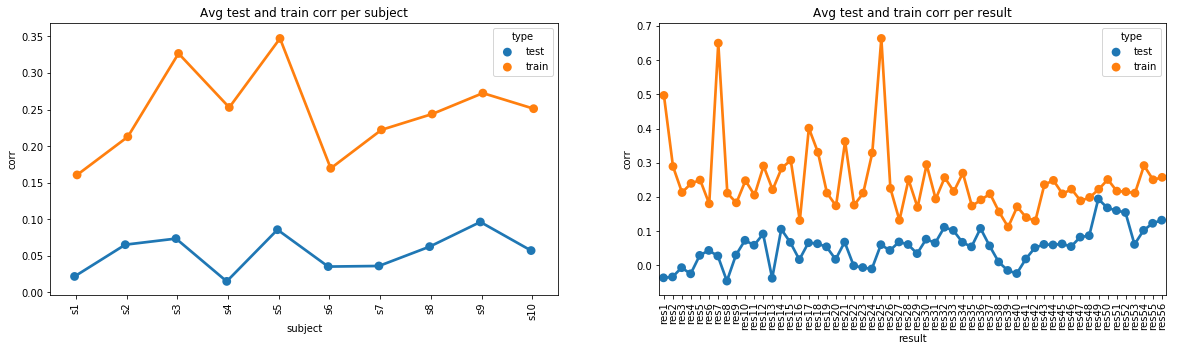

In [282]:
plot_general_corr_results(all_results)

In [61]:
def plot_weighted_sums(s, results, plot_title=None):
    if type(results) == list:
        
        fig, axes = plt.subplots(len(results), 2, figsize=(5, 3 * len(results)))
        fig.tight_layout(pad=1.0, w_pad=2.0, h_pad=3.0)  # to make room for titles and feature names
        axes = axes.flatten()
        for i in range(len(results)):
            test_data = pd.DataFrame({"sums_X_test": results[i][s]["cross_val"]["sums_X_test"], 
                                "sums_Y_test": results[i][s]["cross_val"]["sums_Y_test"]})
            train_data = pd.DataFrame({"sums_X_train": results[i][s]["cross_val"]["sums_X_train"],
                                "sums_Y_train": results[i][s]["cross_val"]["sums_Y_train"]}) 
            sns.scatterplot(x="sums_X_test", y="sums_Y_test", data=test_data, ax=axes[i * 2]).set(
                xlabel="X test sums", ylabel="Y test sums", title="Test, %s, results %d" % (s, results[i]["nr"]))
            sns.scatterplot(x="sums_X_train", y="sums_Y_train", data=train_data, ax=axes[i * 2 + 1]).set(
                xlabel="X train sums", ylabel="Y train sums", title="Train, %s, results %d" % (s, results[i]["nr"]))
        
    elif type(results) == dict or type(results) == defaultdict:
        fig, axes = plt.subplots(1,2, figsize=(10.0, 4.0))
        test_data = pd.DataFrame({"sums_X_test": results[s]["cross_val"]["sums_X_test"], 
                            "sums_Y_test": results[s]["cross_val"]["sums_Y_test"]})
        train_data = pd.DataFrame({"sums_X_train": results[s]["cross_val"]["sums_X_train"],
                            "sums_Y_train": results[s]["cross_val"]["sums_Y_train"]}) 
        ax1 = sns.scatterplot(x="sums_X_test", y="sums_Y_test", data=test_data, ax=axes[0])
        ax2 = sns.scatterplot(x="sums_X_train", y="sums_Y_train", data=train_data, ax=axes[1])
        ax1.set(xlabel="X test sums", ylabel="Y test sums", title="Test, %s, results %d" % (s, results["nr"]))
        ax2.set(xlabel="X train sums", ylabel="Y train sums", title="Train, %s, results %d" % (s, results["nr"]))
    
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')


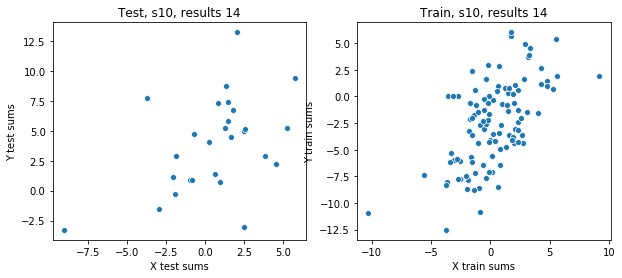

In [62]:
plot_weighted_sums('s10', results_14)

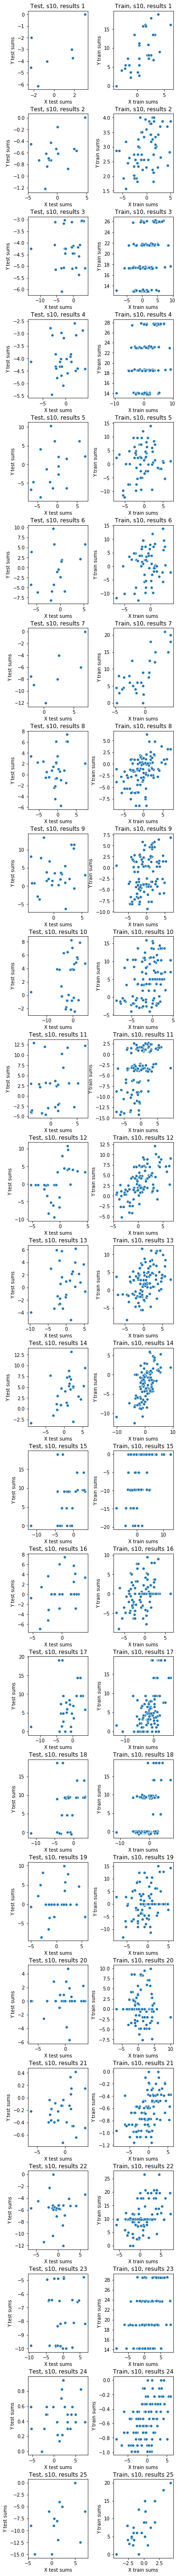

In [63]:
plot_weighted_sums('s10', all_results, 'weightedsums_s10_allres')

In [64]:
def plot_experiment_results(results, plot_title=None):
    
    fig, axes = plt.subplots(len(results), 2, figsize=(10, 6 * len(results)))
    fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=10.0)  # to make room for titles and feature names
    axes = axes.flatten()
    y_feature_axes = []
    for i in range(len(results)):
        y_features = results[i]["Y_features"]
        y_feature_scores = np.repeat(0.0, len(y_features))
        mean_test_corrs = []
        mean_train_corrs = []
        
        for s in SUBJECTS:
            # 1. calculate the mean test and train correlations
            mean_test_corr = round(np.array(results[i][s]["cross_val"]["test_corrs"]).mean(), 3)
            mean_train_corr = round(np.array(results[i][s]["cross_val"]["train_corrs"]).mean(), 3)
            mean_test_corrs.append(mean_test_corr)
            mean_train_corrs.append(mean_train_corr)
            
            # should also calculate std? std = round(np.array(results[s]["cross_val"][type_ + "_corrs"]).std(), 3)
        
            # 2. calculate mean coefs for Y features
            mean_y = np.array(results[i][s]["cross_val"]["y_weights"]).mean(axis=0)
            for j in range(len(y_features)):
                y_feature_scores[j] += mean_y[j]
        
        for j in range(len(y_features)):
            y_feature_scores[j] /= len(SUBJECTS)
        
        # First plot
        data1 = pd.DataFrame({"subject": SUBJECTS + SUBJECTS, "corr": mean_test_corrs + mean_train_corrs, 
                             "type": np.append(np.repeat("test", len(SUBJECTS)), np.repeat("train", len(SUBJECTS)))})
        sns.pointplot(x="subject", y="corr", hue="type", data=data1, dodge=True, ax=axes[i * 2]).set(
            title="Test and train corrs, results %d" % results[i]["nr"])
        
        # Second plot
        data2 = pd.DataFrame({"feature": y_features, "coef": y_feature_scores})
        sns.pointplot(x="feature", y="coef", data=data2, dodge=True, ax=axes[i * 2 + 1]).set(
            title="Top Y features, results %d" % results[i]["nr"], xlabel="") # no xlabel, won't fit
        
        y_feature_axes.append(axes[i * 2 + 1])
    
    fix_labels(y_feature_axes, angle=90)  # only rotate the y feature names
    
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')

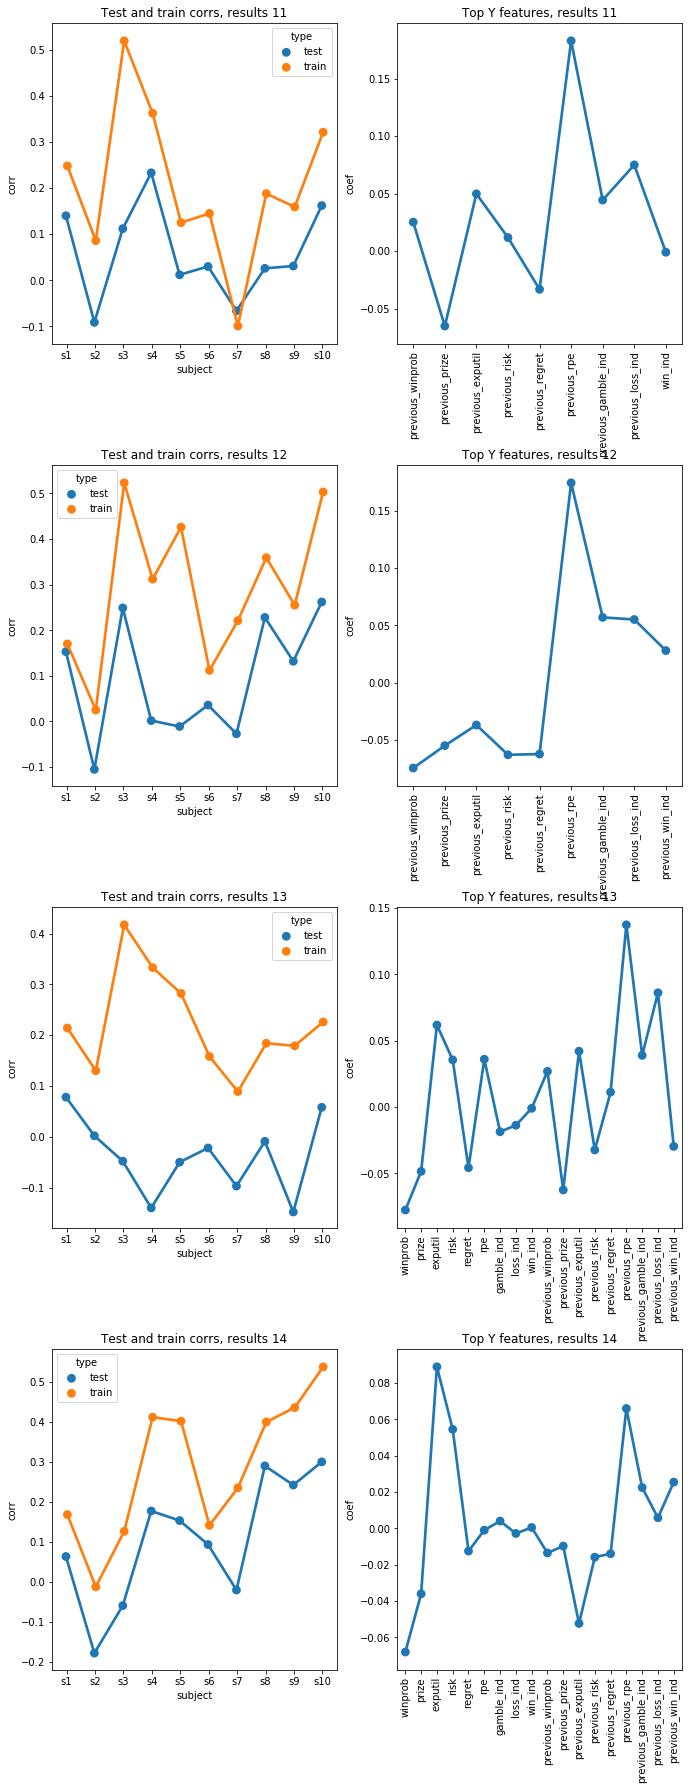

In [65]:
plot_experiment_results([results_11, results_12, results_13, results_14], "exp_res11-14")

In [66]:
def plot_patient_results(s, results, plot_title=None):
    # 1. Y features with mean coefs
    # 2. electrodes with mean coefs
    
    fig, axes = plt.subplots(len(results), 2, figsize=(10, 6 * len(results)))
    fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=10.0)  # to make room for titles and feature names
    axes = axes.flatten()
    
    for i in range(len(results)):
        res = results[i]
        
        mean_X_coefs = np.array(res[s]["cross_val"]["x_weights"]).mean(axis=0)
        mean_Y_coefs = np.array(res[s]["cross_val"]["y_weights"]).mean(axis=0)
        
        # First plot
        data1 = pd.DataFrame({"elec": ["elec" + str(j) for j in range(1, N_ELEC[s] + 1)], 
                              "coef": mean_X_coefs})
        sns.pointplot(x="elec", y="coef", data=data1, dodge=True, ax=axes[i * 2]).set(
            title="Mean electrode coefs, results %d" % res["nr"], xlabel="")
        
        # Second plot
        data2 = pd.DataFrame({"feature": res["Y_features"], "coef": mean_Y_coefs})
        sns.pointplot(x="feature", y="coef", data=data2, dodge=True, ax=axes[i * 2 + 1]).set(
            title="Mean regressor coefs, results %d" % res["nr"], xlabel="")
    
    fix_labels(axes)
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')        


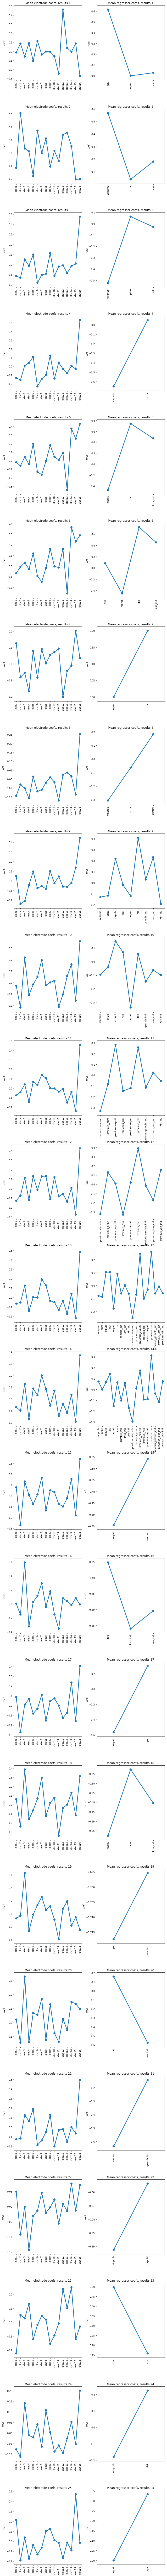

In [67]:
plot_patient_results('s10', all_results, "patient10_allres")

In [234]:
def plot_regressor_results(results=all_results, subjects=SUBJECTS):
    # Y features with mean coefs
    # (top) Y features with mean coefs for
        # (a) results where time period between game presentation and buttonpress
        # (b) results where time period after outcome reveal
    cases_a = [2, 3, 4, 8, 9, 11, 13, 21, 22, 23, 24, 26]  # the numbers of the results which are of case a
    cases_b = [1, 5, 6, 7, 10, 12, 14, 15, 16, 17, 18, 19, 20, 25]  # the numbers of the results which are of case b
    y_features_counts = defaultdict(list)  # counts in how many results the feature is
    y_features_coefs = defaultdict(float)  # the (mean) coeficients
    coefs_counts = defaultdict(lambda: defaultdict(int))
    # for every feature: "mean_a" (float), "mean_b" (float), "cases_a" (int), "cases_b" (int)
    
    for result in results:
        y_features = result["Y_features"]
        res_nr = result["nr"]
        case = "cases_a" if res_nr in cases_a else "cases_b"
        case_mn = "mean_a" if res_nr in cases_a else "mean_b"
        
        # Increase the counts
        for f in y_features:
            coefs_counts[f][case] += 1
            
        for s in subjects:
            mean_Y_coefs = np.array(result[s]["cross_val"]["y_weights"]).mean(axis=0)
            
            # for every feature in this result, add to the corresponding mean sum
            for j in range(len(y_features)):
                coefs_counts[y_features[j]][case_mn] += mean_Y_coefs[j]
    
    for f in coefs_counts:
        cases = coefs_counts[f]["cases_a"] + coefs_counts[f]["cases_b"]
        # divide by the number of results the feature appeared in
        coefs_counts[f]["mean"] = (coefs_counts[f]["mean_a"] + coefs_counts[f]["mean_b"]) / (cases * len(subjects))
        if coefs_counts[f]["cases_a"] > 0:
            coefs_counts[f]["mean_a"] /= coefs_counts[f]["cases_a"] * len(subjects)
        if coefs_counts[f]["cases_b"] > 0:
            coefs_counts[f]["mean_b"] /= coefs_counts[f]["cases_b"] * len(subjects)

    data = pd.DataFrame.from_dict(coefs_counts).transpose()  # cases_a, cases_b, mean, mean_a, mean_b are the columns
    # regressors are the indices
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    plt.tight_layout()
    axes = axes.flatten()
    
    # First plot
    data1 = pd.DataFrame({"regressor": data.index, "coef": data["mean"]}).sort_values(by="coef")
    sns.pointplot(x="regressor", y="coef", data=data1, dodge=True, ax=axes[0]).set(
        title="Mean regressor coefs", xlabel="")

    # Second plot
    data2 = pd.DataFrame({"regressor": data[data["cases_a"] != 0].index, "coef": data[data["cases_a"] != 0]["mean_a"]}).sort_values(by="coef")
    sns.pointplot(x="regressor", y="coef", data=data2, dodge=True, ax=axes[1]).set(
        title="Mean regressor coefs for case A", xlabel="", ylabel="")  # only need the leftmost y label 

        # Second plot
    data3 = pd.DataFrame({"regressor": data[data["cases_b"] != 0].index, "coef": data[data["cases_b"] != 0]["mean_b"]}).sort_values(by="coef")
    sns.pointplot(x="regressor", y="coef", data=data3, dodge=True, ax=axes[2]).set(
        title="Mean regressor coefs for case B", xlabel="", ylabel="")  # only need the leftmost y label 
    
    fix_labels(axes)
    fig.savefig("mean_regressor_coefs.png", bbox_inches='tight')


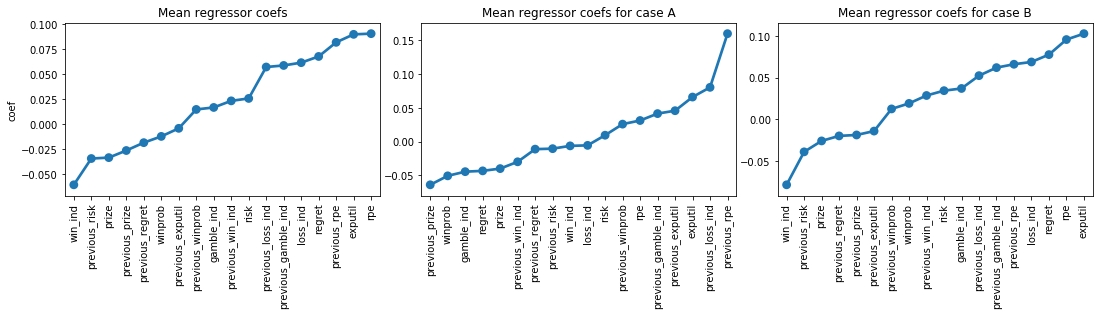

In [235]:
plot_regressor_results()

In [70]:
def similarities_subject(subjects=SUBJECTS, results=all_results):
    n_s = len(subjects)
    n_r = len(results)
    similarities_elec = {}
    similarities_Y = {}
        
    for s in subjects:
        elecs = np.array(["elec" + str(i) for i in range(1, N_ELEC[s] + 1)])
        similarities_elec[s] = np.ones((n_r, n_r))
        similarities_Y[s] = np.ones((n_r, n_r))
        
        # For every result: sort the electrodes by mean coef -> elec_sorted_1; sort regressors by mean coef -> Y_sorted_1
        #     For every other result: sort elecs by mn coef -> elec_sorted_2; sort regrs by mn coef -> Y_sorted_2
        #     Then compare with ratio: (1) elec_sorted_1 and elec_sorted_2 (2) and Y_sorted_1 and Y_sorted_2
        for i in range(n_r):
            res_1 = results[i]
            y_features_1 = np.array(res_1["Y_features"])
            mean_X_coefs_1 = np.array(res_1[s]["cross_val"]["x_weights"]).mean(axis=0)
            mean_Y_coefs_1 = np.array(res_1[s]["cross_val"]["y_weights"]).mean(axis=0)
            sorted_X_idx_1 = np.argsort(mean_X_coefs_1)[::-1] # reverse argsort
            sorted_Y_idx_1 = np.argsort(mean_Y_coefs_1)[::-1] # reverse argsort
            elec_sorted_1 = elecs[sorted_X_idx_1] # sort electrodes by mean coef
            Y_sorted_1 = y_features_1[sorted_Y_idx_1] # sort regressors
            
            for j in range(i + 1, n_r):
                res_2 = results[j]
                y_features_2 = np.array(res_2["Y_features"])
                mean_X_coefs_2 = np.array(res_2[s]["cross_val"]["x_weights"]).mean(axis=0)
                mean_Y_coefs_2 = np.array(res_2[s]["cross_val"]["y_weights"]).mean(axis=0)
                sorted_X_idx_2 = np.argsort(mean_X_coefs_2)[::-1] # reverse argsort
                sorted_Y_idx_2 = np.argsort(mean_Y_coefs_2)[::-1] # reverse argsort
                elec_sorted_2 = elecs[sorted_X_idx_2] # sort electrodes by mean coef
                Y_sorted_2 = y_features_2[sorted_Y_idx_2] # sort regressors
                
                sm_elec = SequenceMatcher(None, elec_sorted_1, elec_sorted_2)
                similarities_elec[s][i][j] = round(sm_elec.ratio(), 2)
                
                sm_Y = SequenceMatcher(None, Y_sorted_1, Y_sorted_2)
                similarities_Y[s][i][j] = round(sm_Y.ratio(), 2)
            
            similarities_elec[s][:, i] = similarities_elec[s][i, :]
            similarities_Y[s][:, i] = similarities_Y[s][i, :]

        
        labels = ["res" + str(i) for i in range(1, n_r + 1)]
        data_elec = pd.DataFrame(similarities_elec[s], columns=labels, index=labels)
        data_Y = pd.DataFrame(similarities_Y[s], columns=labels, index=labels)
        similarities_elec[s] = data_elec
        similarities_Y[s] = data_Y
        
    return similarities_elec, similarities_Y

In [71]:
similarities_elec, similarities_Y = similarities_subject()

In [72]:
def plot_similarities(sim_elec, sim_Y, subjects=SUBJECTS, results=all_results):
    n_res = len(results)
    n_sub = len(subjects)
    labels = ["res" + str(i) for i in range(1, n_res + 1)]
    fig, axes = plt.subplots(n_sub, 2, figsize=(16, 6 * n_sub))
    axes = axes.flatten()
    
    for i in range(n_sub):
        s = subjects[i]
        sim_elec_s = sim_elec[s]
        sim_Y_s = sim_Y[s]
    
        # First plot
        sns.heatmap(sim_elec_s, annot=True, annot_kws={"size":10}, fmt='g', xticklabels=labels, yticklabels=labels, 
                    ax=axes[i * 2]).set(title="Subject %s, electrode similarities" % s)
        
        # Second plot
        sns.heatmap(sim_Y_s, annot=True, annot_kws={"size":10}, fmt='g', xticklabels=labels, yticklabels=labels, 
                    ax=axes[i * 2 + 1]).set(title="Subject %s, regressor similarities" % s)

    fix_labels(axes)
    fig.savefig("similarities_per_subject.png", bbox_inches='tight')

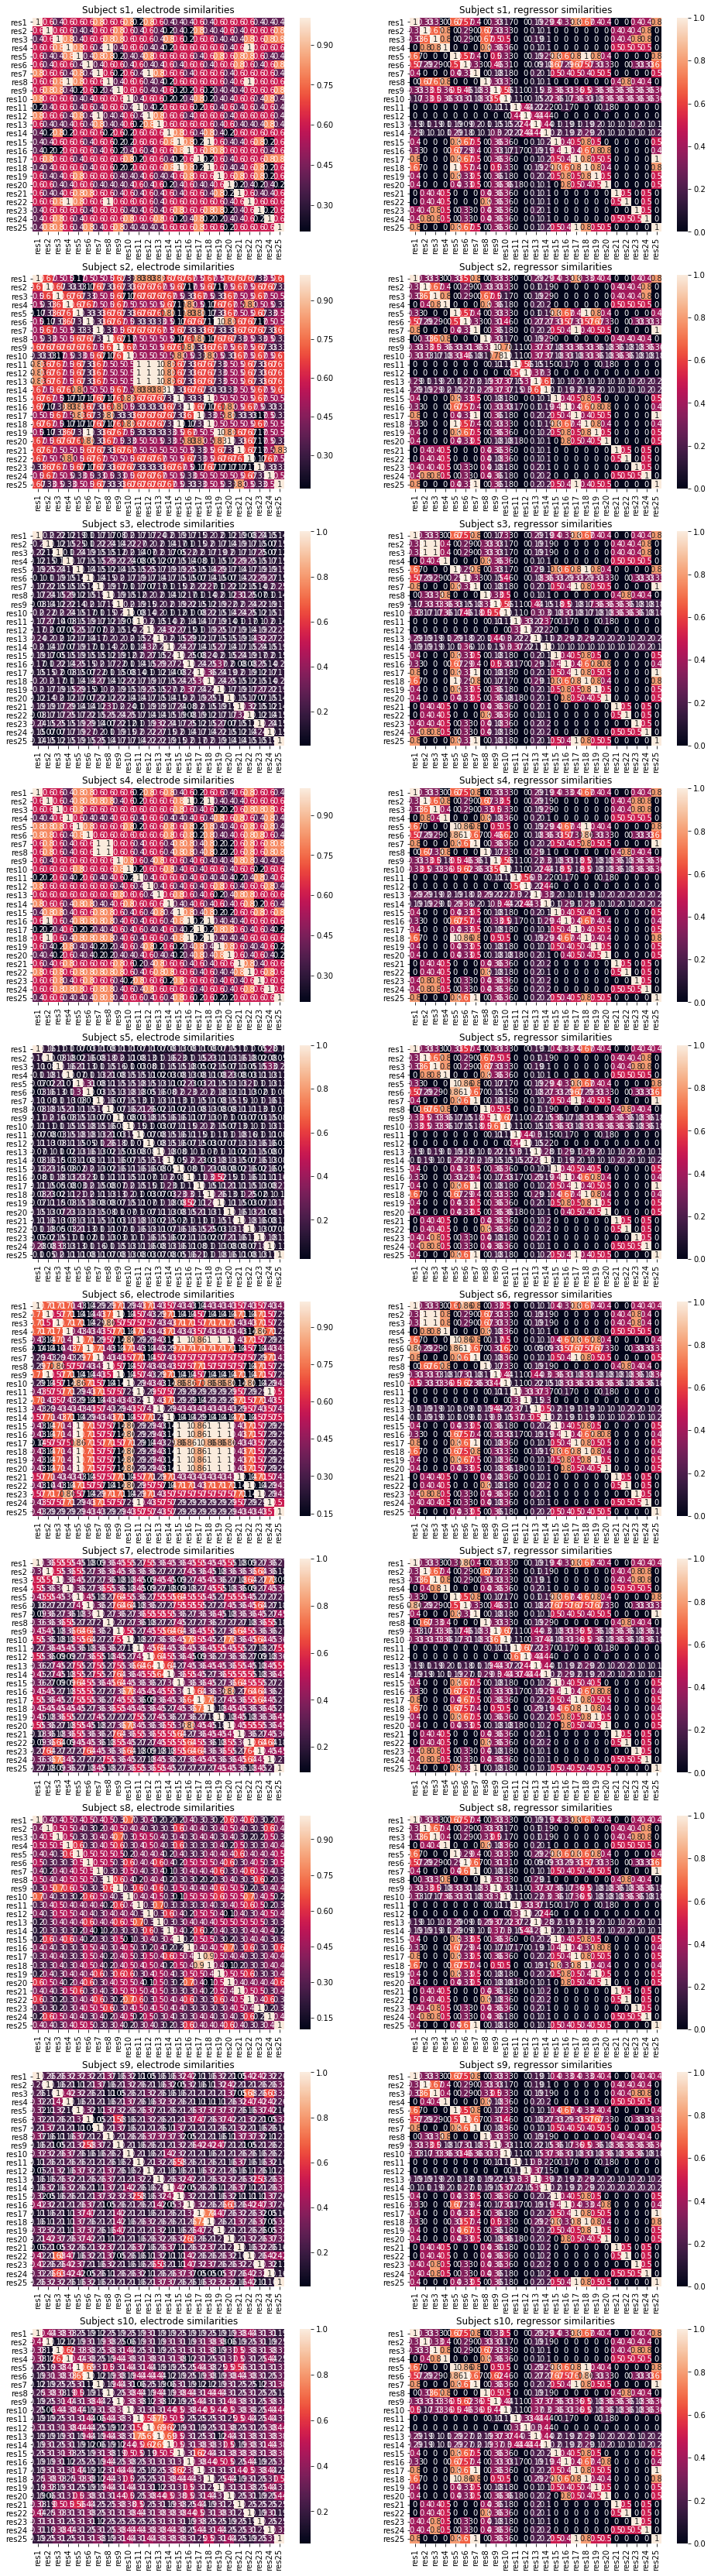

In [73]:
plot_similarities(similarities_elec, similarities_Y)

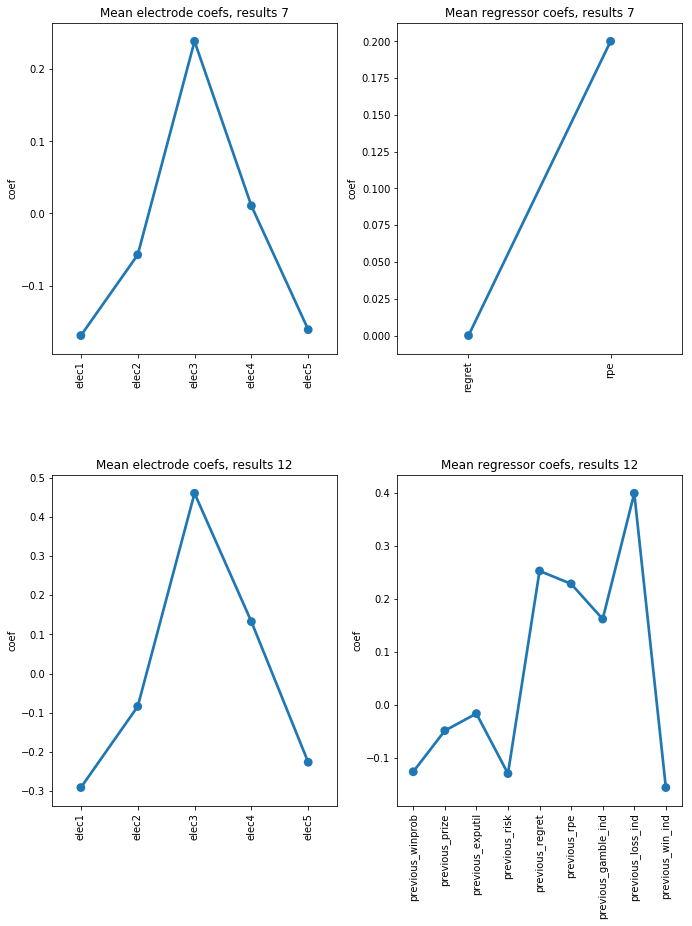

In [74]:
plot_patient_results('s1', [results_7, results_12])

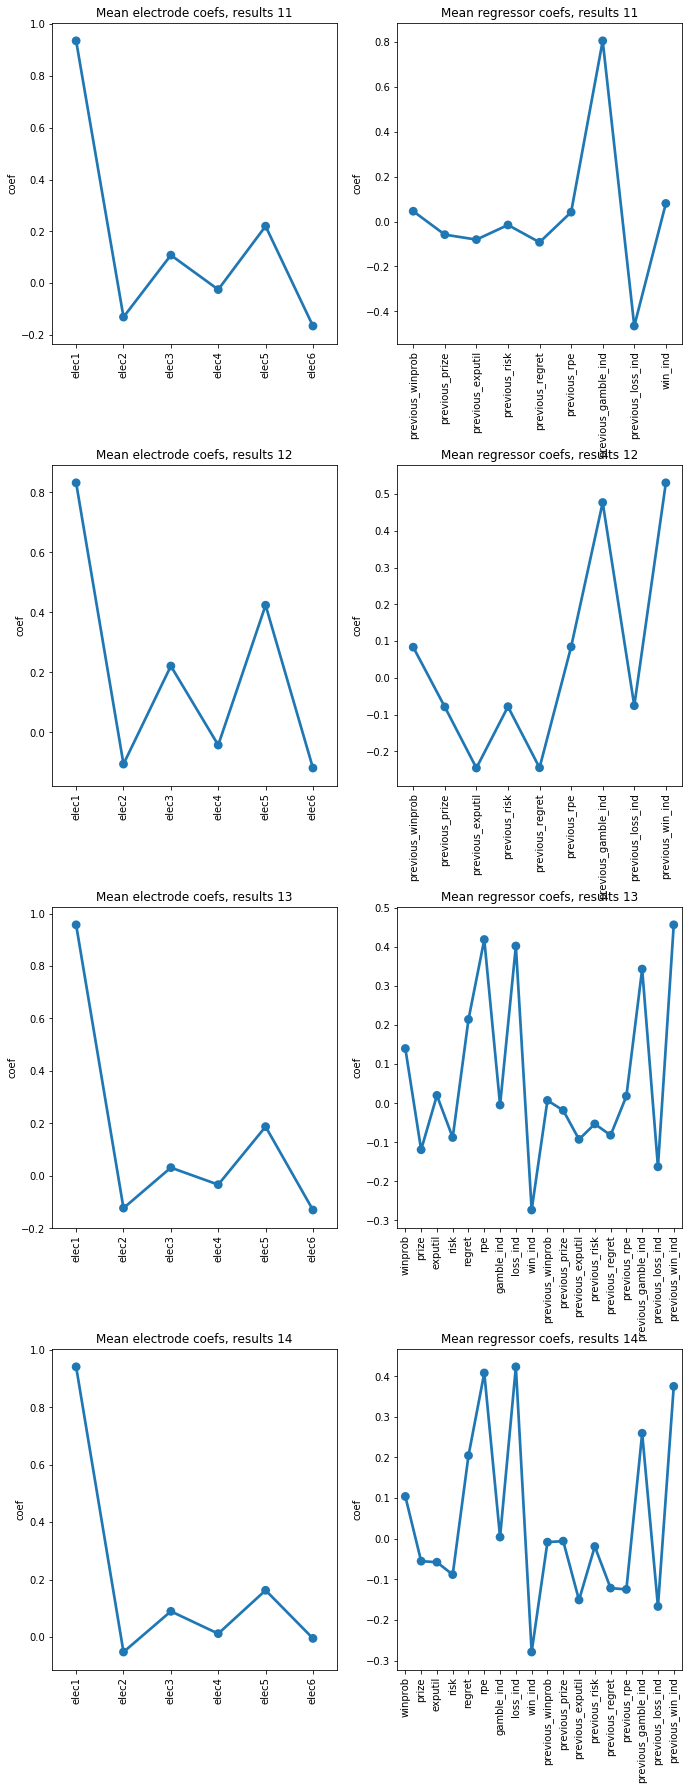

In [75]:
plot_patient_results('s2', [results_11, results_12, results_13, results_14])

In [76]:
def similarities_result(subjects=SUBJECTS, results=all_results):
    n_s = len(subjects)
    n_r = len(results)
    similarities_Y = {}
    
        
    for res in results:
        y_features = np.array(res["Y_features"])
        res_nr = res["nr"]
        similarities_Y[res_nr] = np.ones((n_s, n_s))
        
        for i in range(n_s):
            s_1 = subjects[i]
            mean_Y_coefs_1 = np.array(res[s_1]["cross_val"]["y_weights"]).mean(axis=0)
            sorted_Y_idx_1 = np.argsort(mean_Y_coefs_1)[::-1] # reverse argsort
            Y_sorted_1 = y_features[sorted_Y_idx_1] # sort regressors
            
            for j in range(i + 1, n_s):
                s_2 = subjects[j]
                mean_Y_coefs_2 = np.array(res[s_2]["cross_val"]["y_weights"]).mean(axis=0)
                sorted_Y_idx_2 = np.argsort(mean_Y_coefs_2)[::-1] # reverse argsort
                Y_sorted_2 = y_features[sorted_Y_idx_2] # sort regressors
                
                sm = SequenceMatcher(None, Y_sorted_1, Y_sorted_2)
                similarities_Y[res_nr][i][j] = round(sm.ratio(), 2)
            
            similarities_Y[res_nr][:, i] = similarities_Y[res_nr][i, :]

        
        labels = ["s" + str(i) for i in range(1, n_s + 1)]
        data_Y = pd.DataFrame(similarities_Y[res_nr], columns=labels, index=labels)
        similarities_Y[res_nr] = data_Y
        
    return similarities_Y

In [77]:
similarities_res_Y = similarities_result()
similarities_res_Y[1]

s1    s2    s3    s4    s5    s6    s7    s8    s9   s10
s1   1.00  0.33  0.67  0.67  1.00  0.33  0.33  0.67  0.67  0.67
s2   0.33  1.00  0.67  0.67  0.33  1.00  1.00  0.67  0.67  0.67
s3   0.67  0.67  1.00  1.00  0.67  0.67  0.67  0.33  1.00  1.00
s4   0.67  0.67  1.00  1.00  0.67  0.67  0.67  0.33  1.00  1.00
s5   1.00  0.33  0.67  0.67  1.00  0.33  0.33  0.67  0.67  0.67
s6   0.33  1.00  0.67  0.67  0.33  1.00  1.00  0.67  0.67  0.67
s7   0.33  1.00  0.67  0.67  0.33  1.00  1.00  0.67  0.67  0.67
s8   0.67  0.67  0.33  0.33  0.67  0.67  0.67  1.00  0.33  0.33
s9   0.67  0.67  1.00  1.00  0.67  0.67  0.67  0.33  1.00  1.00
s10  0.67  0.67  1.00  1.00  0.67  0.67  0.67  0.33  1.00  1.00

In [78]:
def plot_similarities_res(sim_Y, subjects=SUBJECTS, results=all_results):
    n_res = len(results)
    n_sub = len(subjects)
    labels = ["s" + str(i) for i in range(1, n_sub + 1)]
    fig, axes = plt.subplots(int(n_res / 2), 2, figsize=(16, 6 * int(n_res / 2)))
    axes = axes.flatten()
    
    for i in range(n_res):
        res_nr = results[i]["nr"]
        sim_Y_s = sim_Y[res_nr]
    
        sns.heatmap(sim_Y_s, annot=True, annot_kws={"size":10}, fmt='g', xticklabels=labels, yticklabels=labels, 
                    ax=axes[i]).set(title="Result %d, regressor similarities" % res_nr)

    fix_labels(axes)
    fig.savefig("similarities_per_result.png", bbox_inches='tight')    


IndexError: index 24 is out of bounds for axis 0 with size 24

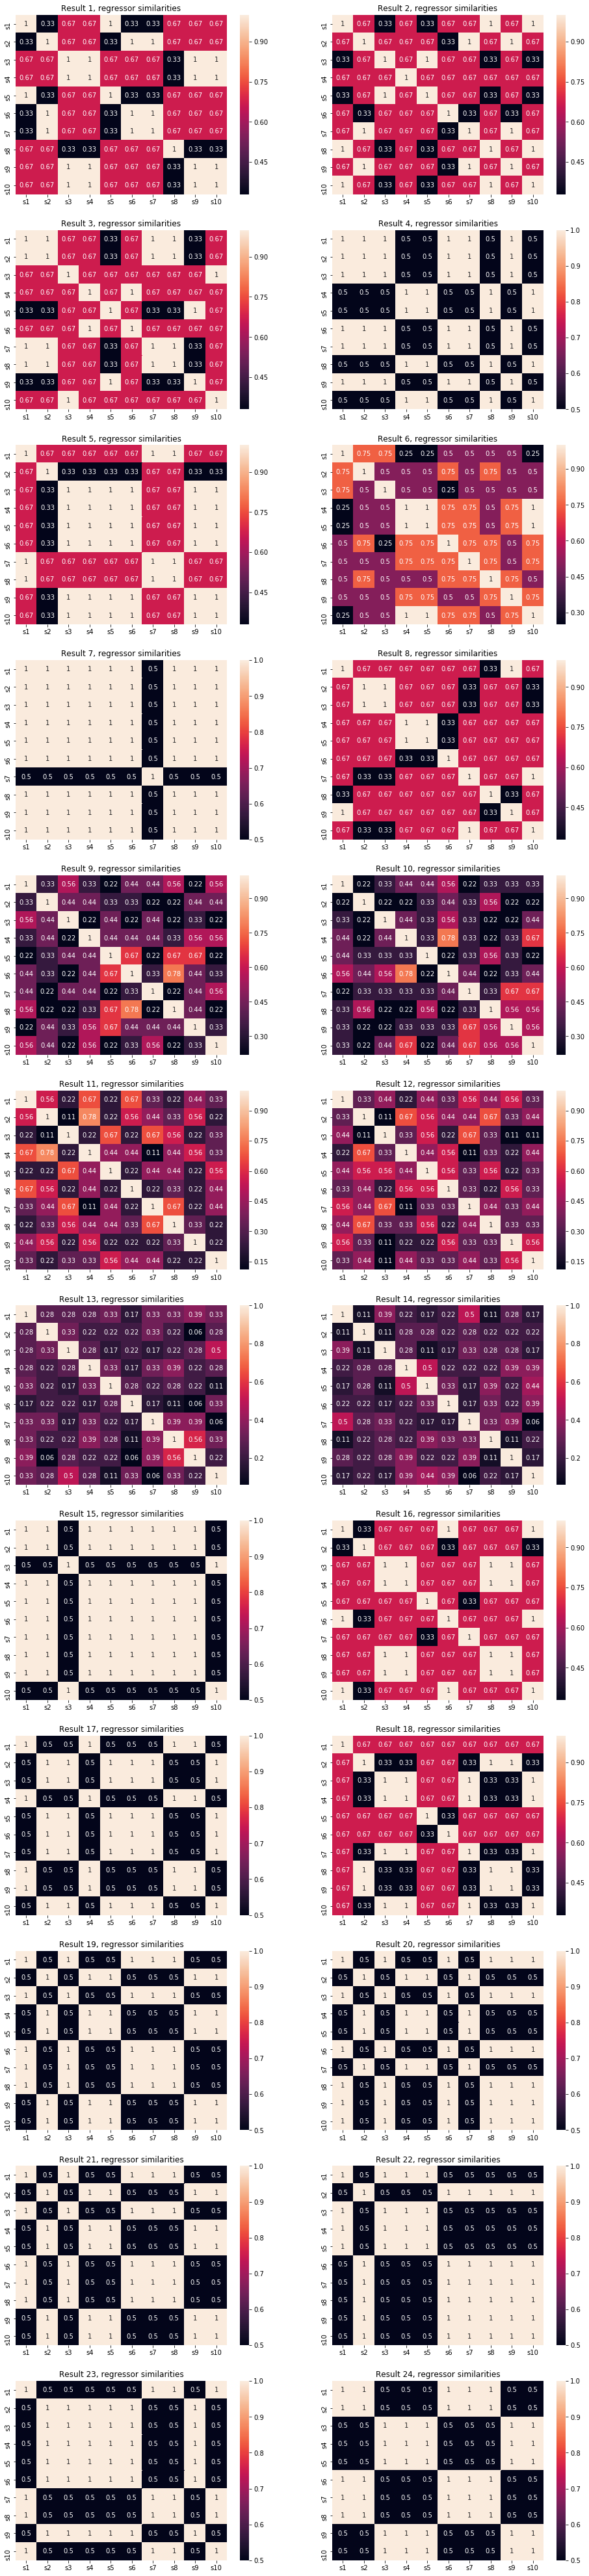

In [79]:
plot_similarities_res(similarities_res_Y)

In [ ]:
for s in SUBJECTS:
    plot_patient_results(s, [results_7])

In [240]:
from math import ceil 

def plot_onereg_multel(results, plot_title=None):
    n_res = len(results)
    fig, axes = plt.subplots(n_res, 1, figsize=(10, 10 * n_res))
    fig.tight_layout(pad=3.0, w_pad=3.0, h_pad=15.0)  # to make room for titles and feature names
    axes = axes.flatten()
    
    for i in range(n_res):
        res = results[i]
        subjects = []
        regressors = []
        mean_corrs = []
        labels = []
        
        for s in SUBJECTS:
            for regr in fr.REGR_ATTRIBUTES:
                avg_test_corr = np.array(res[s][regr]["cross_val"]["test_corrs"]).mean()
                avg_train_corr = np.array(res[s][regr]["cross_val"]["train_corrs"]).mean()
                
                mean_corrs.append(avg_test_corr)
                labels.append("test")
                mean_corrs.append(avg_train_corr)
                labels.append("train")
                for _ in range(2):
                    subjects.append(s)
                    regressors.append(regr)
                
        assert len(set([len(labels), len(mean_corrs), len(subjects), len(regressors)])) == 1, \
        "Columns not equal length! labels: %d, corrs: %d, subjects: %d, regressors: %d" % (
        len(labels), len(mean_corrs), len(subjects), len(regressors))
        
        data = pd.DataFrame({'corr': mean_corrs, 'type': labels, 'subject': subjects, 
                             'regressor': regressors})
        sns.scatterplot(x="regressor", y="corr", hue="subject", style="type", data=data, ax=axes[i]).set(
                title="Experiment %d train and test corrs" % res["nr"], xlabel="")
        
        # Show only one legend on every row
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    
    fix_labels(axes)
    if plot_title != None:
        fig.savefig(plot_title + ".png", bbox_inches='tight')

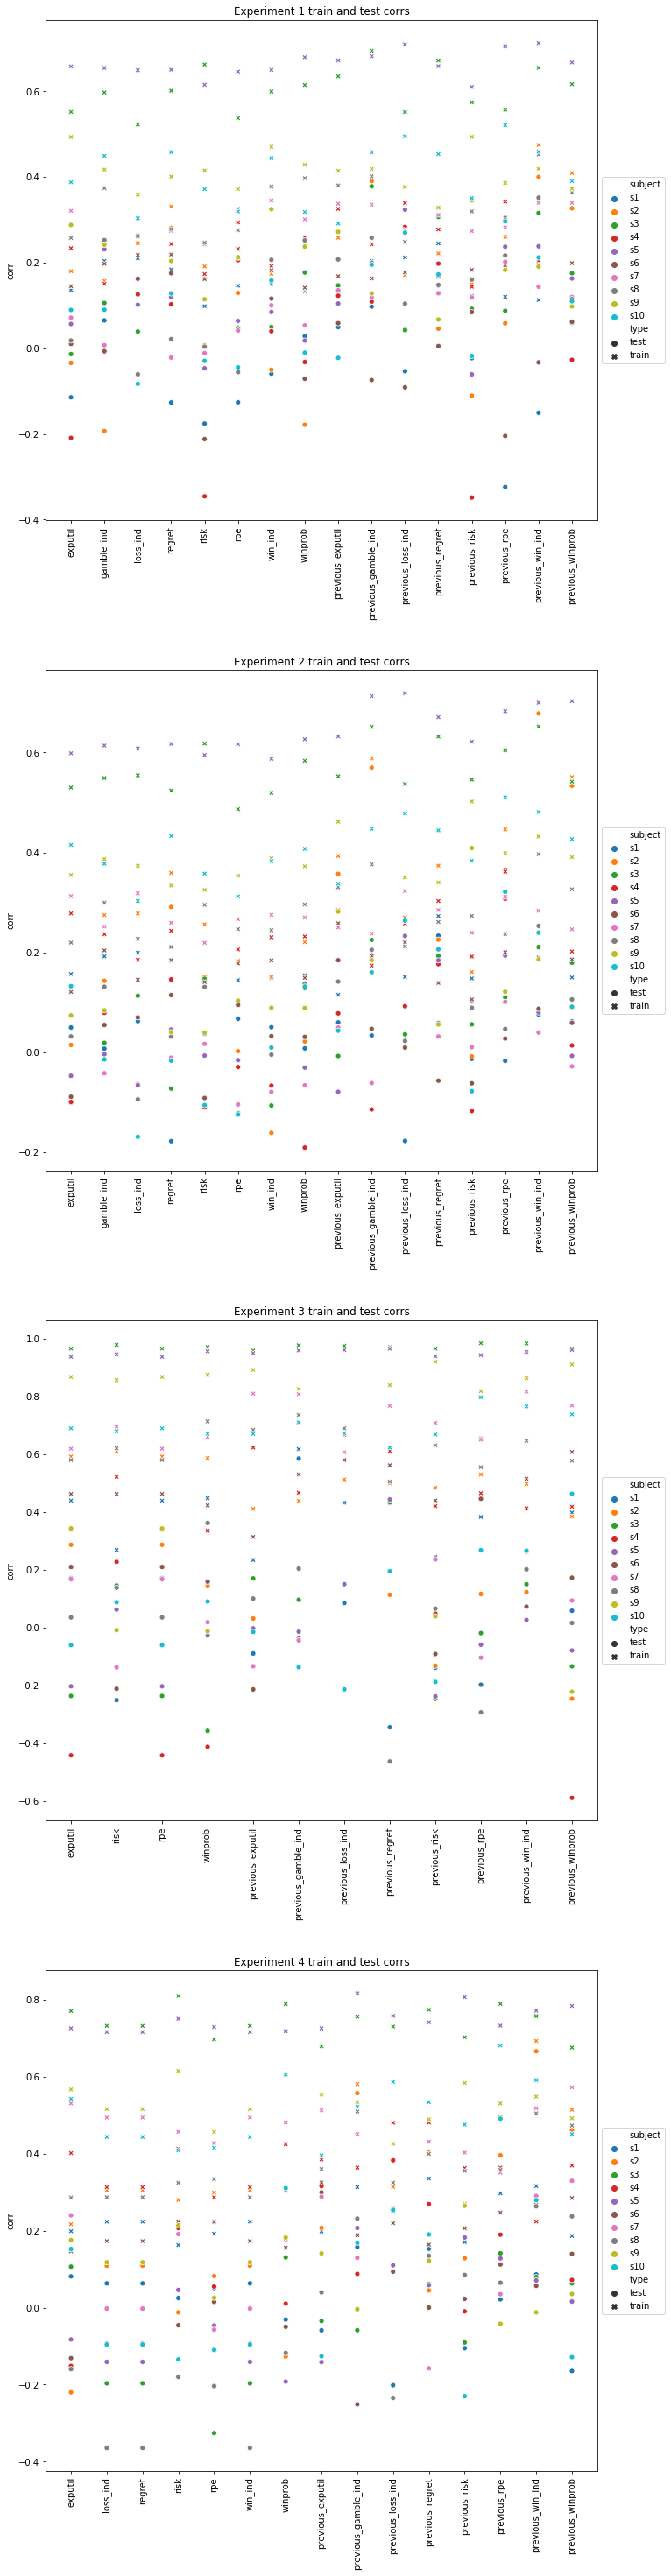

In [241]:
plot_onereg_multel([results_reg_1, results_reg_2, results_reg_3, results_reg_4], "all_elecs_one_reg")